<a href="https://colab.research.google.com/github/bolingooli/Onlab/blob/main/CVAE_differentmasks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0. Setup

## 0.1 Imports

In [91]:
import torch
import torchvision
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torchvision import transforms
from torchvision.datasets import MNIST
from torch.autograd import Variable
from matplotlib import pyplot as plt
import numpy as np

## 0.2 Helpers

In [92]:
def set_default(figsize=(10, 10), dpi=100):
    plt.style.use(['dark_background', 'bmh'])
    plt.rc('axes', facecolor='k')
    plt.rc('figure', facecolor='k')
    plt.rc('figure', figsize=figsize, dpi=dpi)

import matplotlib.style
import matplotlib as mpl
# mpl.style.use('classic')
mpl.rcParams['image.cmap'] = 'viridis'


def display_images(img1, img2, img3, label, n=1, count=False):
    title_set = False
    for N in range(n):
      if img1 is not None:
        in_pic = img1.data.cpu().view(-1, 28, 28)
        plt.figure(figsize=(18, 6))
        if not title_set:
          plt.suptitle(label, color='w', fontsize=20)
          title_set = True
        for i in range(4):
            plt.subplot(1,4,i+1)
            plt.imshow(in_pic[i+4*N])
            plt.axis('off')
      if img3 is not None:
        pic3 = img3.data.cpu().view(-1, 28, 28)
        plt.figure(figsize=(18, 6))
        if not title_set:
          plt.suptitle(label, color='w', fontsize=20)
          title_set = True
        for i in range(4):
            plt.subplot(1,4,i+1)
            plt.imshow(pic3[i+4*N])
            plt.axis('off')
            if count: plt.title(str(4 * N + i), color='w')
      if img2 is not None:
        out_pic = img2.data.cpu().view(-1, 28, 28)
        plt.figure(figsize=(18, 6))
        if not title_set:
          plt.suptitle(label, color='w', fontsize=20)
          title_set = True
        for i in range(4):
            plt.subplot(1,4,i+1)
            plt.imshow(out_pic[i+4*N])
            plt.axis('off')
            if count: plt.title(str(4 * N + i), color='w')

def plot_samples_grid(ds_loader, n_rows=8, n_cols=8, fig_size=8, img_dim=(28,14), title=None):
  
  f, axarr = plt.subplots(n_rows, n_cols, figsize=(fig_size, fig_size))

  images, labels = next(iter(ds_loader))

  for i, ax in enumerate(axarr.flat):
      ax.imshow(images[i].view(img_dim))
      ax.axis('off')
      
  plt.suptitle(title)
  plt.show()

## 0.3 Globals

In [93]:
# set random seeds
torch.manual_seed(1)
torch.cuda.manual_seed(1)

# setup device cuda vs. cpu
cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if cuda else "cpu")

# 1. Prepare Dataset

## 1.1. Load MNIST and cover half of the pictures

In [94]:
# set batch size
batch_size = 256

'\nup=torch.ones((60000,1,14,28),dtype=torch.bool)\nbottomleft=torch.ones((60000,1,14,14),dtype=torch.bool)\nbottomright=torch.zeros((60000,1,14,14),dtype=torch.bool)\ndown=torch.cat((bottomleft,bottomright),3)\nmask=torch.cat((up,down),2)\ntest_mask=mask[0:10000]\n\nmask=torch.zeros(60000,1,28,28,dtype=bool)\nmask[:,:,:,::2]=True\ntest_mask=mask[0:10000]\n'

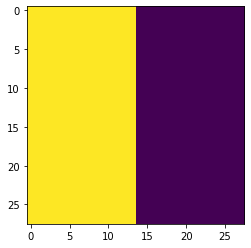

In [95]:
#different mask-making
mask = torch.ones((60000,1,28,28),dtype=bool)
mask[::3,:,:,::2]=False
mask[1::3,:,:,0:14]=False
mask[2::3,:,:,14:28]=False
test_mask=mask[0:10000]
plt.imshow(mask[2][0])
plt.show

"""
up=torch.ones((60000,1,14,28),dtype=torch.bool)
bottomleft=torch.ones((60000,1,14,14),dtype=torch.bool)
bottomright=torch.zeros((60000,1,14,14),dtype=torch.bool)
down=torch.cat((bottomleft,bottomright),3)
mask=torch.cat((up,down),2)
test_mask=mask[0:10000]

mask=torch.zeros(60000,1,28,28,dtype=bool)
mask[:,:,:,::2]=True
test_mask=mask[0:10000]
"""


In [96]:
#making train dataset

train_data = MNIST("./bin_data1", train=True, transform=transforms.ToTensor(), download=True)
#converting to tensor
train_digits = []
for batch_idx, (img, targets) in enumerate(train_data):
  train_digits.append(img)
train_digits=torch.stack(train_digits)

#pairing left pictures with right pictures
ds_train=TensorDataset(train_digits,mask)
ds_train_loader=DataLoader(ds_train,batch_size,shuffle=True,num_workers=1,pin_memory=cuda,drop_last=True)

test_data = MNIST("./bin_data1", train=False, transform=transforms.ToTensor(), download=True)
#converting to tensor
test_digits = []
for batch_idx, (img, targets) in enumerate(test_data):
  test_digits.append(img)
test_digits=torch.stack(test_digits)

#pairing left pictures with right pictures
ds_test=TensorDataset(test_digits,test_mask)
ds_test_loader=DataLoader(ds_test,batch_size,shuffle=True,num_workers=1,pin_memory=cuda,drop_last=True)

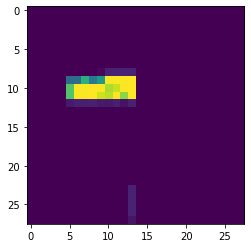

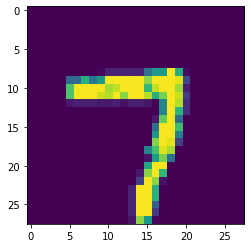

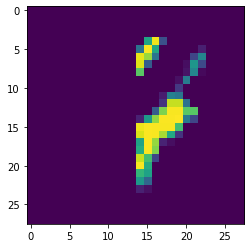

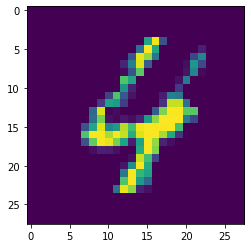

In [97]:

for x,y in ds_train_loader:
  plt.imshow(torch.where(y[10].squeeze(),x[10].squeeze(),torch.zeros((500000,28,28)))[10])
  plt.show()
  plt.imshow(x[10].squeeze())
  plt.show()
  break
for x,y in ds_test_loader:
  plt.imshow(torch.where(y[10].squeeze(),x[10].squeeze(),torch.zeros((500000,28,28)))[10])
  plt.show()
  plt.imshow(x[10].squeeze())
  plt.show()
  break


# 2. VAE

## 2.1. Setting up the model

### 2.1.1 Implement a VAE Module

In [98]:
# hyper params
latent_size = 512
featureDim= 1024

In [99]:
from torch.nn.modules.linear import Linear
from torch.nn.modules.conv import Conv2d
class VAE(nn.Module):

    def __init__(self):
        super().__init__()

        self.encoderConv = nn.Sequential(
            nn.Conv2d(1,16,4),
            nn.ReLU(),
            nn.Conv2d(16,32,4),
            nn.MaxPool2d(2,2),
            nn.ReLU(),
            nn.Conv2d(32,64,4),
            nn.MaxPool2d(2,2),
            nn.ReLU()
        )

        self.encoderMU = nn.Linear(featureDim,latent_size)
        self.encoderLogvar = nn.Linear(featureDim,latent_size)
        
        self.decoderLin = nn.Linear(latent_size,featureDim)

        self.decoderConv = nn.Sequential(
            nn.UpsamplingNearest2d(scale_factor = 2),
            nn.ConvTranspose2d(64,32,4),
            nn.ReLU(),
            nn.UpsamplingNearest2d(scale_factor = 2),
            nn.ConvTranspose2d(32,16,4),
            nn.ReLU(),
            nn.ConvTranspose2d(16,1,4),
            nn.Sigmoid(),
        )

    def reparameterise(self, mu, logvar):
        if self.training:
            std = torch.exp(logvar/2)
            eps = torch.randn_like(std)
            return mu + std * eps
        else:
            return mu

    def encode(self, x):
      filtered = self.encoderConv(x)
      x=filtered.view(-1,featureDim)
      mu =self.encoderMU(x)
      logvar = self.encoderLogvar(x)
      return mu, logvar

    def decode(self, z):
      z=self.decoderLin(z)
      return self.decoderConv(z.view(-1,64,4,4))

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterise(mu, logvar)
        x_hat = self.decode(z)
        return x_hat, mu, logvar

    def sample(self, n_samples):
      z = torch.randn((batch_size,1,n_samples, latent_size)).to(device)
      return self.decode(z)

model = VAE().to(device)

In [100]:
# Setting the optimiser
learning_rate = 0.001

optimizer=torch.optim.RMSprop(model.parameters(),learning_rate)
#optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)

In [101]:
# Reconstruction + KL divergence losses summed over all elements and batch
def loss_function(x_hat, x, mu, logvar):
    #reconstruction loss (pushing the points apart)
    BCE = nn.functional.binary_cross_entropy(
        x_hat, x, reduction='sum'
    )

    # KL divergence loss (the relative entropy between two distributions a multivariate gaussian and a normal)
    # (enforce a radius of 1 in each direction + pushing the means towards zero)
    KLD = 0.5 * torch.sum(logvar.exp() - logvar - 1 + mu.pow(2))

    return BCE + KLD # we can use a beta parameter here (BCE + beta * KLD)

### 2.1.2. Generate samples from the untrained model

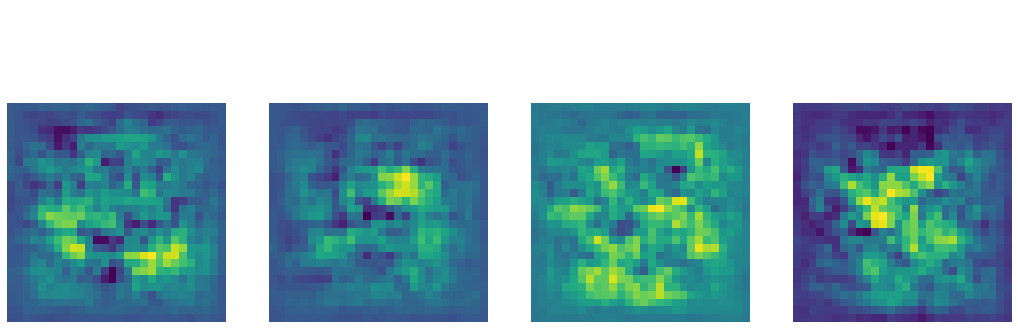

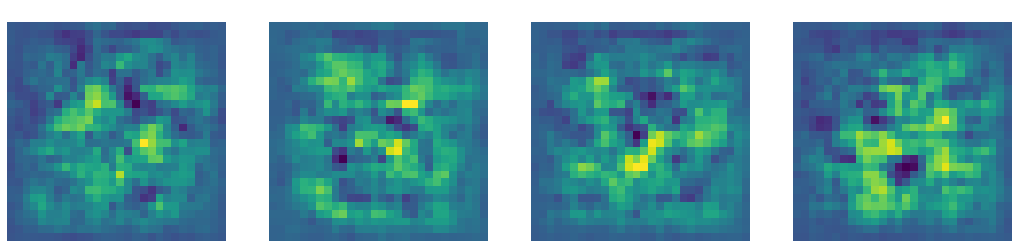

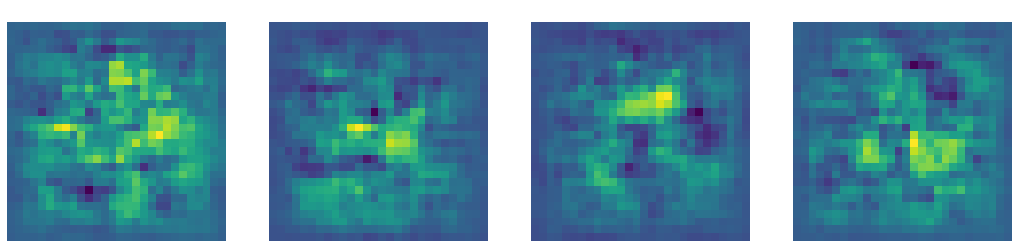

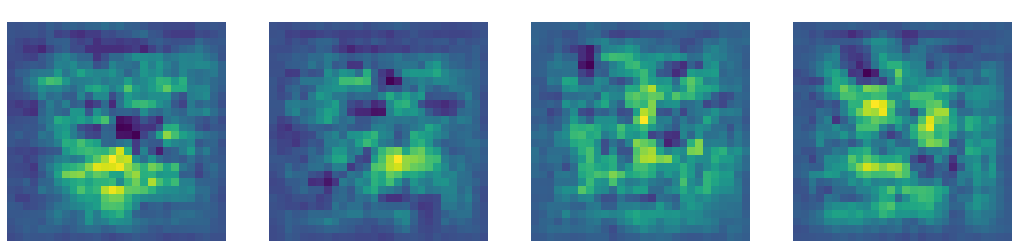

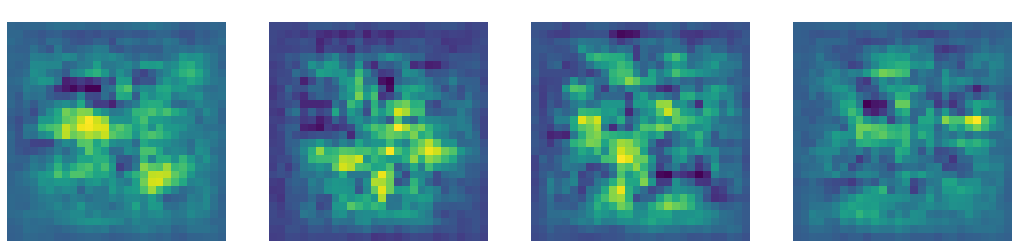

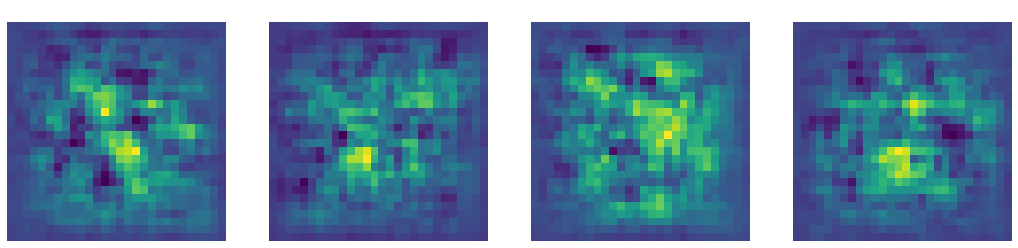

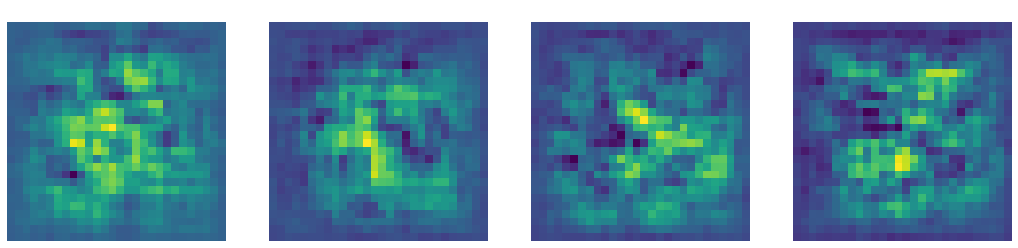

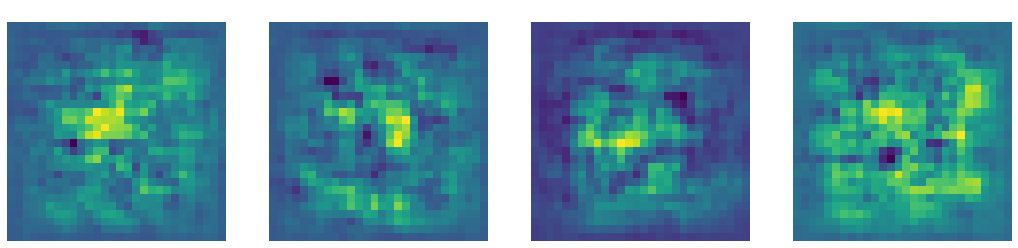

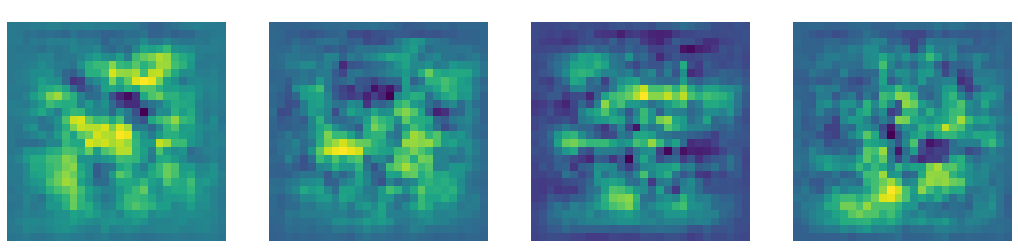

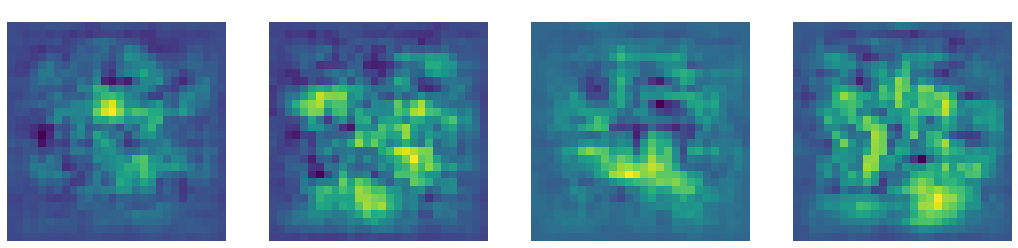

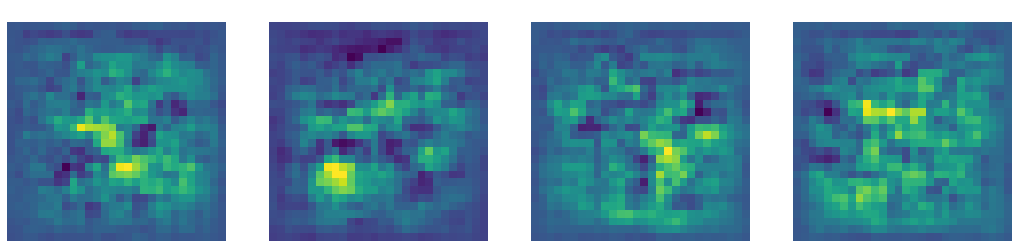

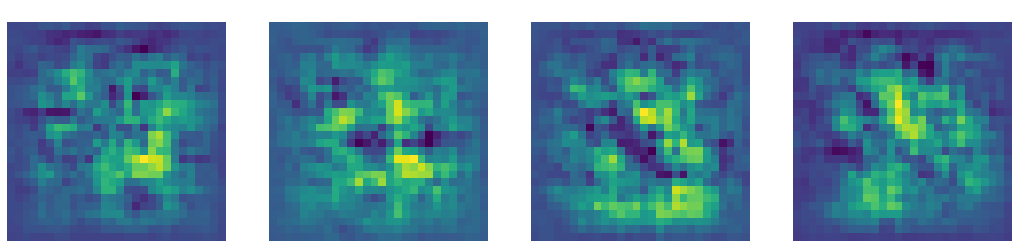

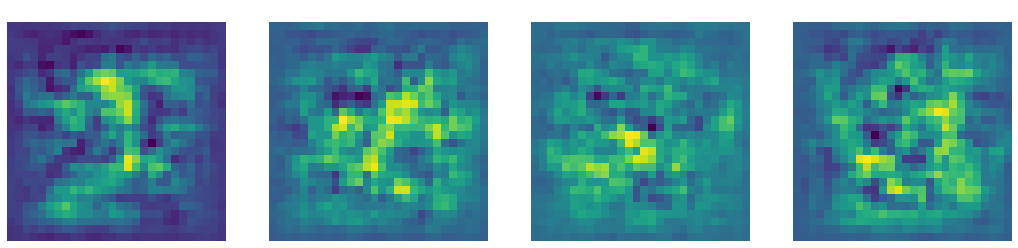

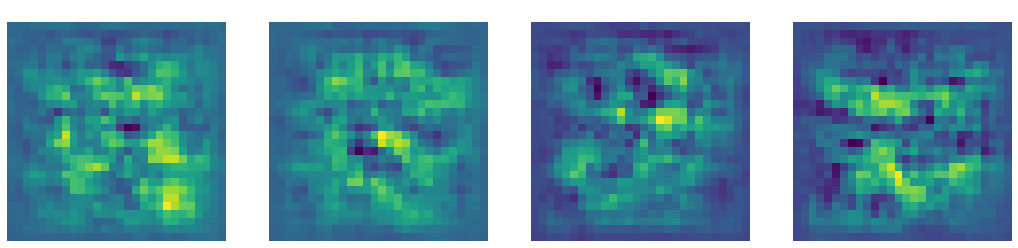

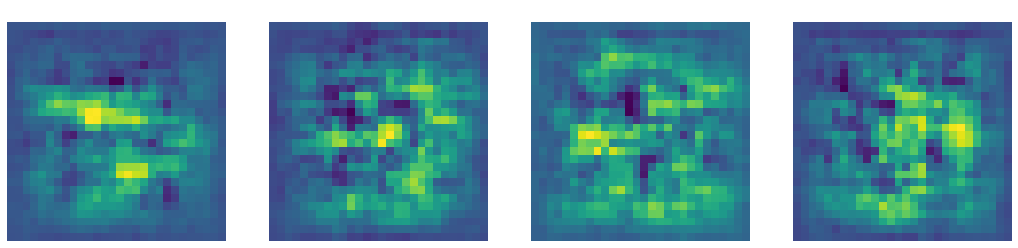

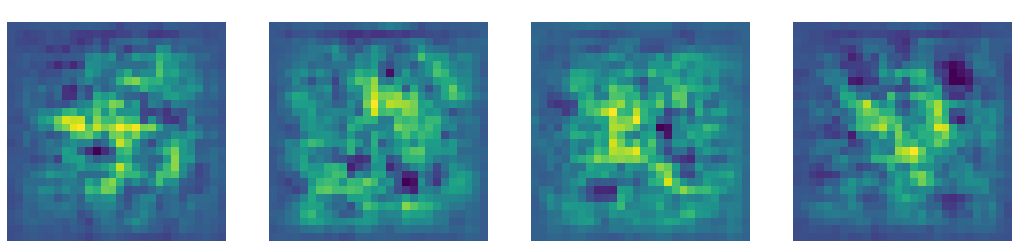

In [102]:
# Generating 64 samples from the untrained model
samples = model.sample(64)
display_images(None, samples,None, 'Generated Samples - Untrained Model', 64 // 4, count=True)

### 2.1.3. ELBO of samples from training set using the untrained model

In [103]:
# Compute the ELBO of 64 samples from the training set using the untrained model
with torch.no_grad():
  model.eval()
  # load a batch (it will be of 256 samples)
  images, full = next(iter(ds_train_loader))
  # we only want 64 samples
  only_64 = images[0:64, :, :,:]
  #full_64= full[0:64,:,:,:]
  # send them to the appropriate device
  only_64 = only_64.to(device)
  # forward
  x_hat, mu, logvar = model(only_64)
  # TODO: there is a miss-match in the dims but the size is the same
  elbo_64_untrained = loss_function(x_hat, only_64, mu, logvar).item()

print(f'ELBO of 64 samples using the untrained model: {elbo_64_untrained:.4f}')

ELBO of 64 samples using the untrained model: 33156.3711


## 2.2. Setting up the training

### 2.2.1. Implement train and test functions

In [104]:
# performs one epoch of training and returns the training loss for this epoch
def train():
  model.train()
  train_loss = 0
  for imgs, mask in ds_train_loader:
    imgs = imgs.to(device)
    mask = mask.to(device)
    # ===================forward=====================
    masked = torch.where(mask,imgs,torch.zeros((256,1,28,28)).to(device))
    out, mu, logvar = model(masked)
    out_masked = torch.where(mask,out,torch.zeros((256,1,28,28)).to(device))
    loss = loss_function(out_masked, masked, mu, logvar)
    train_loss += loss.item()
    # ===================backward====================
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  return train_loss

# evaluates the model on the test set
def test(epoch):
  means, logvars, labels, images = list(), list(), list(), list()
  test_loss = 0
  with torch.no_grad():
    model.eval()
    for x, y in ds_test_loader:
      y = y.to(device)
      x = x.to(device)
      # forward
      t_in_masked=torch.where(y,x,torch.zeros((256,1,28,28)).to(device))
      x_hat, mu, logvar = model(t_in_masked)
      t_xh_masked=torch.where(y,x_hat,torch.zeros((256,1,28,28)).to(device))
      test_loss += loss_function(t_xh_masked, t_in_masked, mu, logvar).item()
      # log
      means.append(mu.detach())
      logvars.append(logvar.detach())
      labels.append(y.detach())
      images.append(x.detach())
  display_images(t_in_masked,x, x_hat,f'Epoch {epoch} - Reconstructed Images', 1)
  return test_loss, means, logvars, labels, images

### 2.2.2. Train the model and Evaluate on the testset

====> Epoch: 1 Average train loss: 117.9930
====> Epoch: 1 Average test loss: 106.4780
====> Epoch: 2 Average train loss: 106.5478
====> Epoch: 2 Average test loss: 90.2661
====> Epoch: 3 Average train loss: 86.6523
====> Epoch: 3 Average test loss: 66.9023
====> Epoch: 4 Average train loss: 79.1820
====> Epoch: 4 Average test loss: 64.6887
====> Epoch: 5 Average train loss: 77.0206
====> Epoch: 5 Average test loss: 62.8976
====> Epoch: 6 Average train loss: 75.3421
====> Epoch: 6 Average test loss: 60.4692
====> Epoch: 7 Average train loss: 73.5457
====> Epoch: 7 Average test loss: 59.9623


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


====> Epoch: 8 Average train loss: 72.0389


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


====> Epoch: 8 Average test loss: 58.3566
====> Epoch: 9 Average train loss: 70.7351
====> Epoch: 9 Average test loss: 57.7088
====> Epoch: 10 Average train loss: 69.2414
====> Epoch: 10 Average test loss: 57.2135
====> Epoch: 11 Average train loss: 67.7867
====> Epoch: 11 Average test loss: 56.4400
====> Epoch: 12 Average train loss: 66.5337
====> Epoch: 12 Average test loss: 56.9272
====> Epoch: 13 Average train loss: 65.5894
====> Epoch: 13 Average test loss: 55.6460
====> Epoch: 14 Average train loss: 64.8087
====> Epoch: 14 Average test loss: 54.4617
====> Epoch: 15 Average train loss: 64.1846
====> Epoch: 15 Average test loss: 53.4660
====> Epoch: 16 Average train loss: 63.6304
====> Epoch: 16 Average test loss: 55.7913
====> Epoch: 17 Average train loss: 63.2350
====> Epoch: 17 Average test loss: 54.4645
====> Epoch: 18 Average train loss: 62.8242
====> Epoch: 18 Average test loss: 54.9592
====> Epoch: 19 Average train loss: 62.4642
====> Epoch: 19 Average test loss: 53.9030
===

RuntimeError: ignored

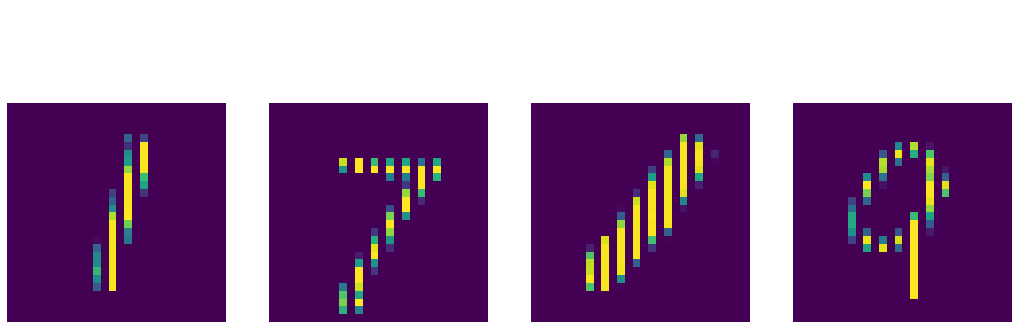

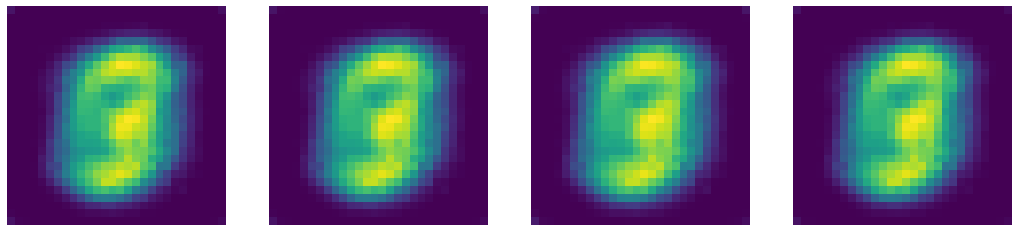

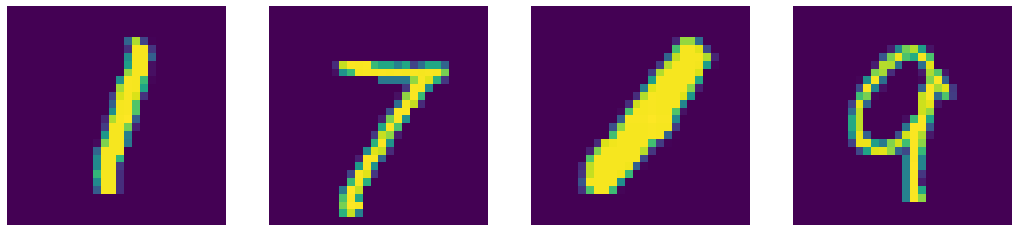

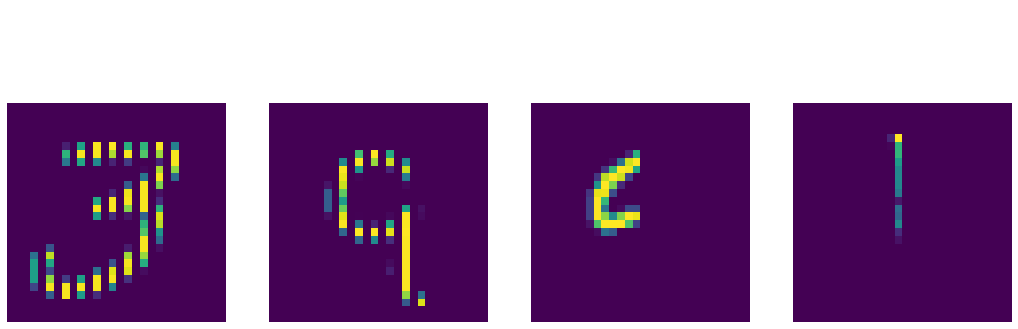

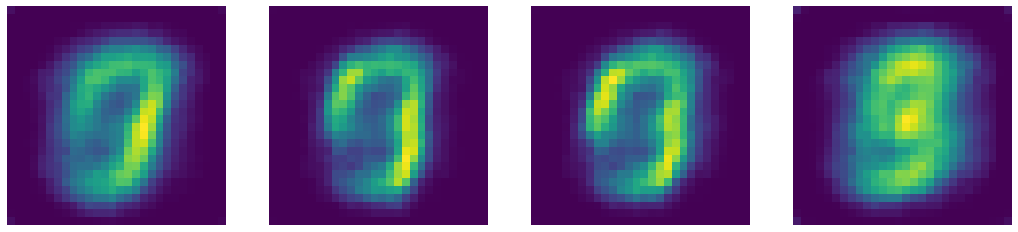

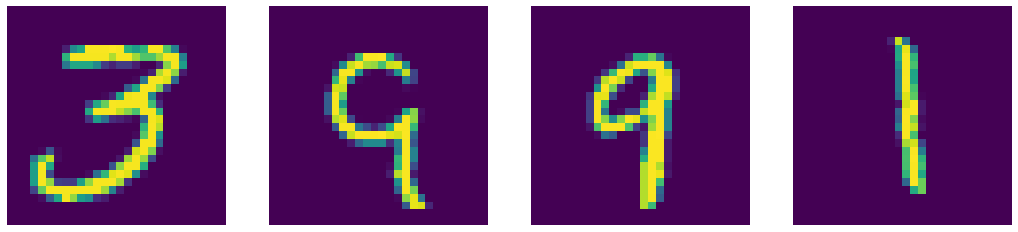

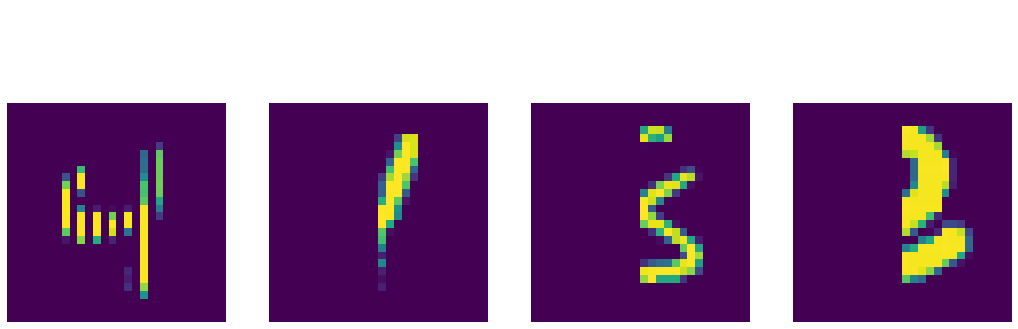

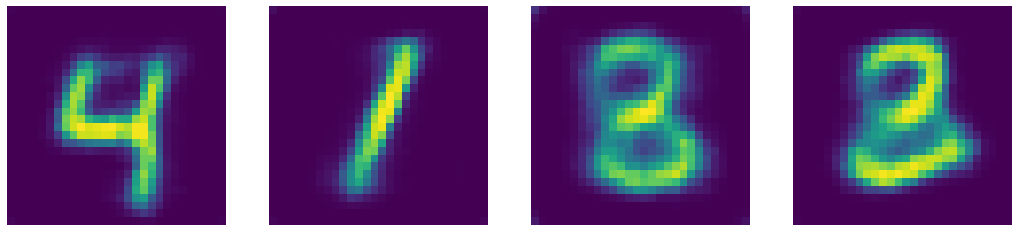

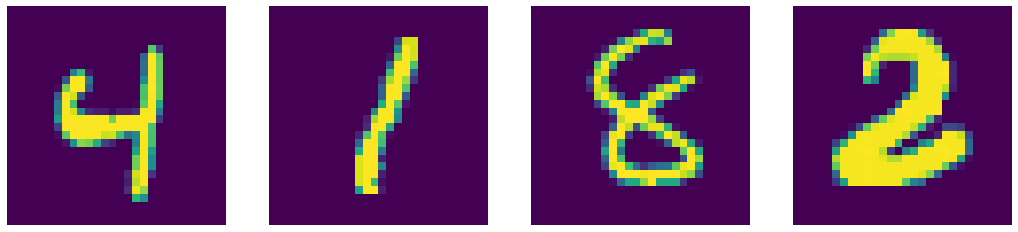

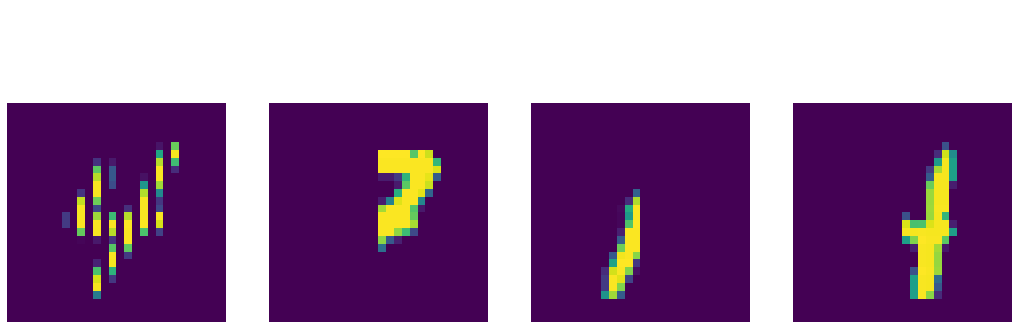

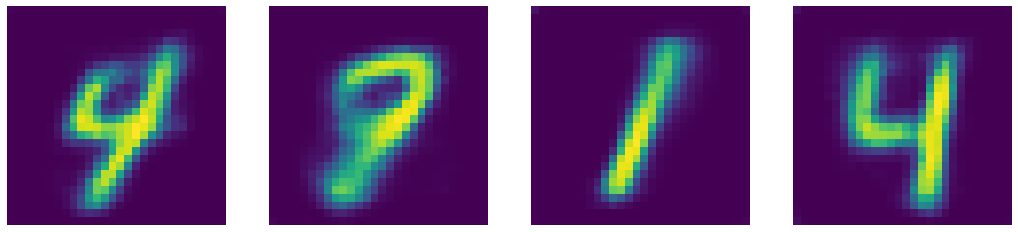

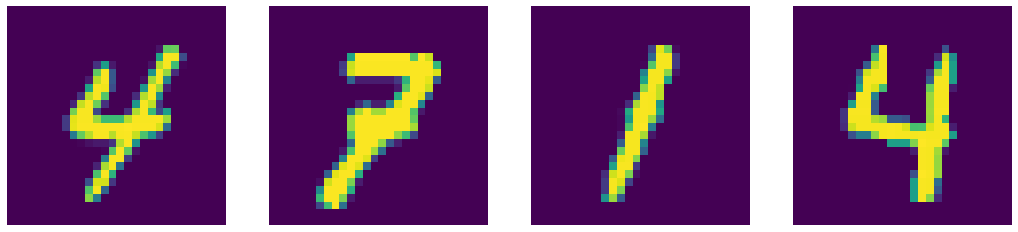

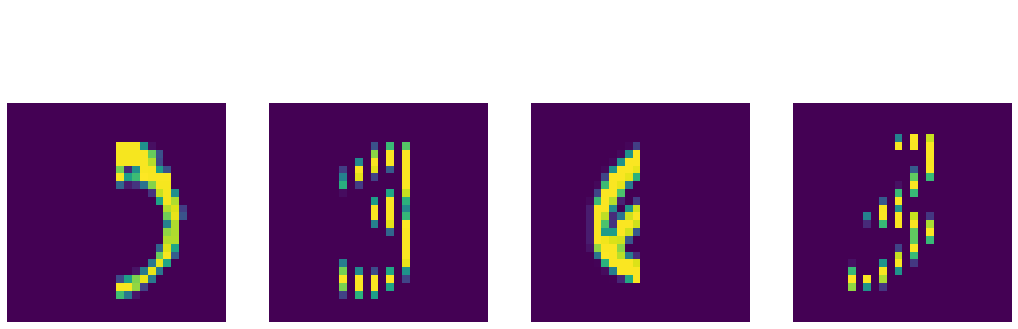

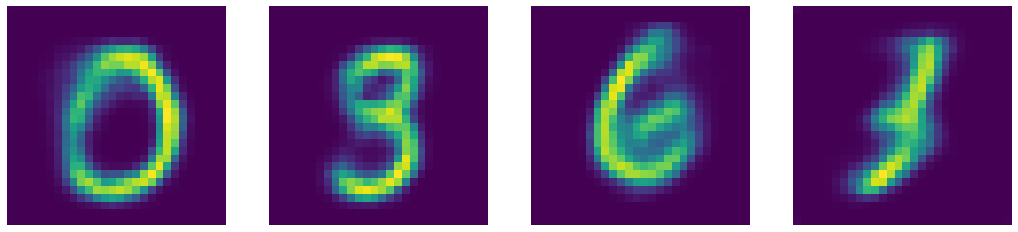

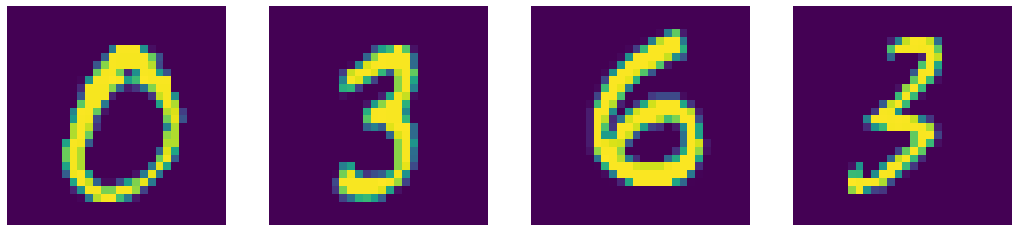

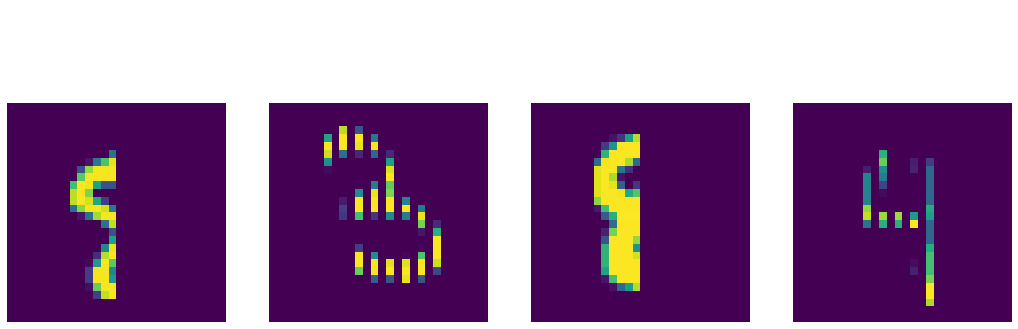

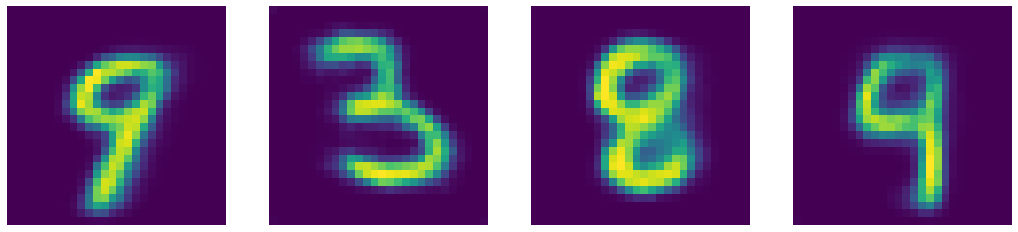

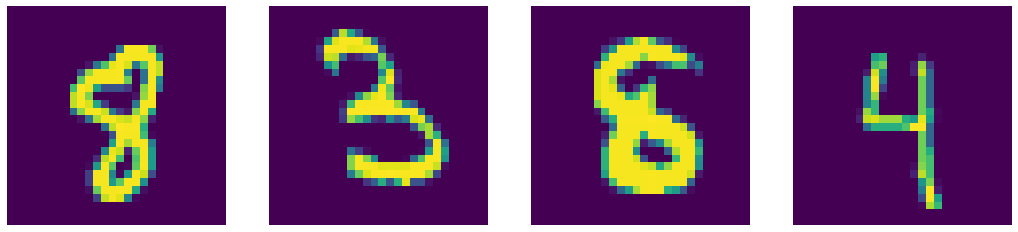

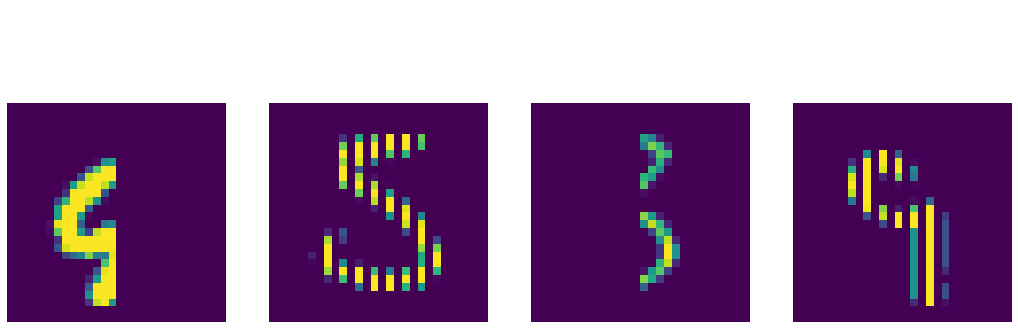

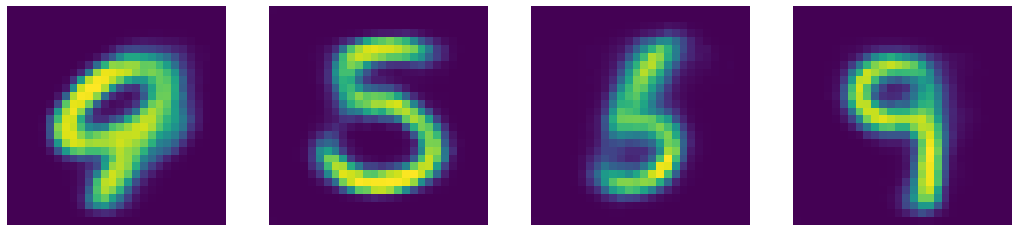

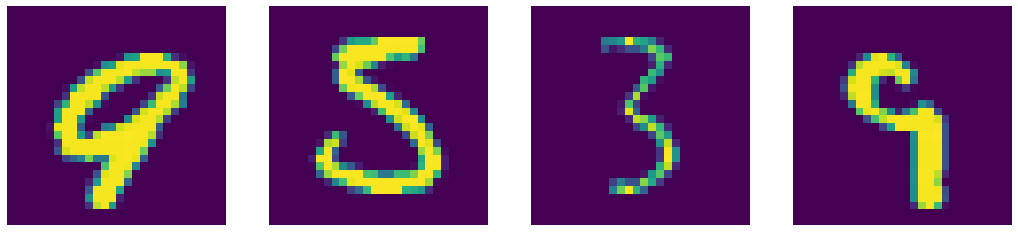

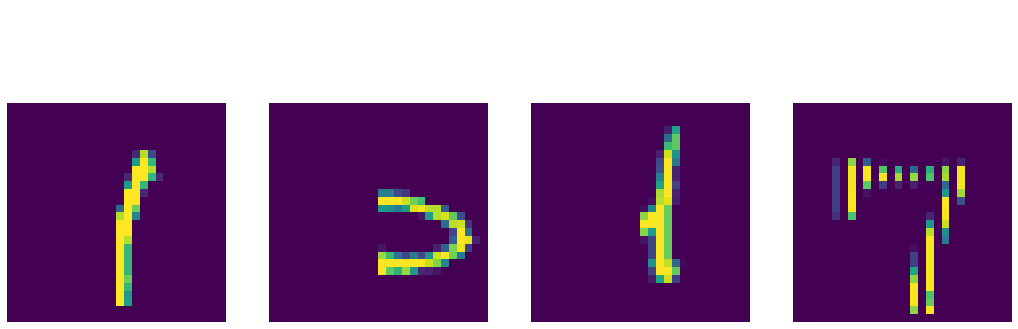

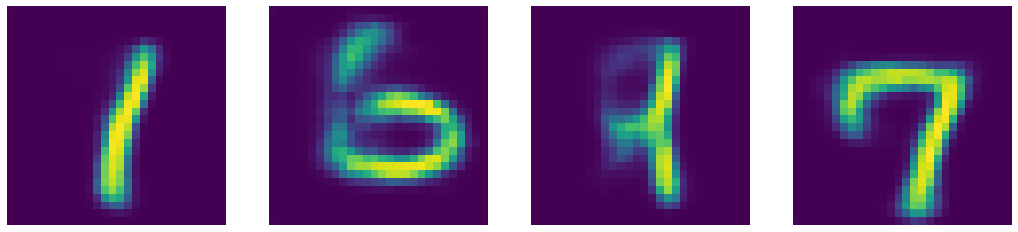

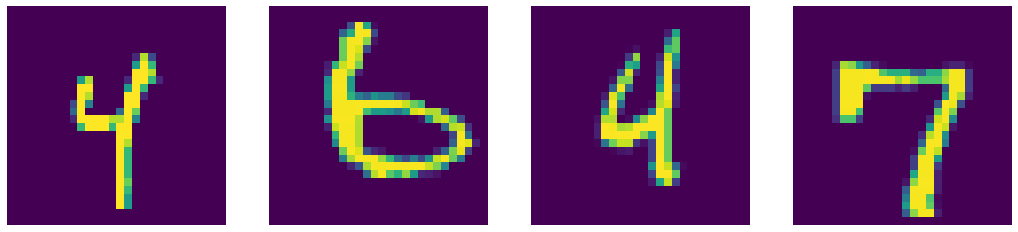

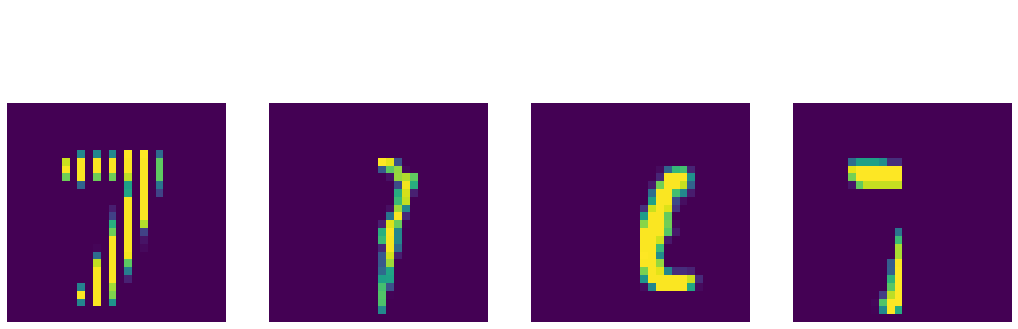

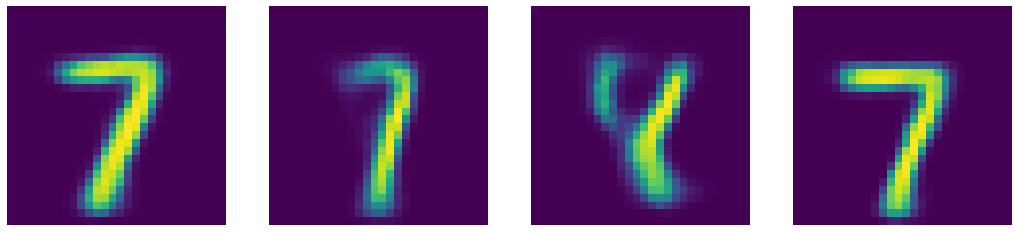

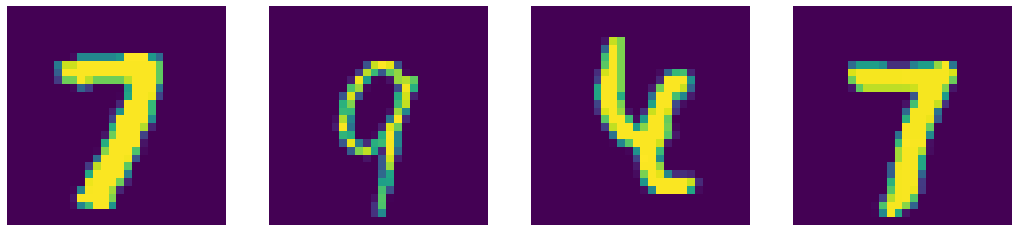

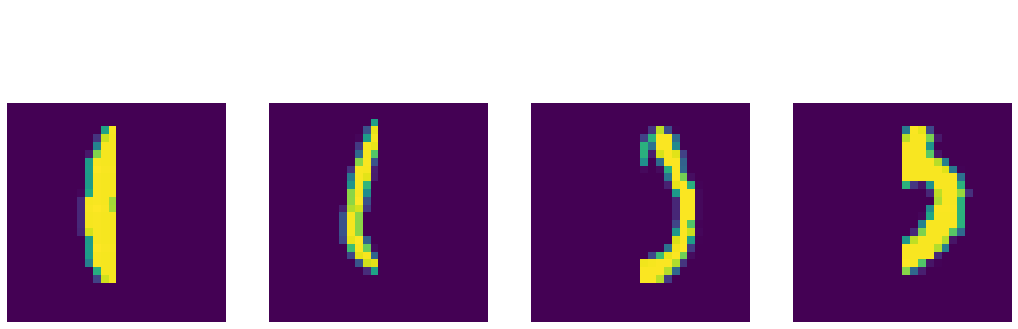

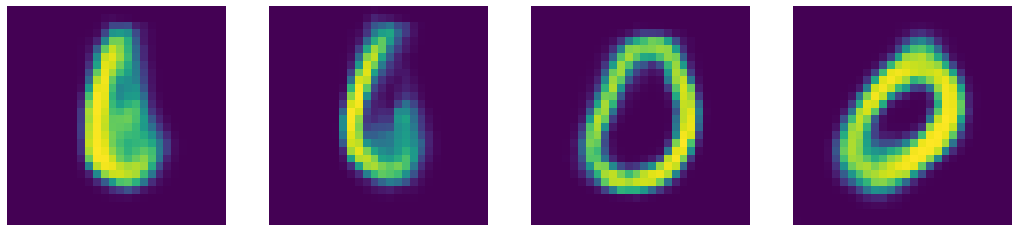

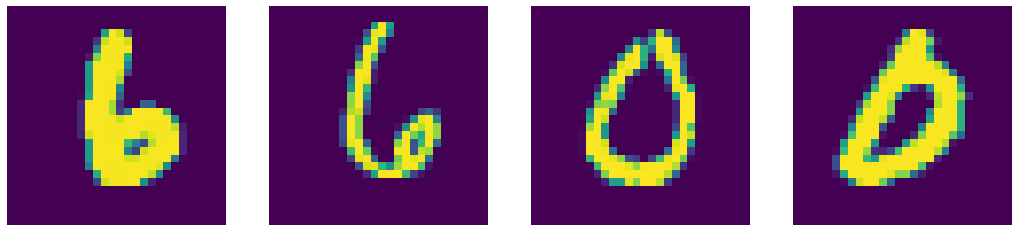

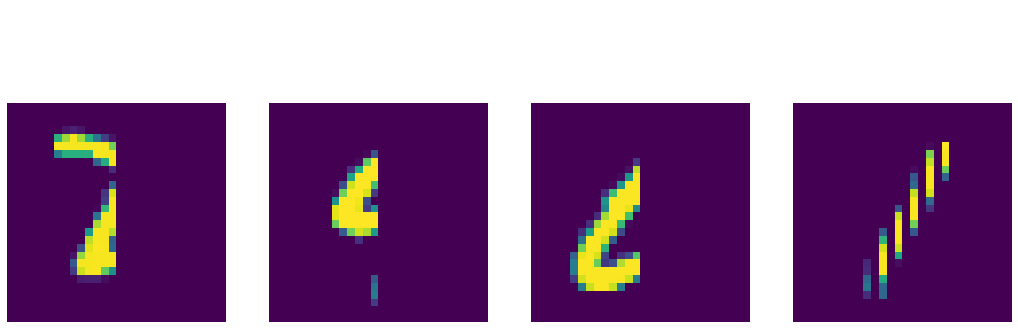

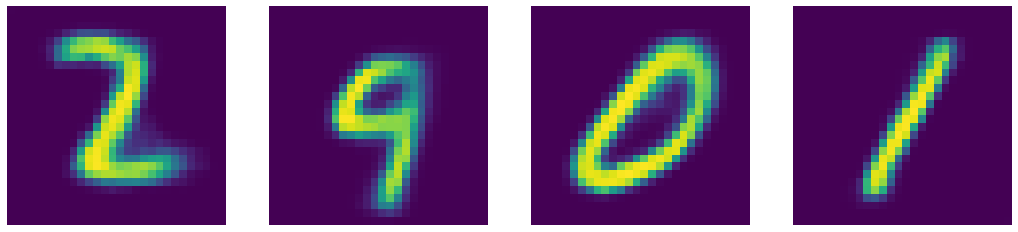

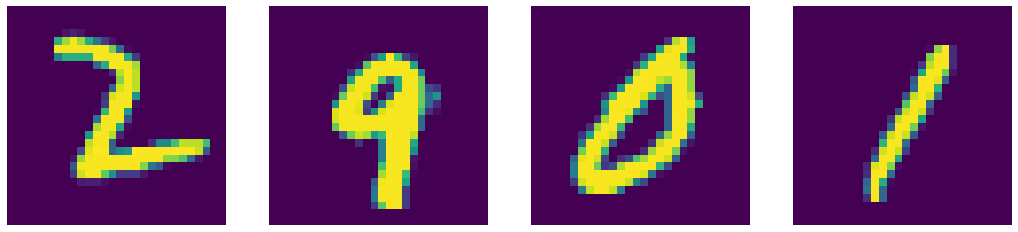

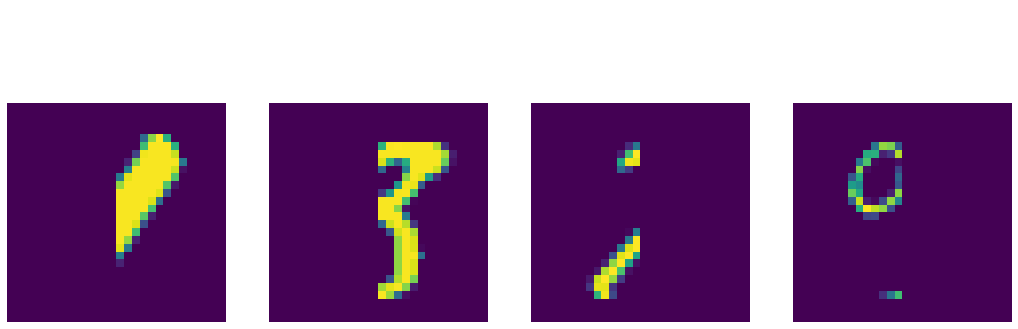

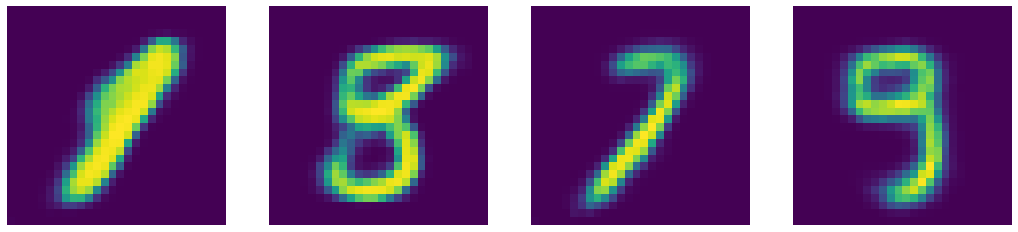

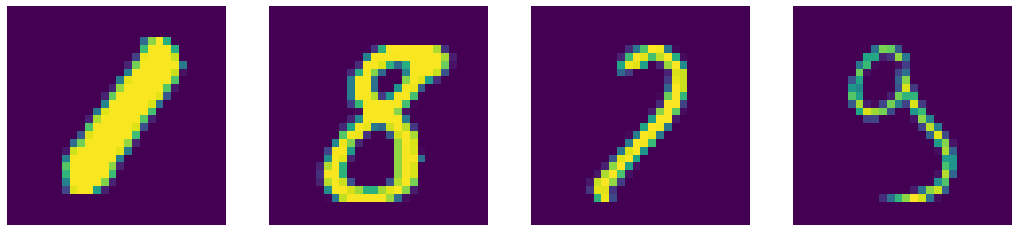

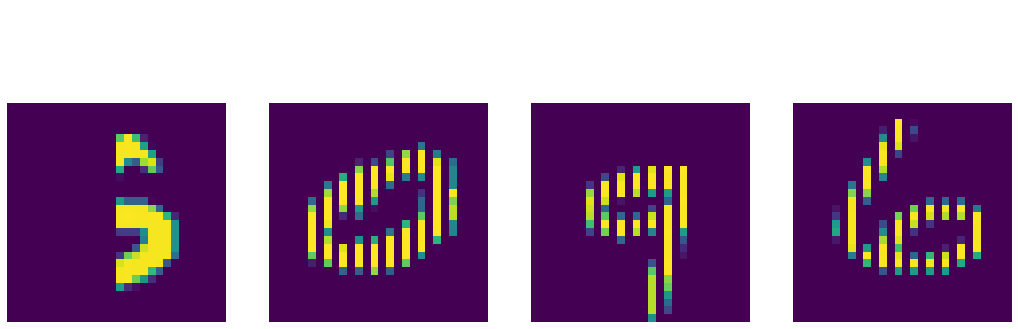

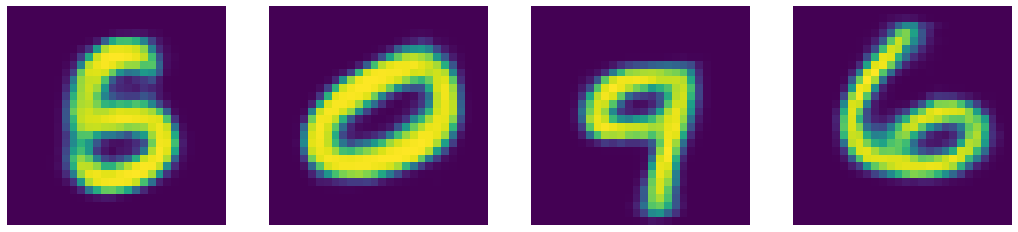

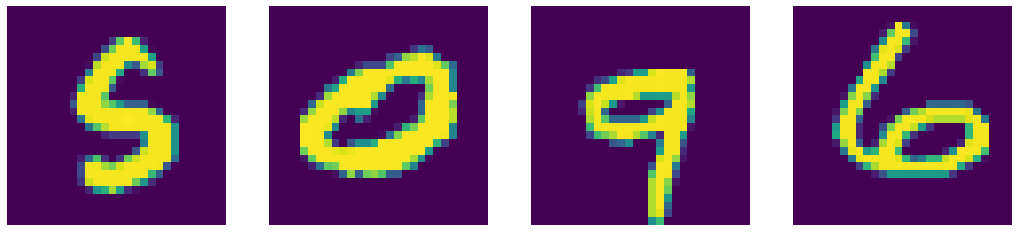

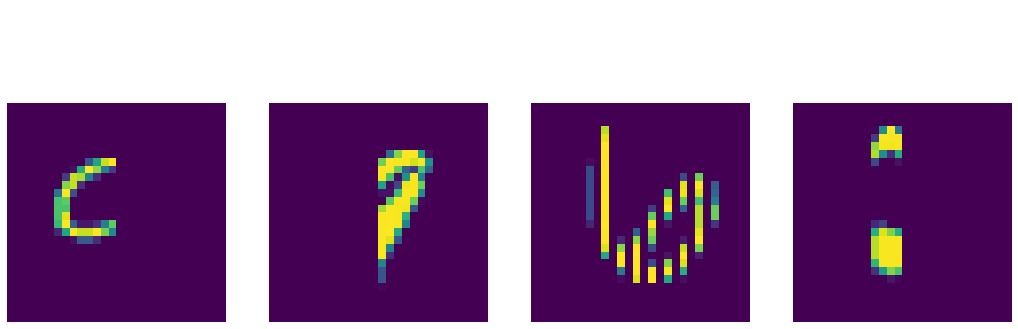

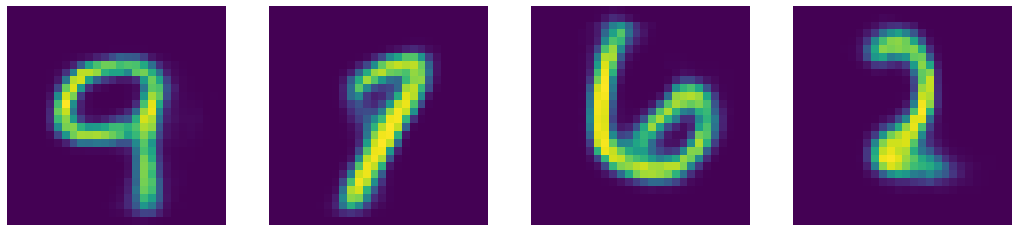

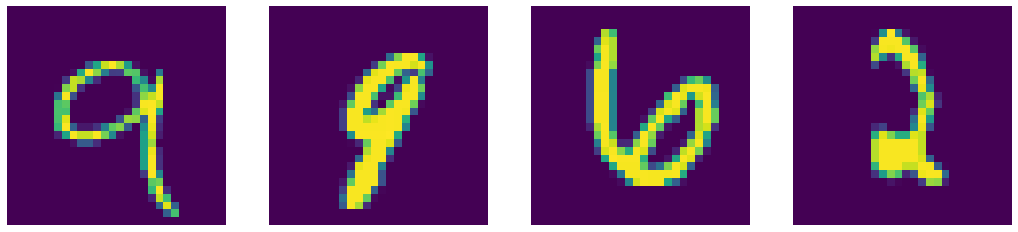

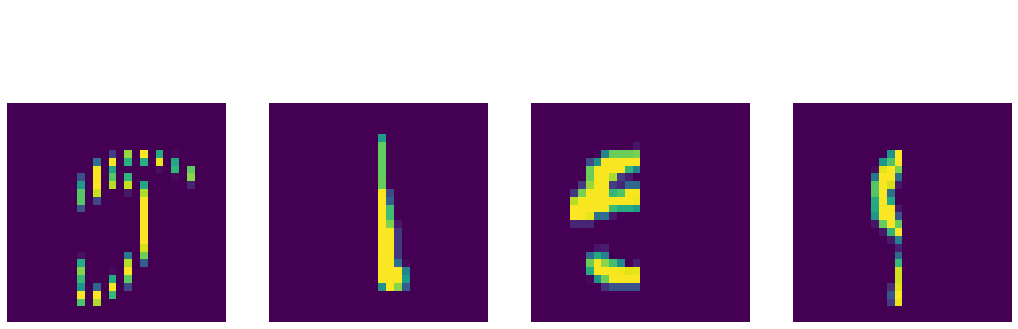

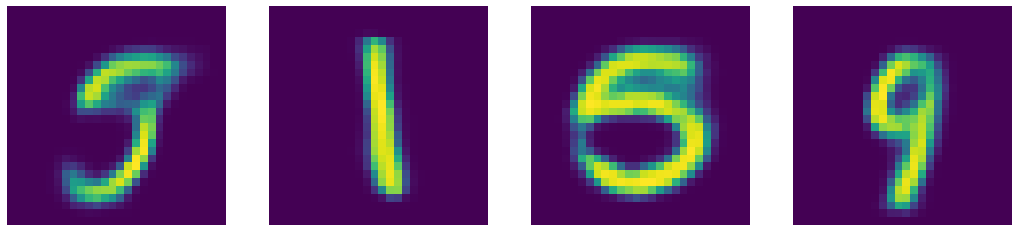

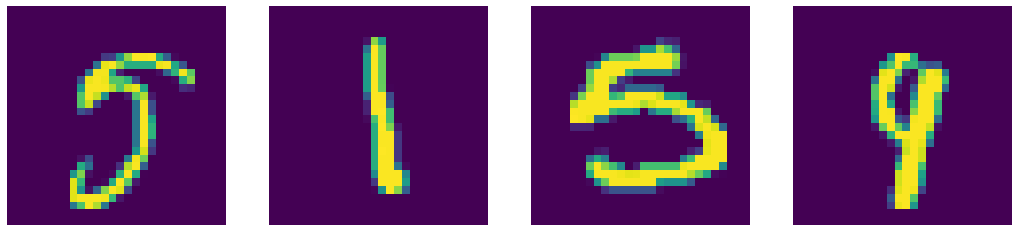

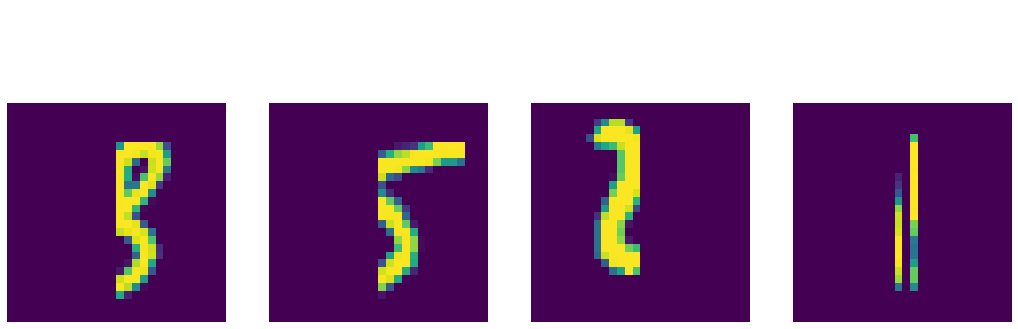

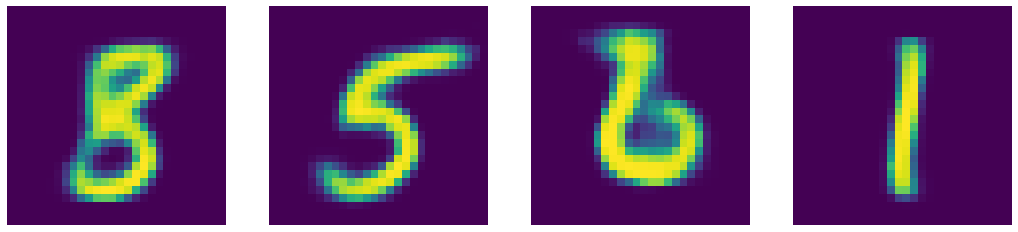

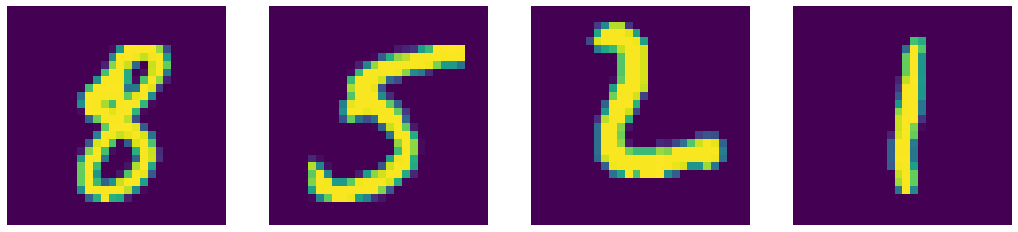

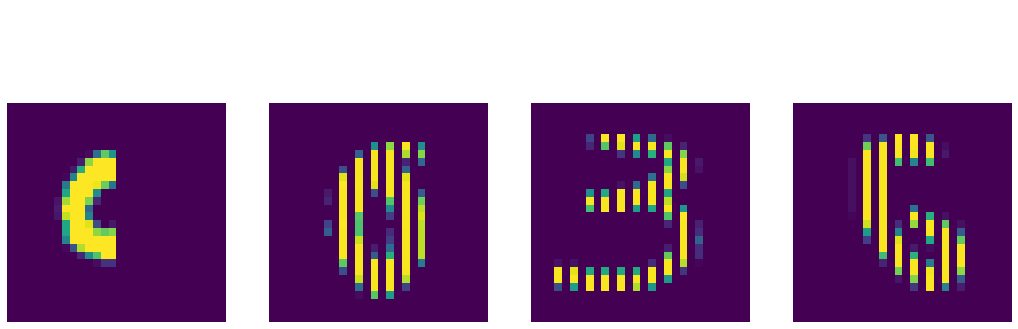

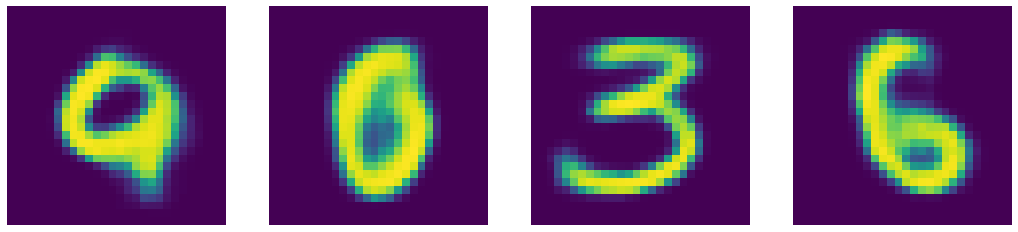

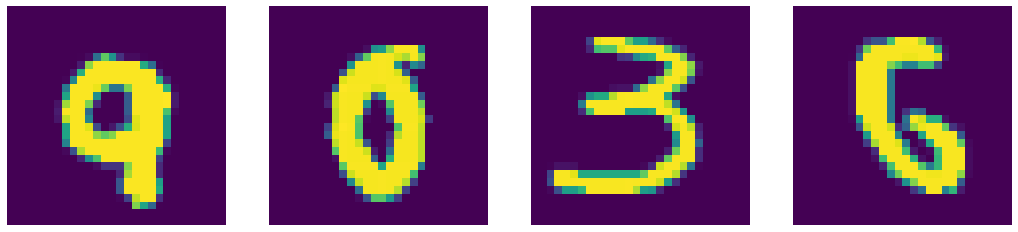

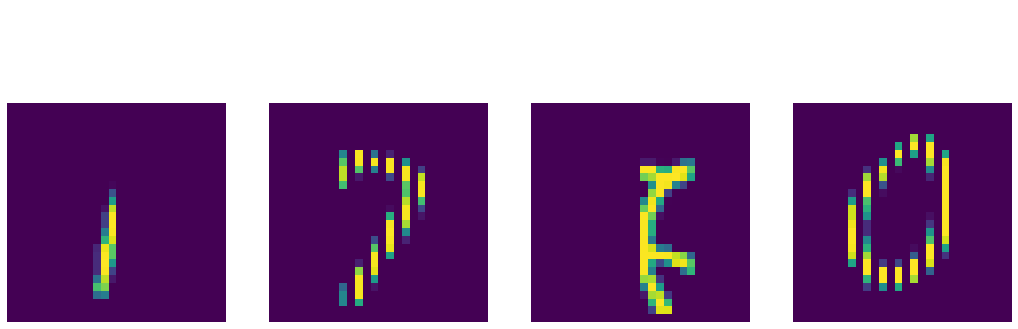

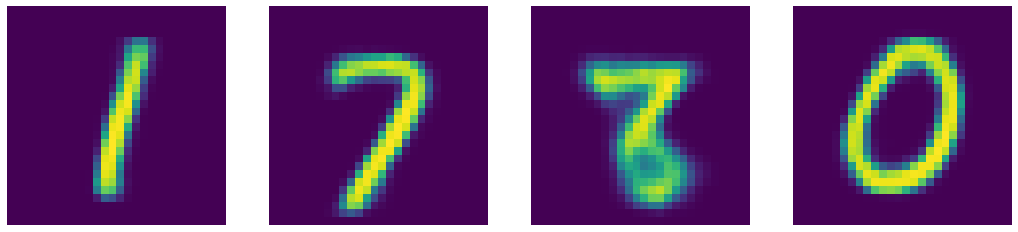

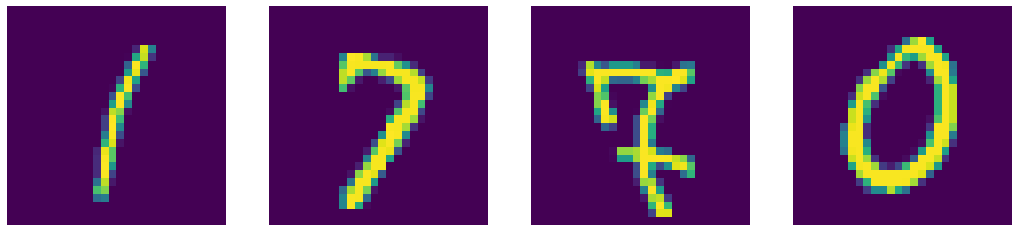

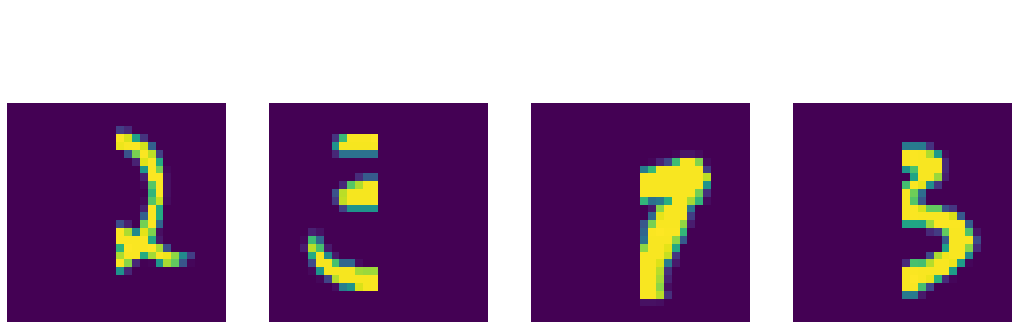

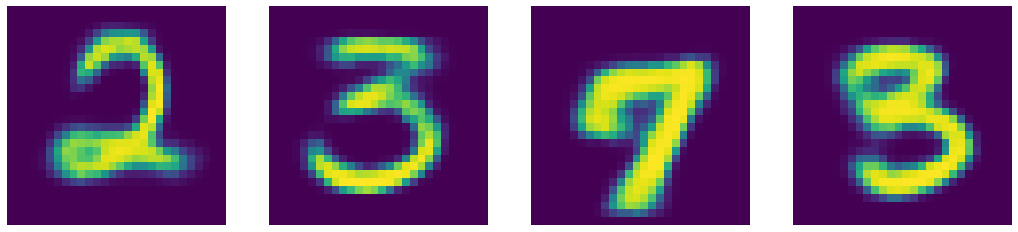

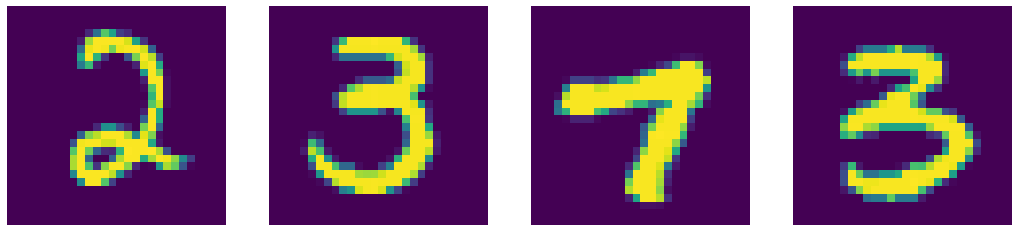

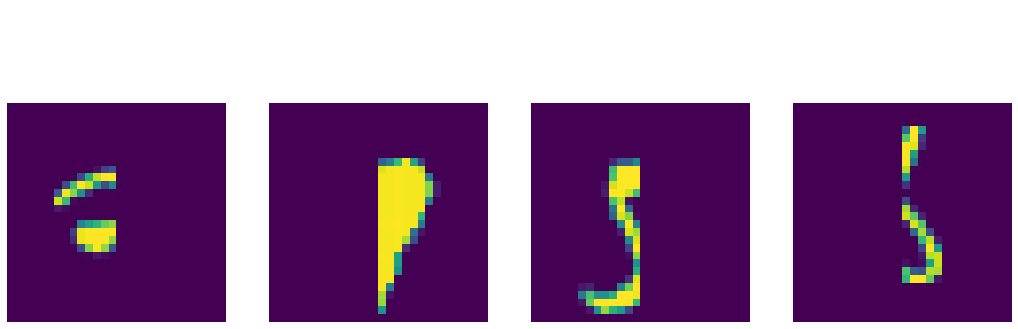

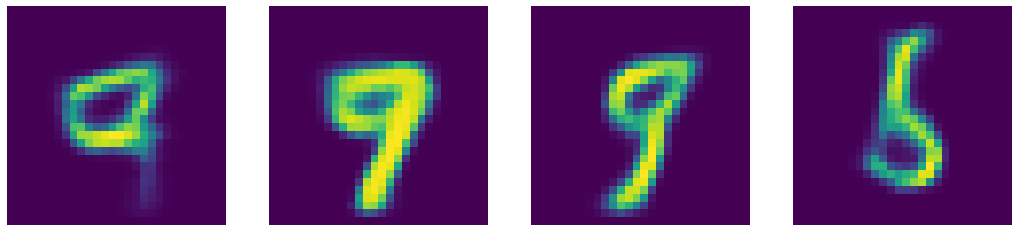

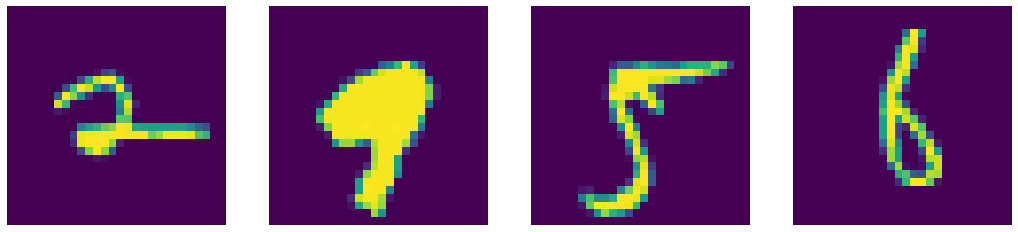

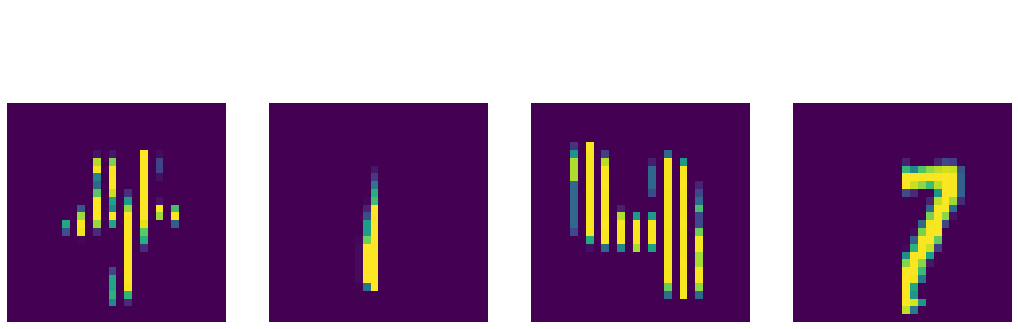

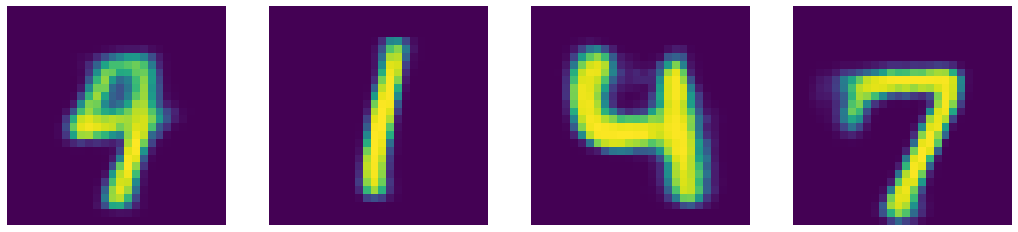

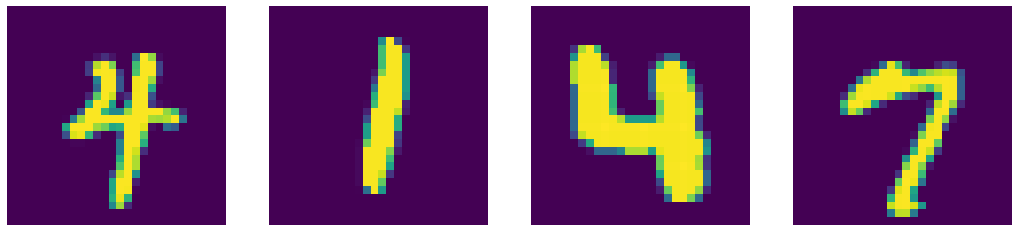

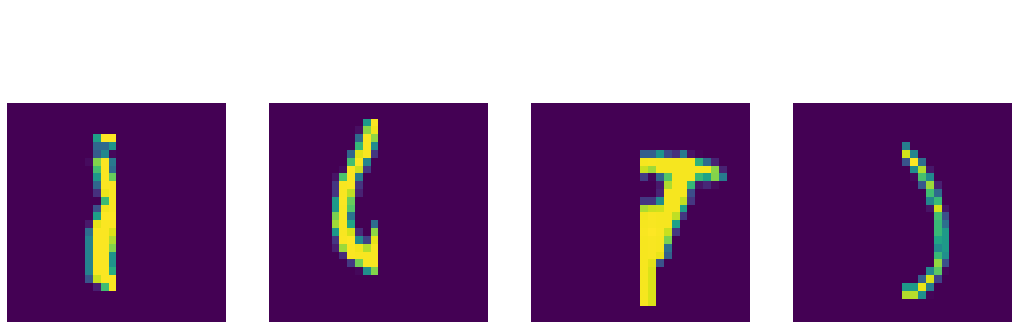

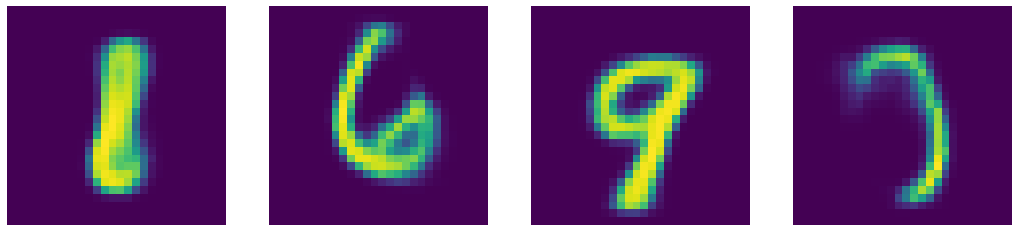

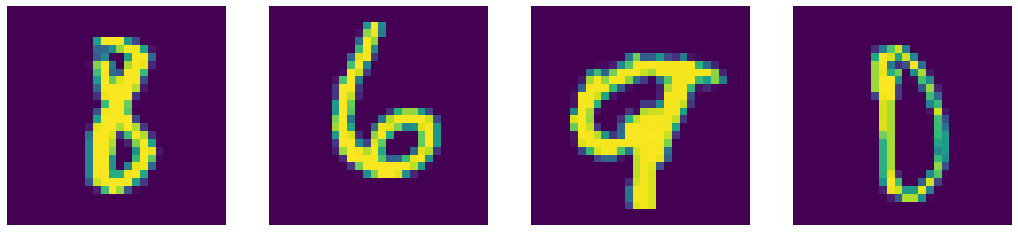

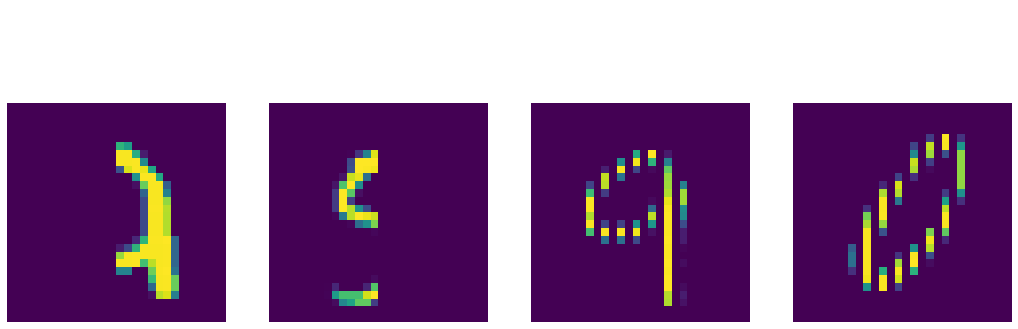

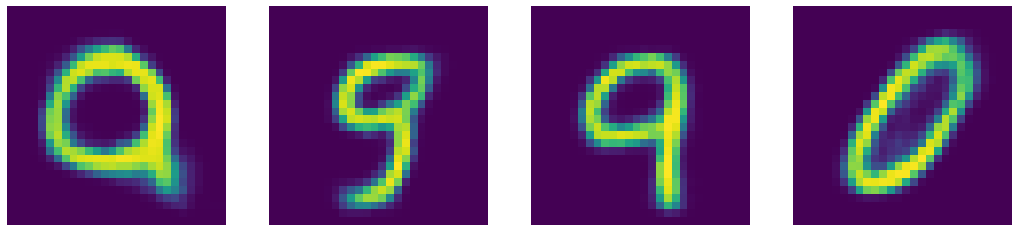

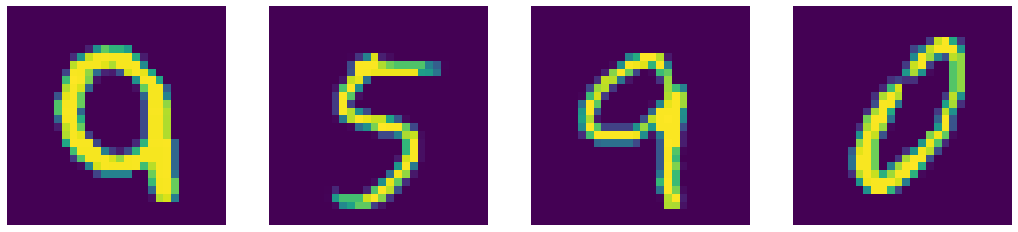

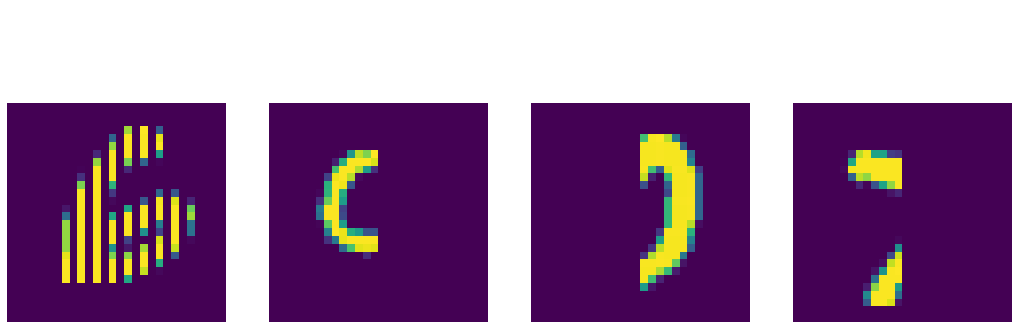

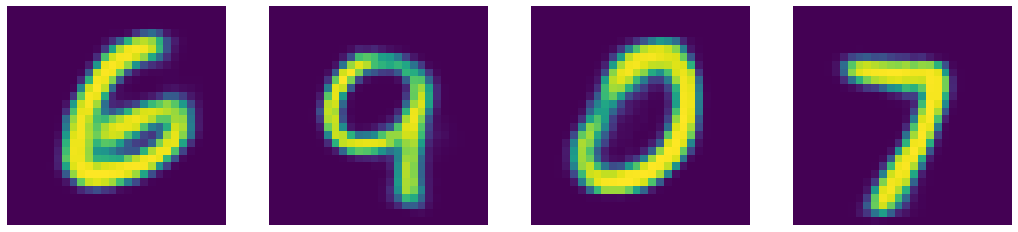

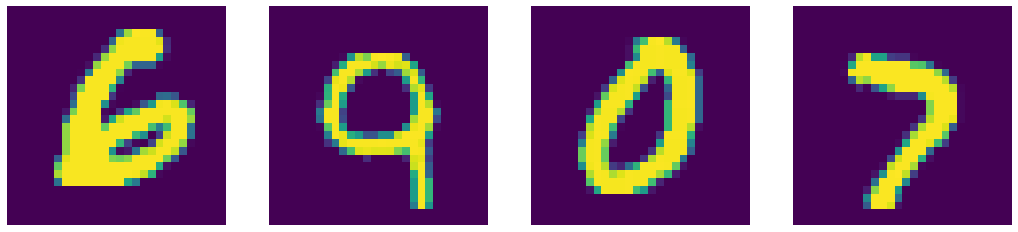

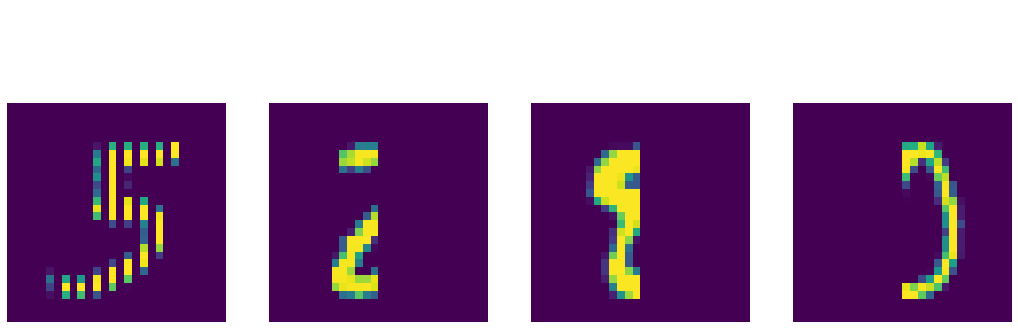

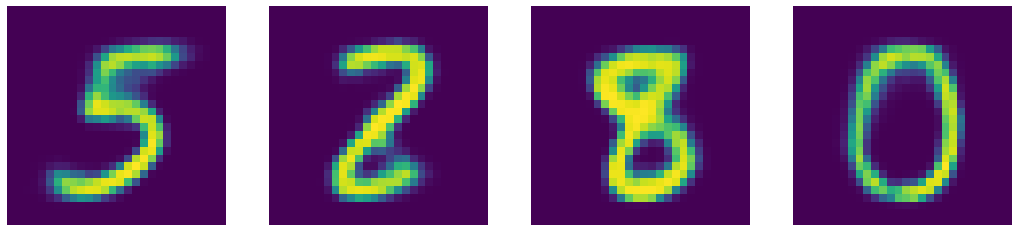

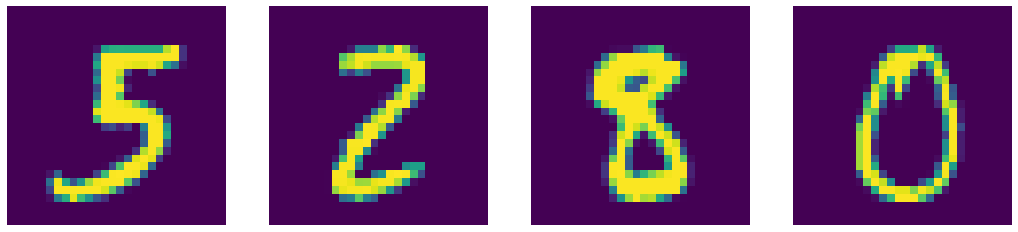

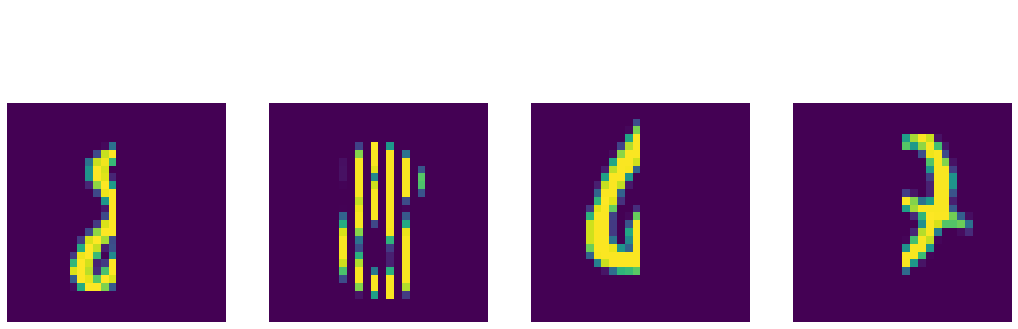

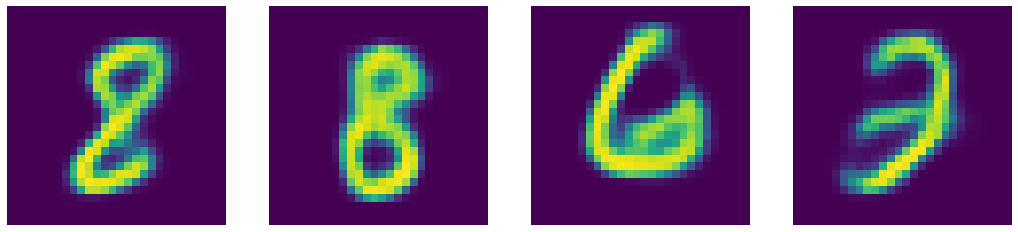

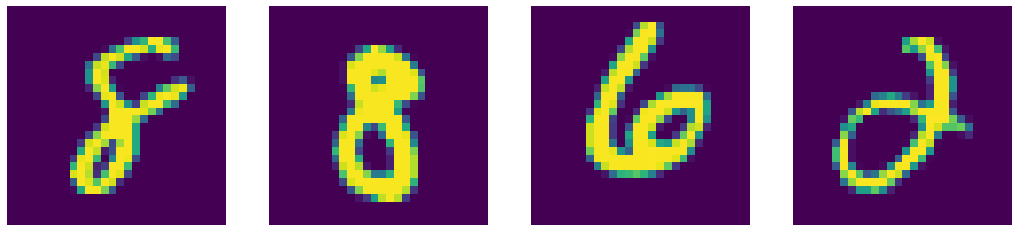

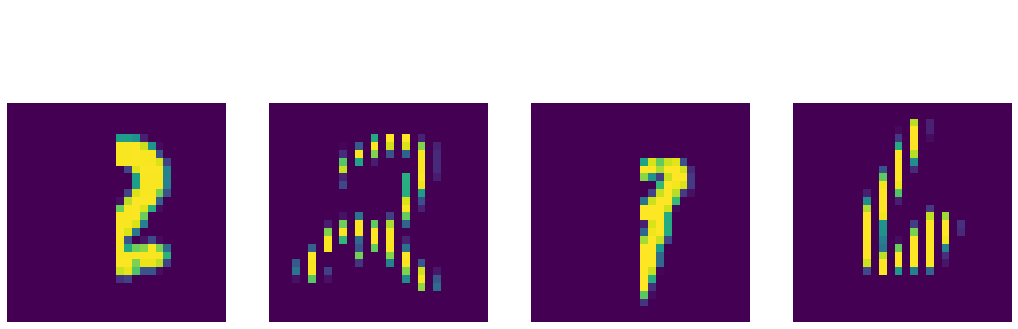

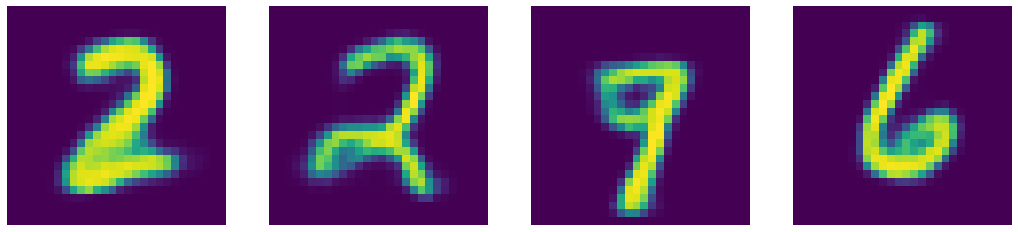

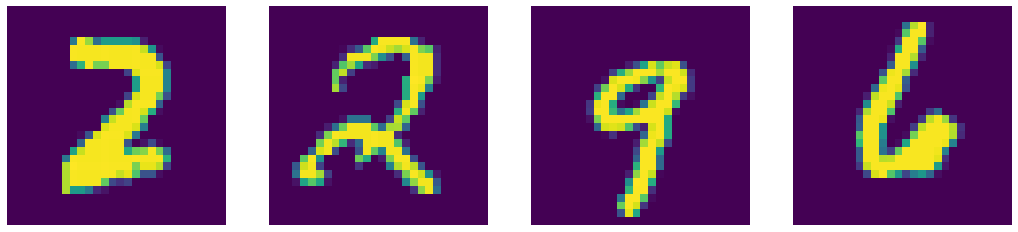

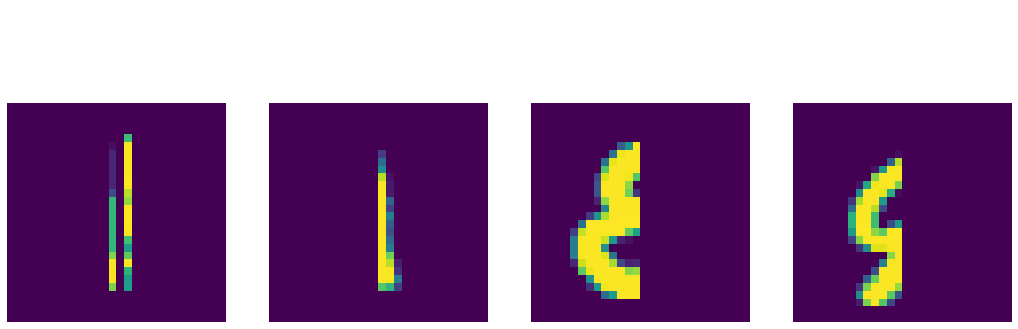

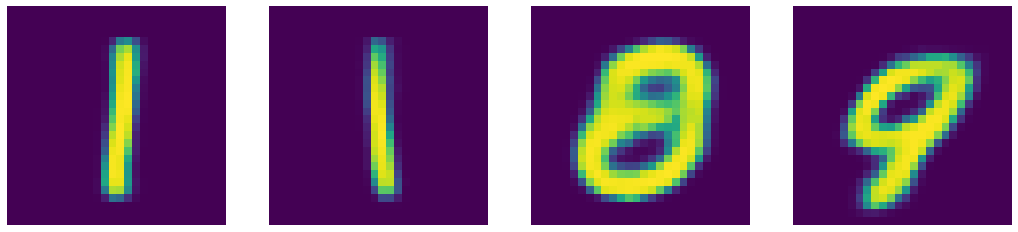

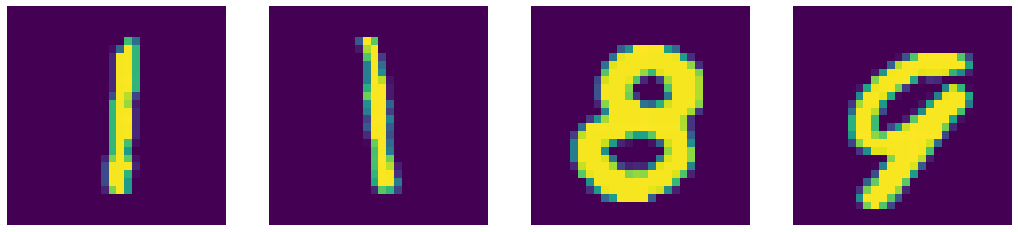

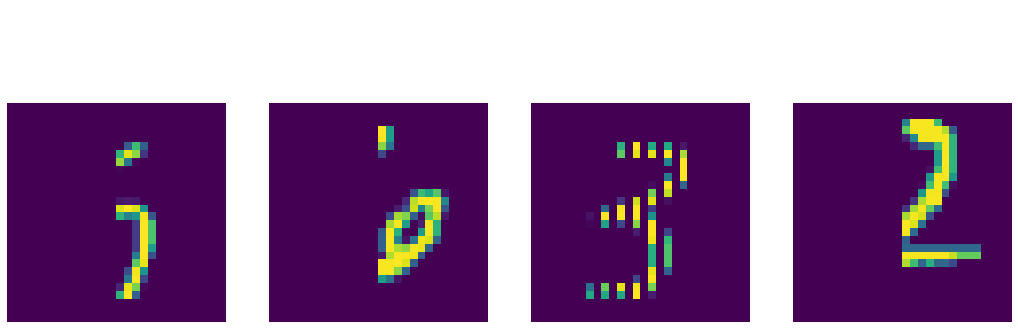

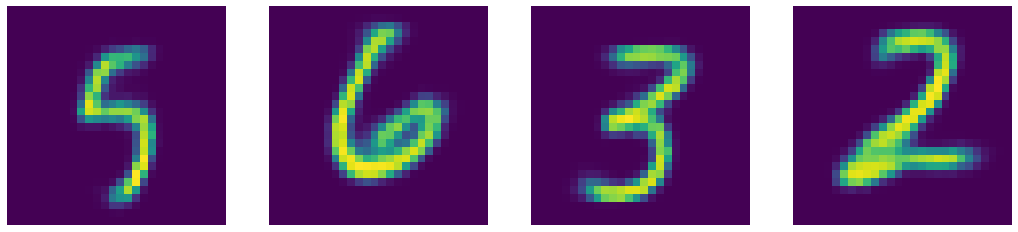

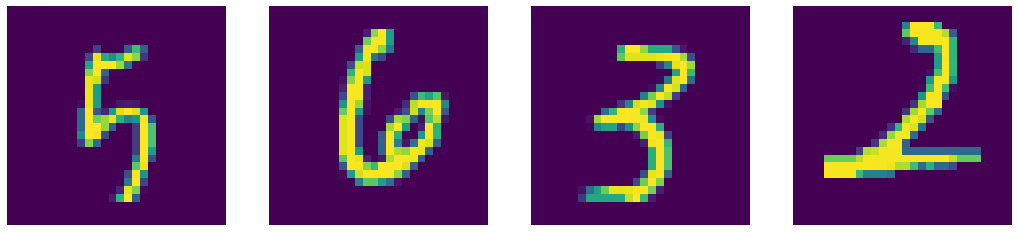

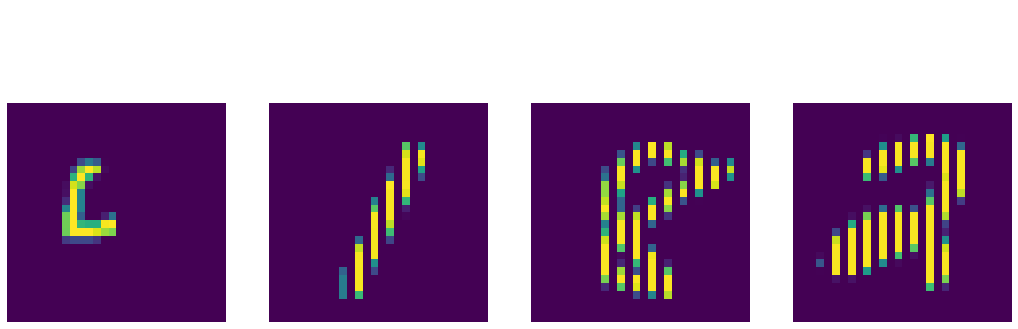

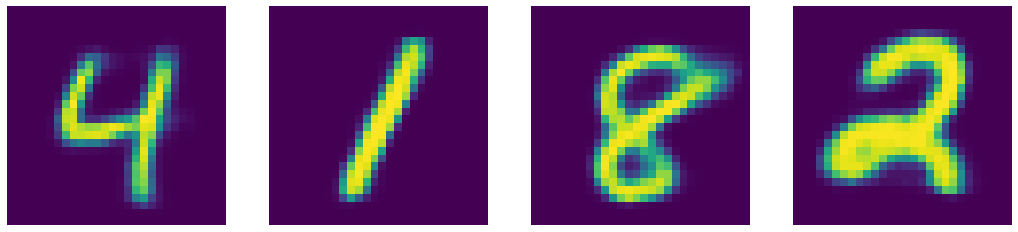

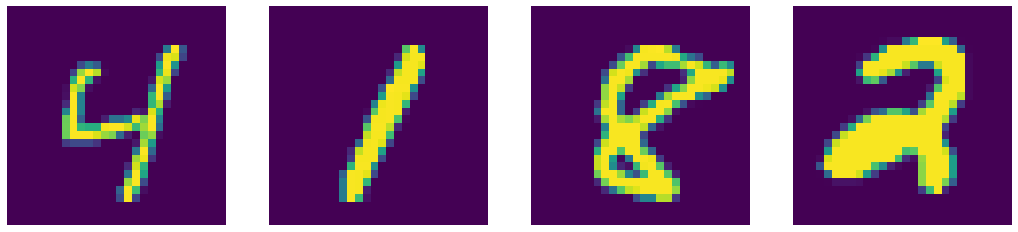

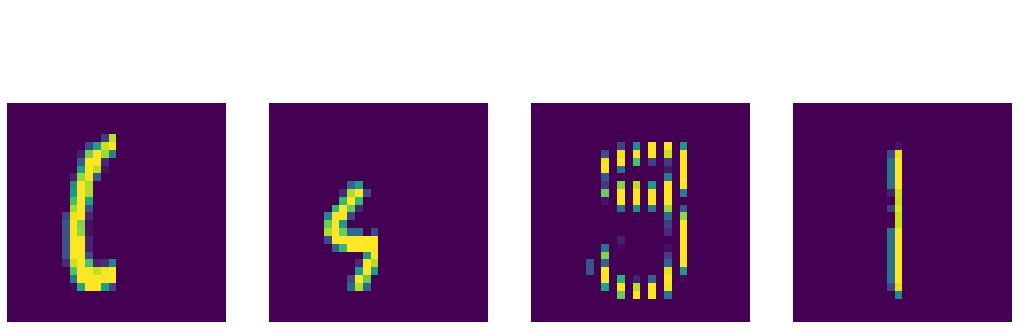

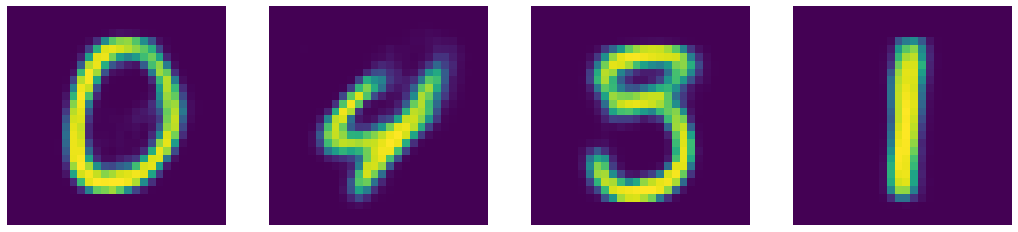

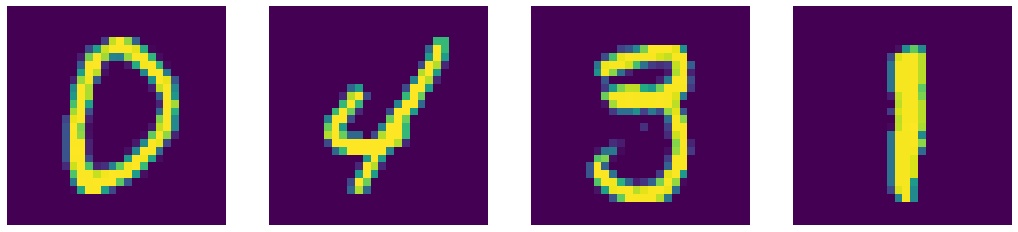

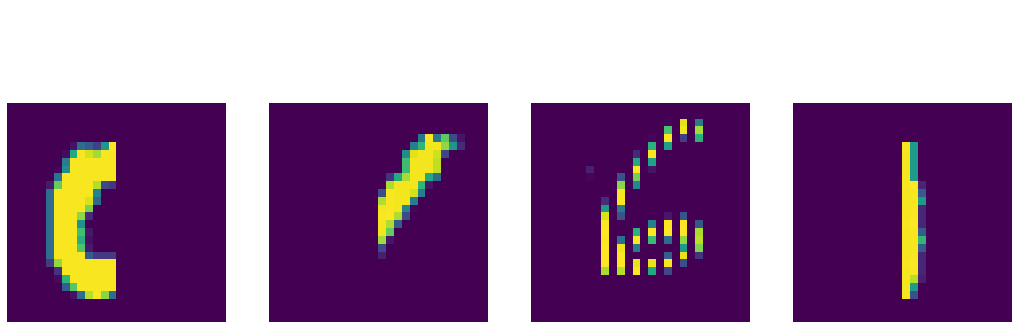

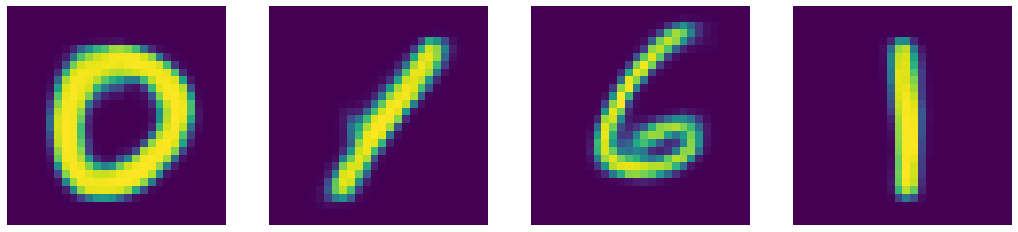

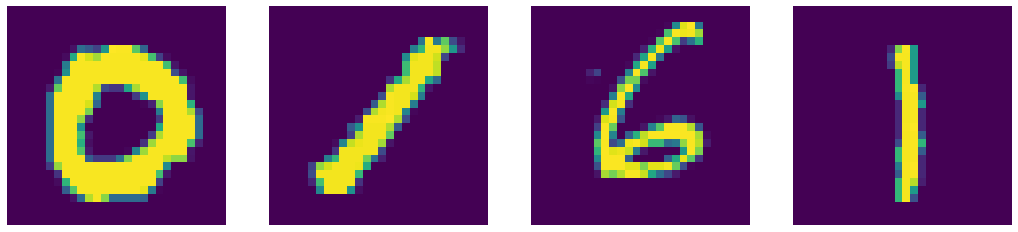

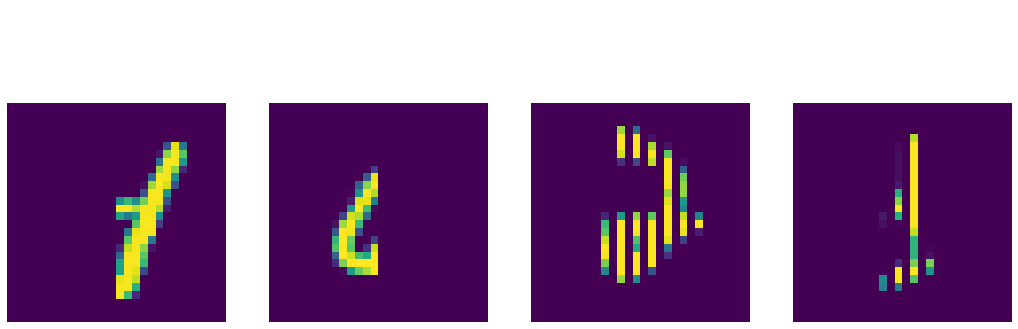

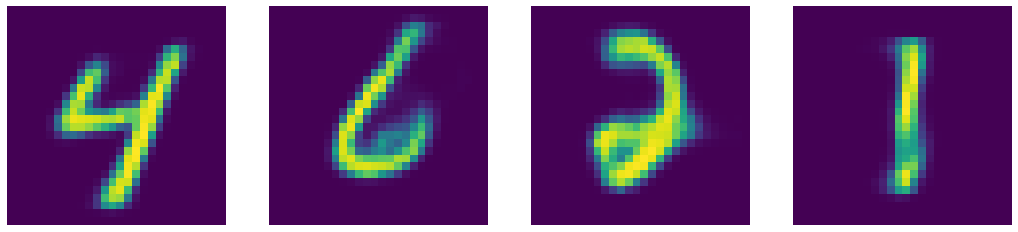

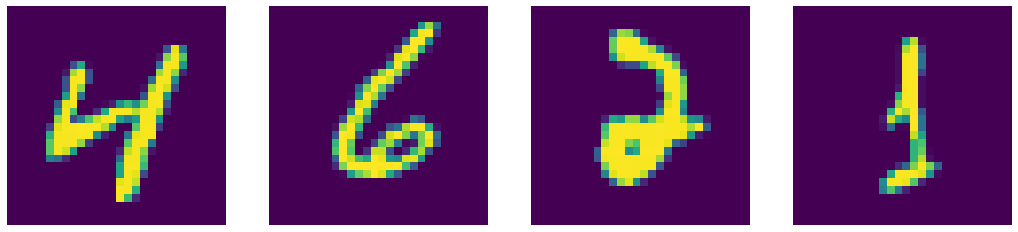

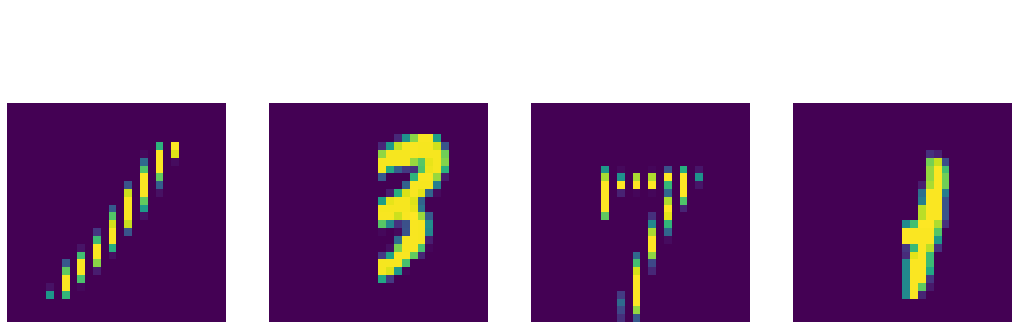

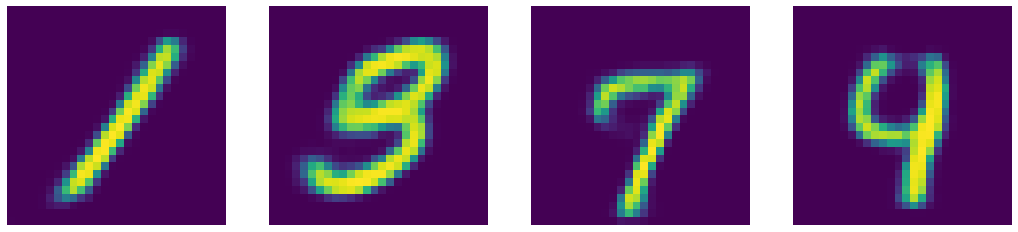

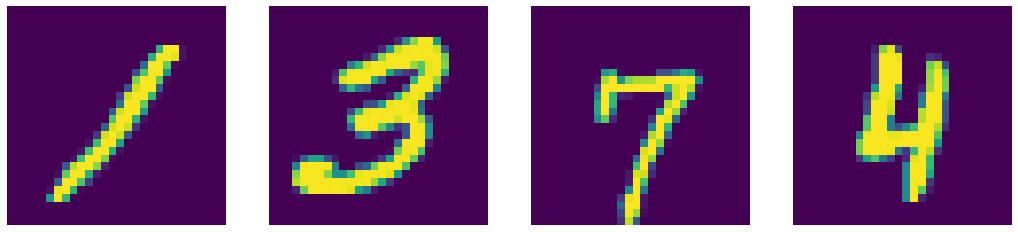

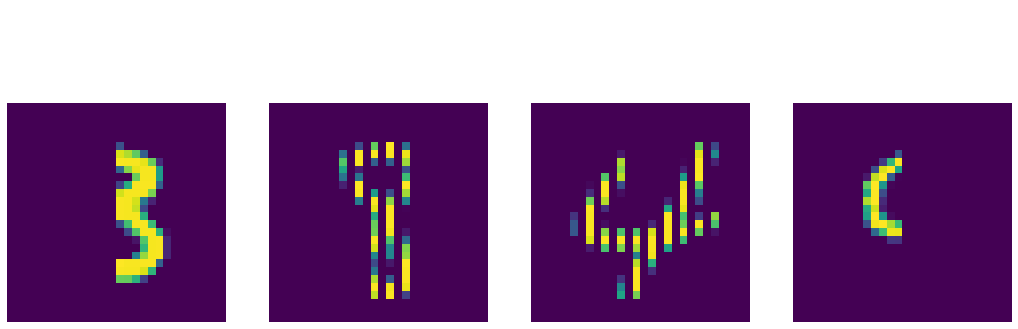

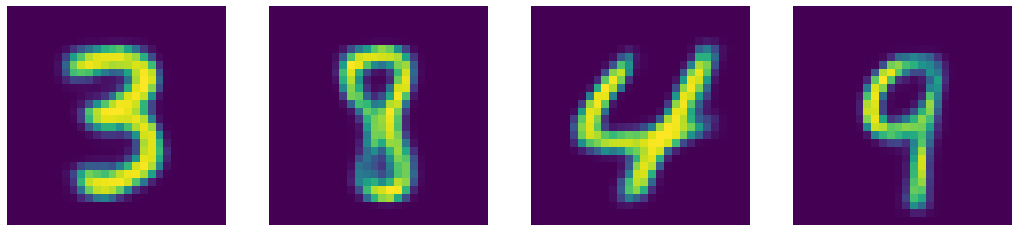

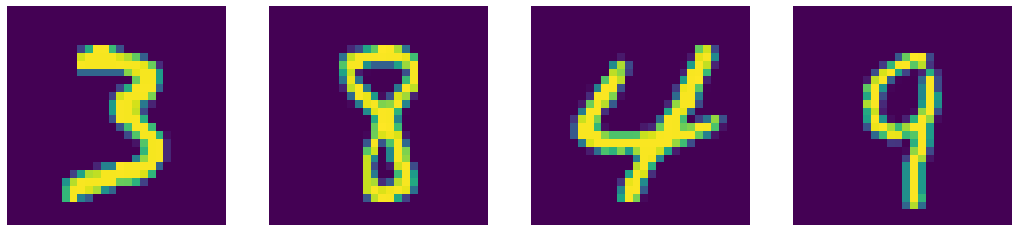

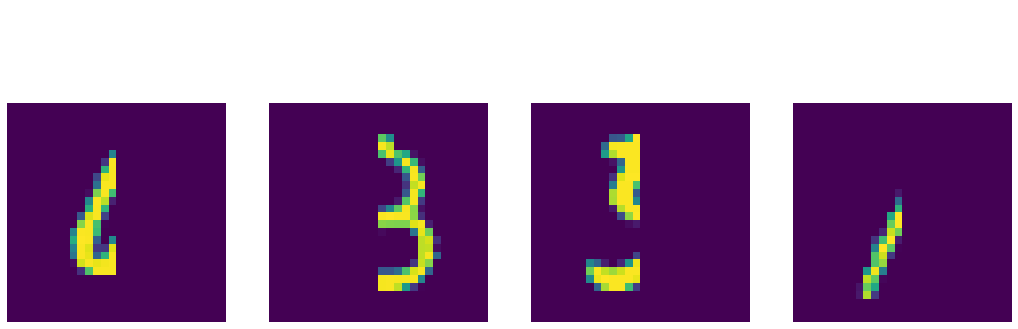

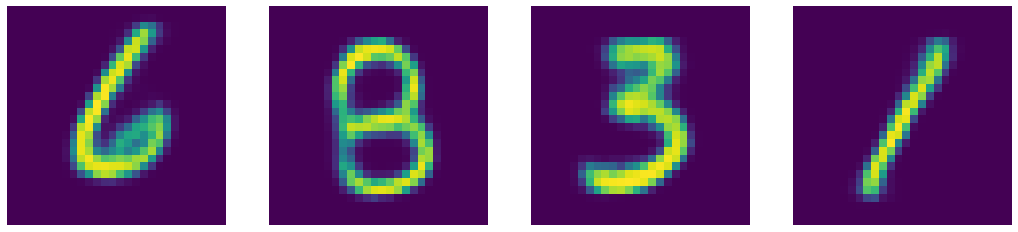

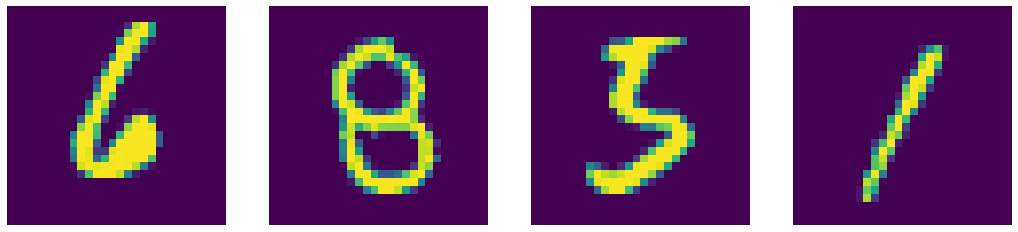

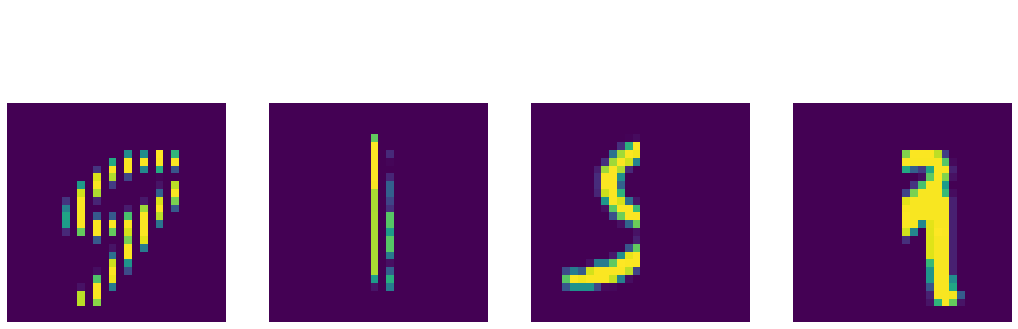

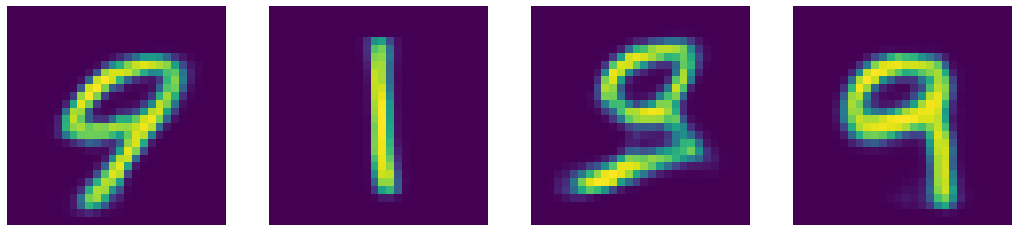

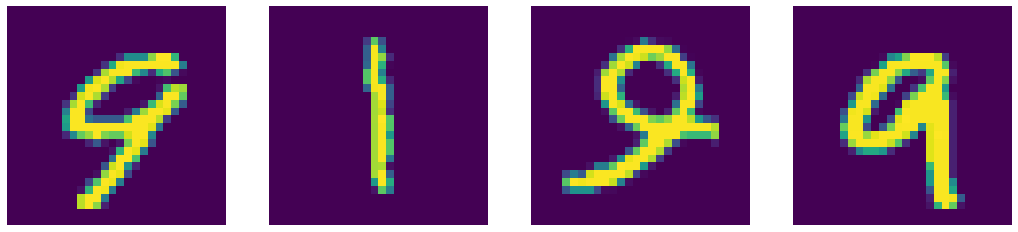

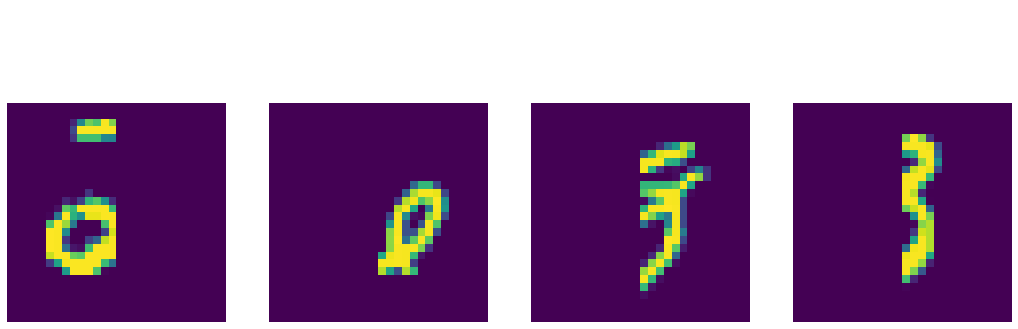

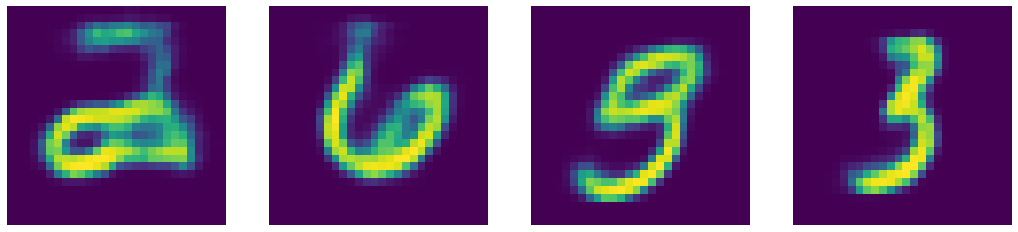

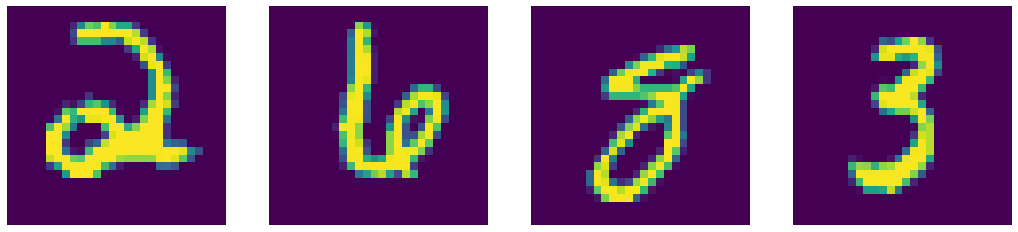

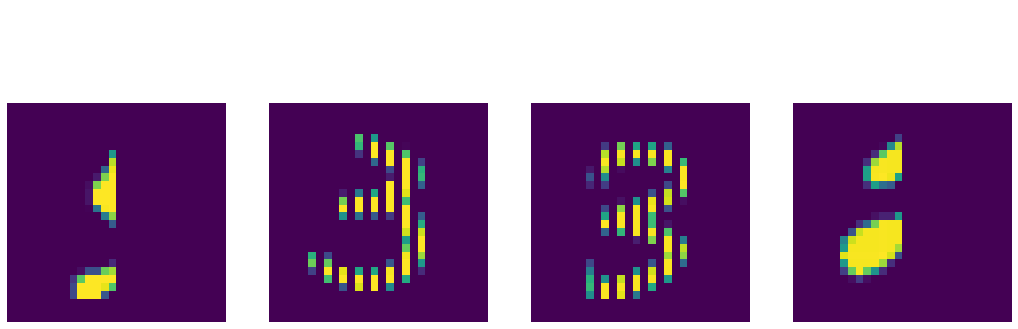

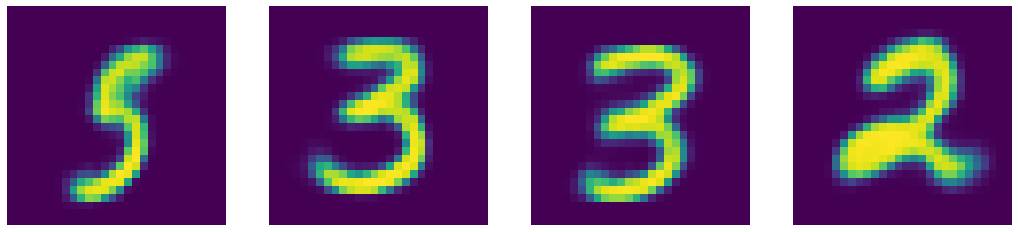

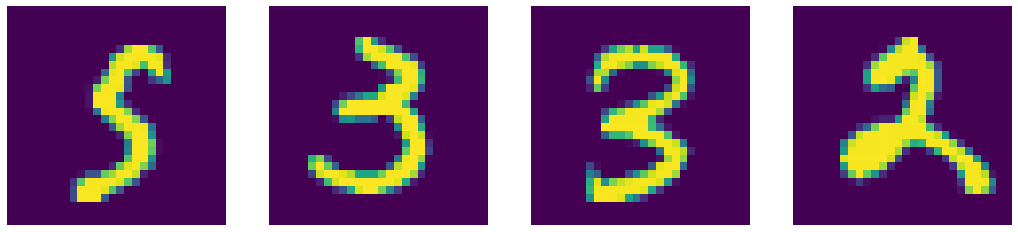

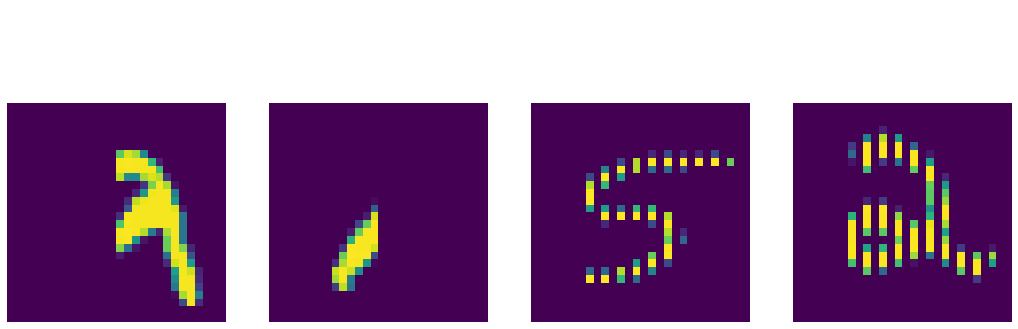

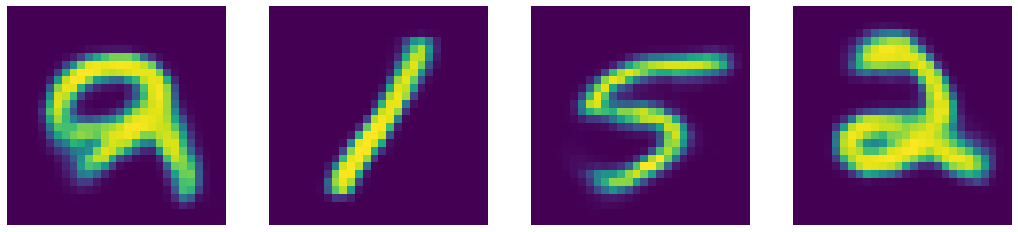

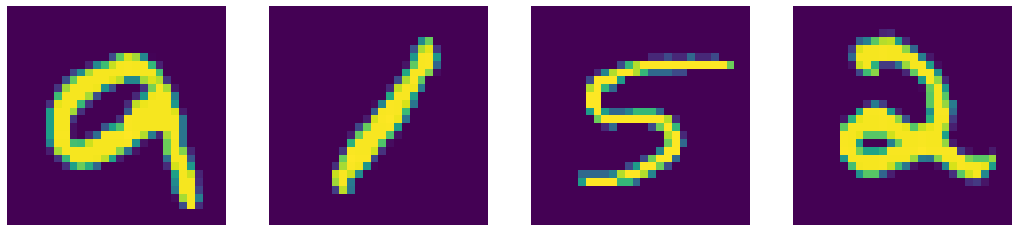

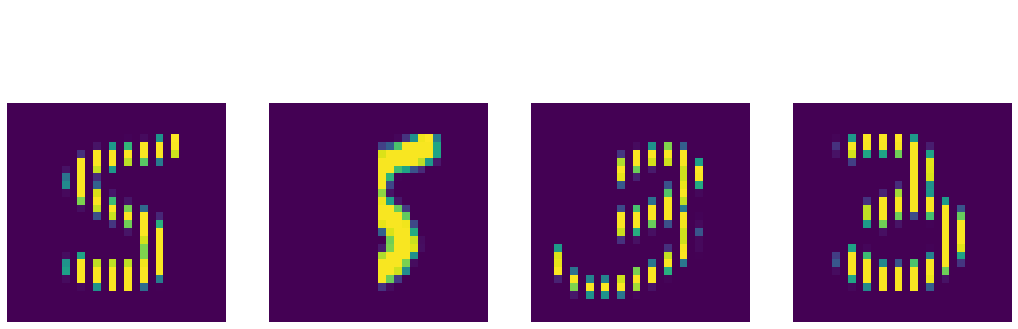

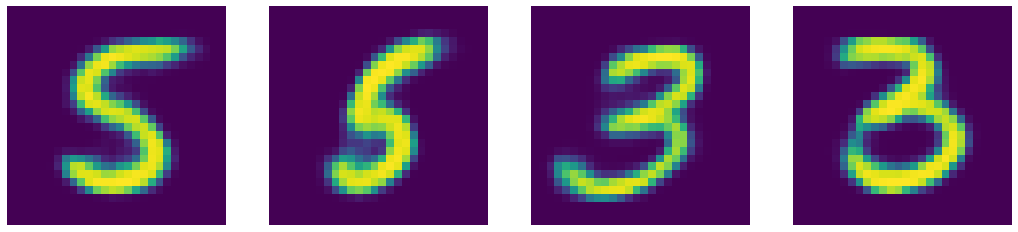

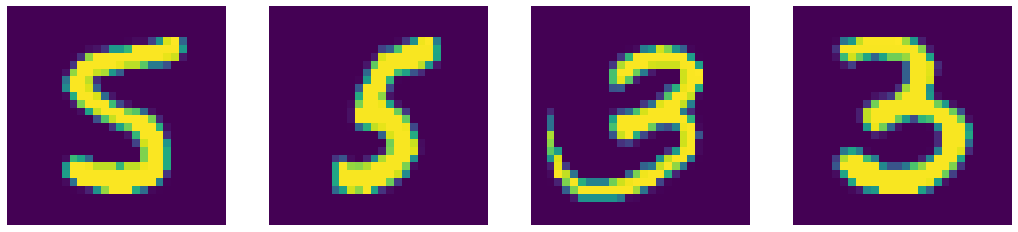

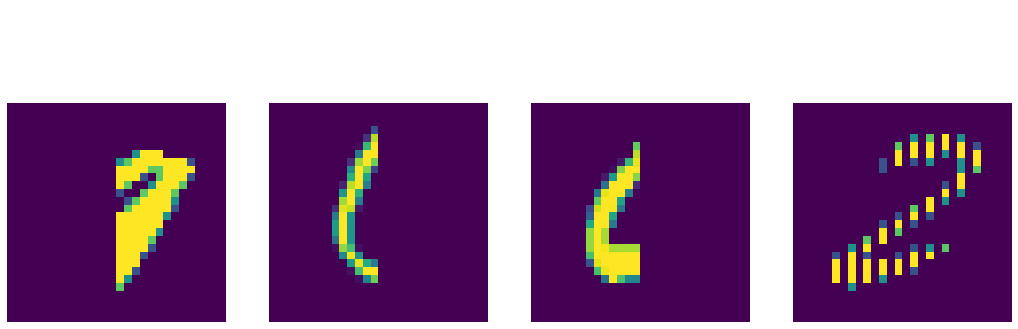

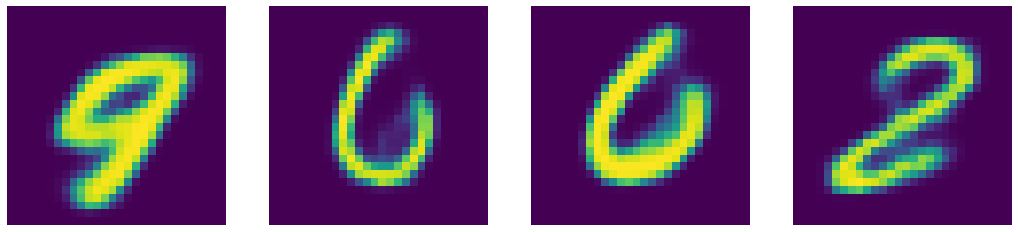

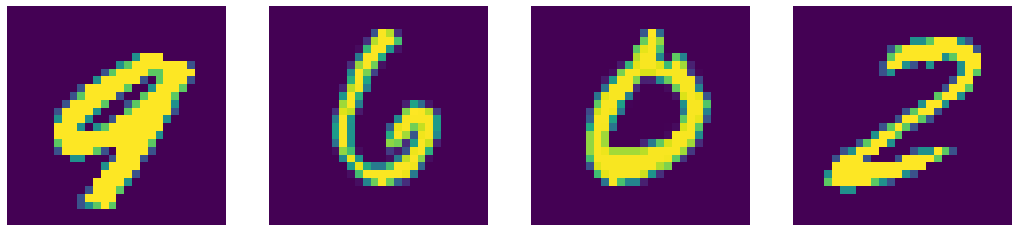

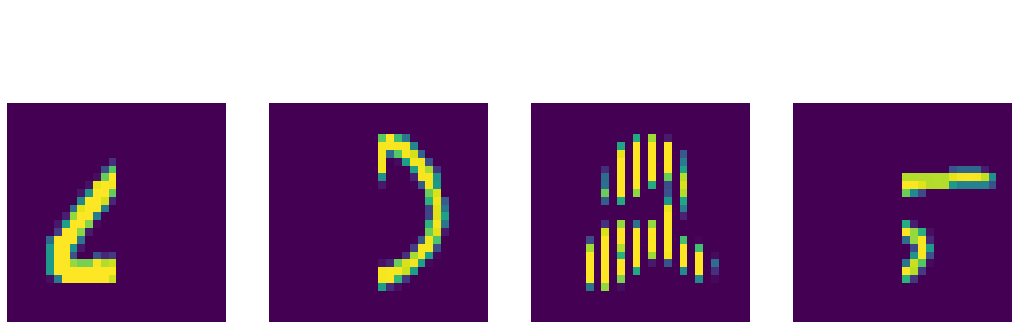

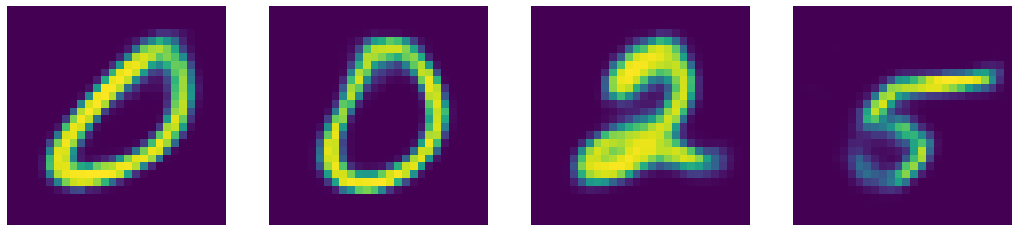

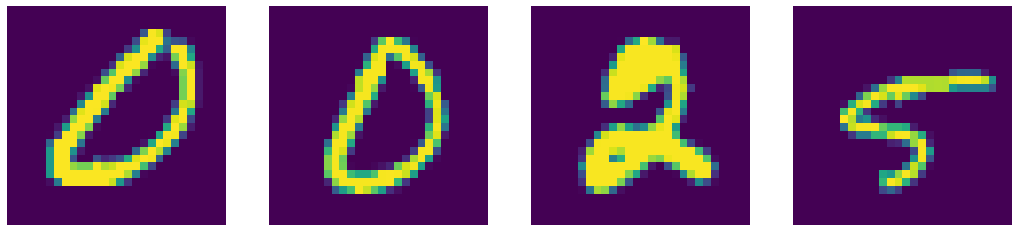

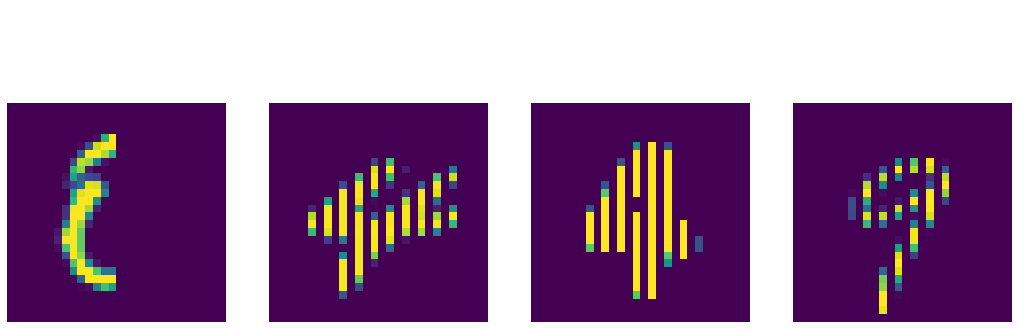

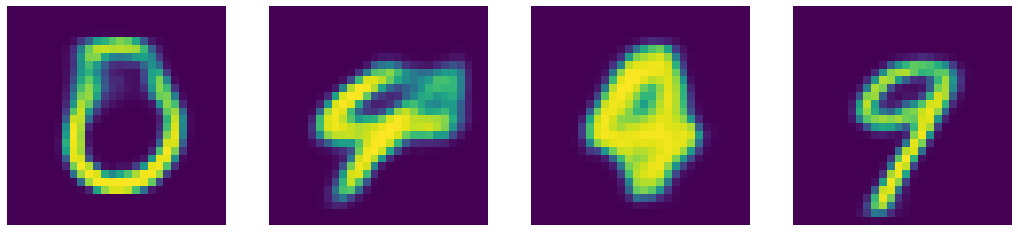

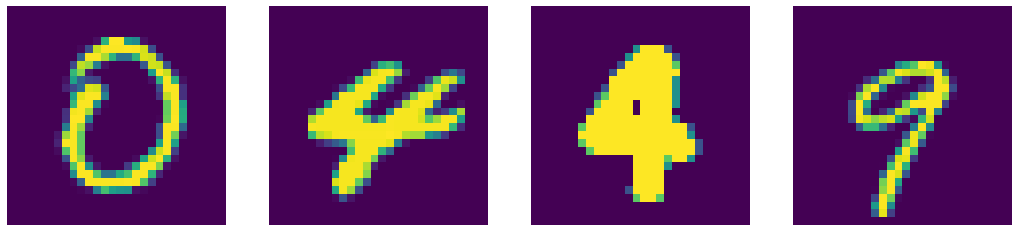

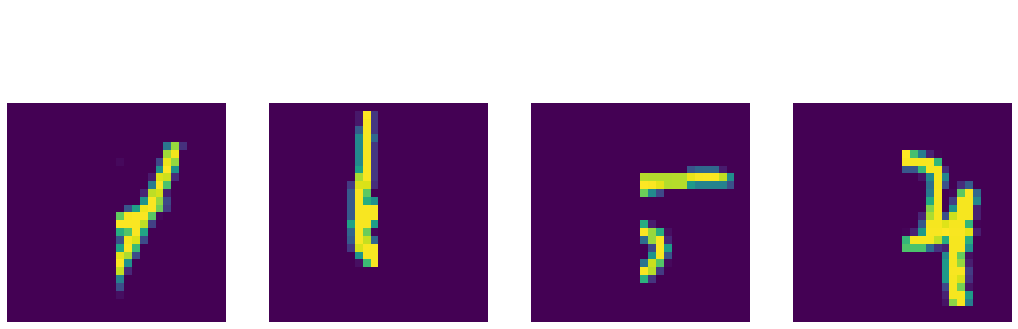

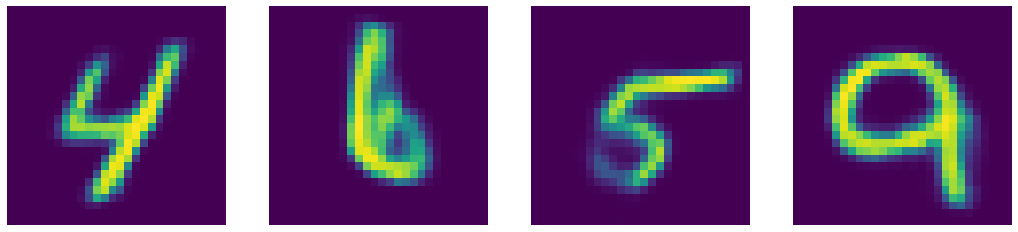

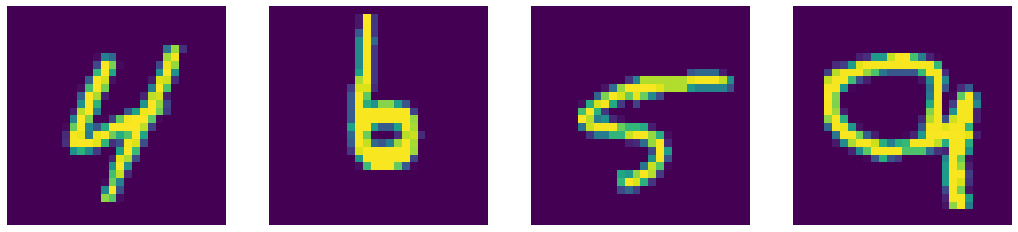

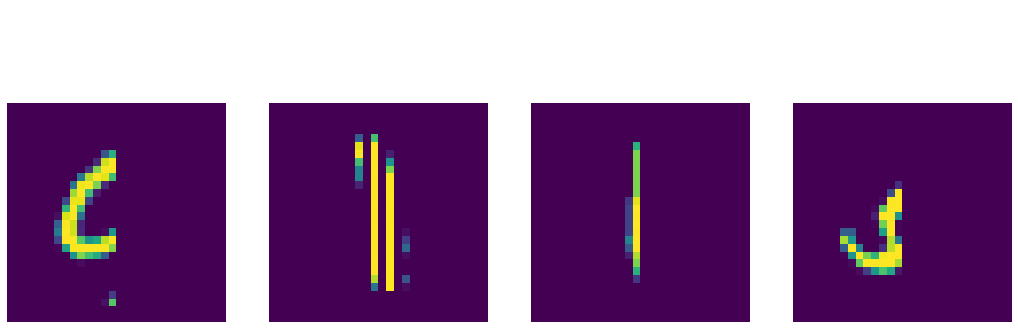

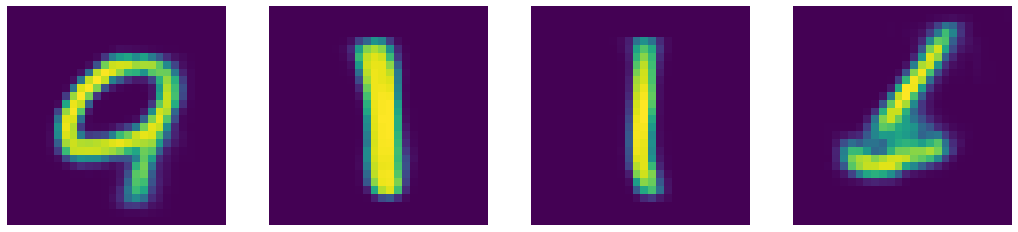

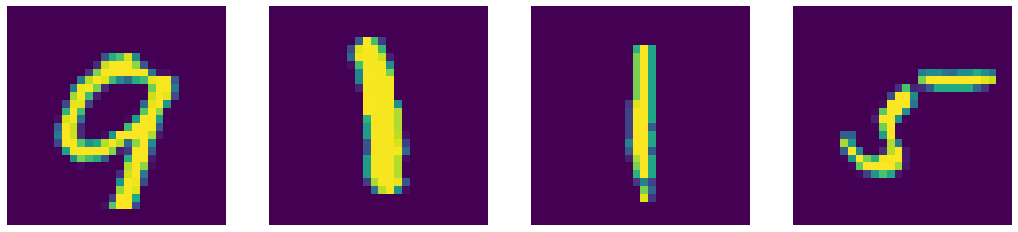

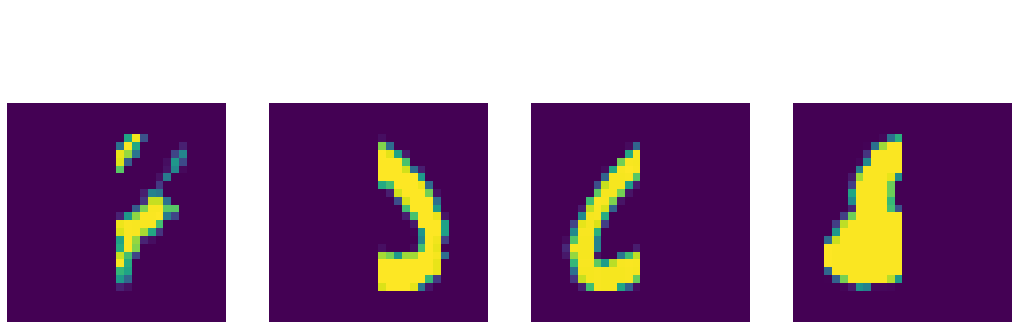

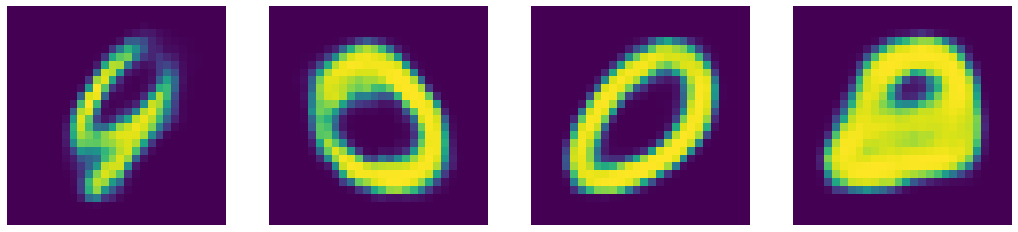

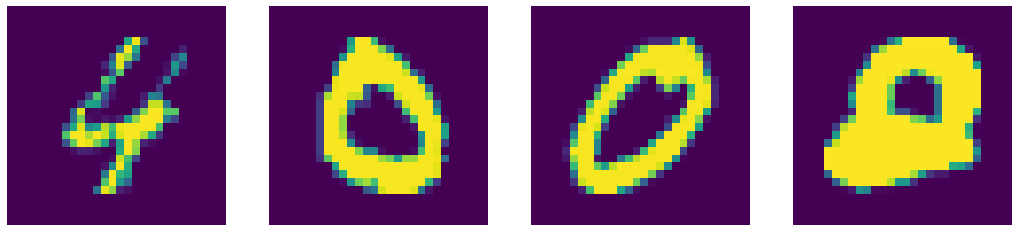

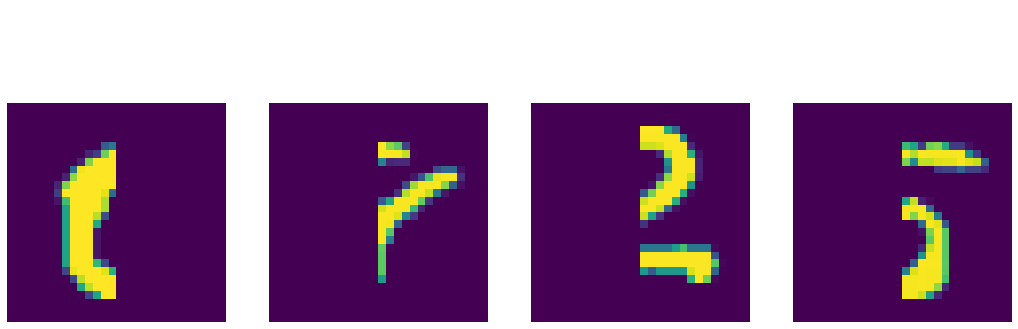

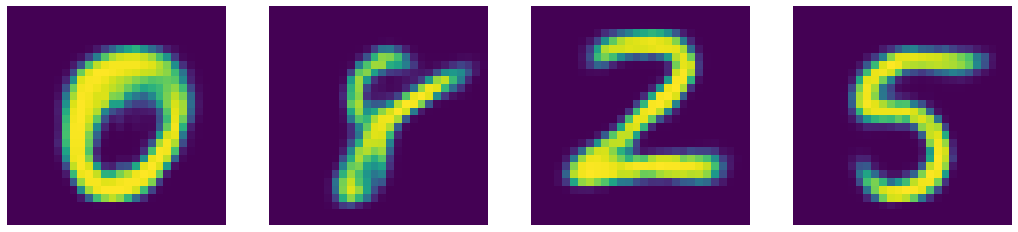

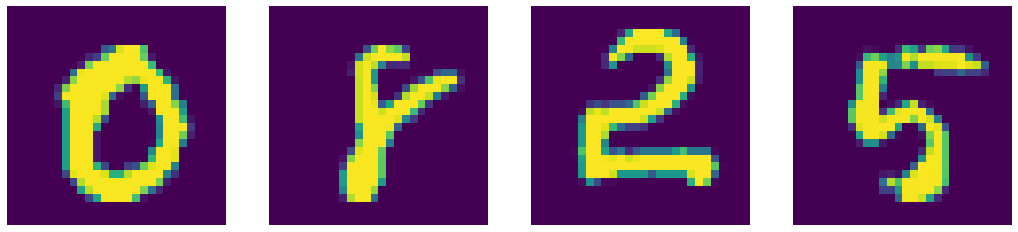

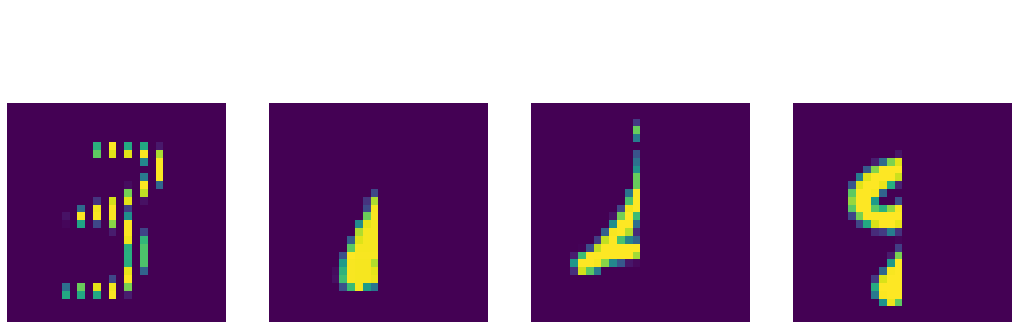

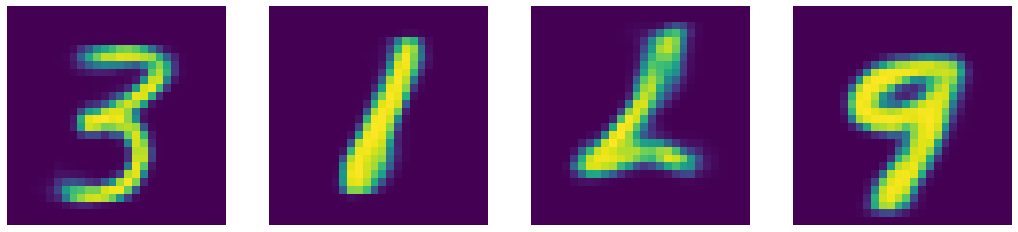

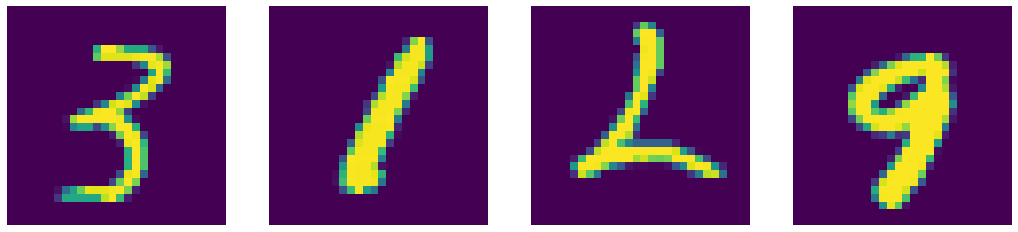

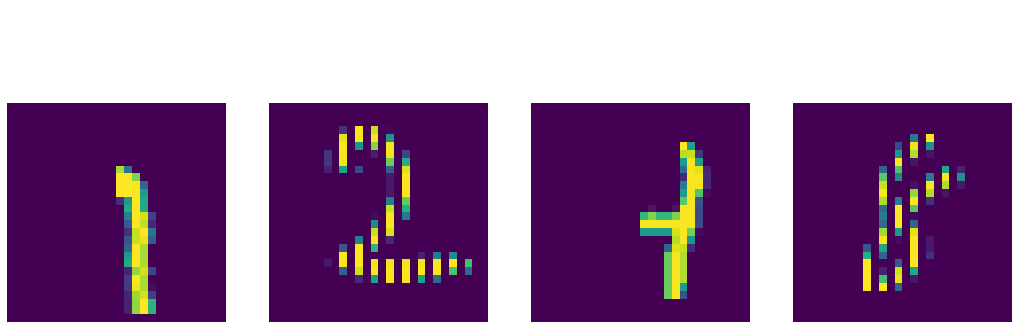

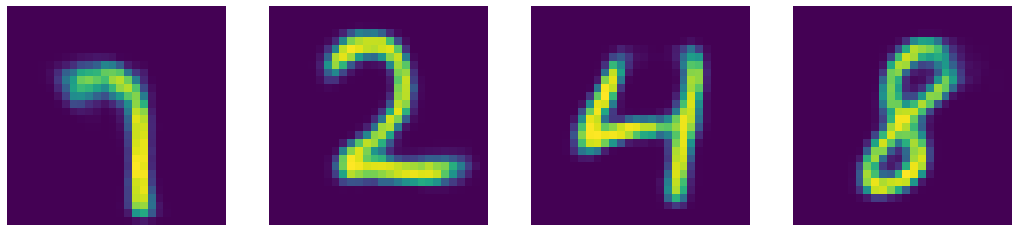

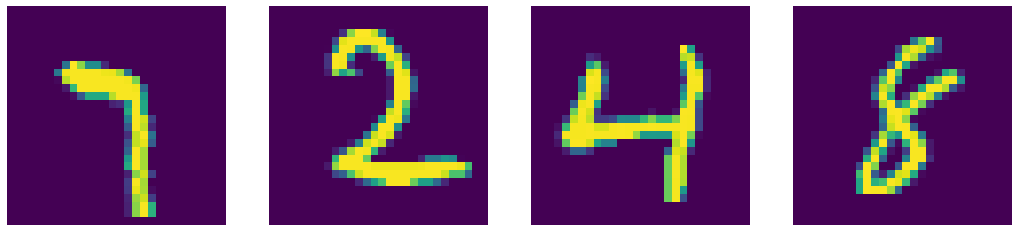

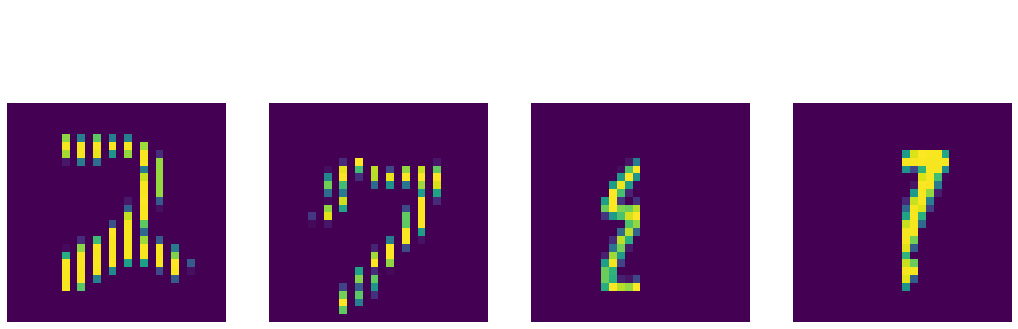

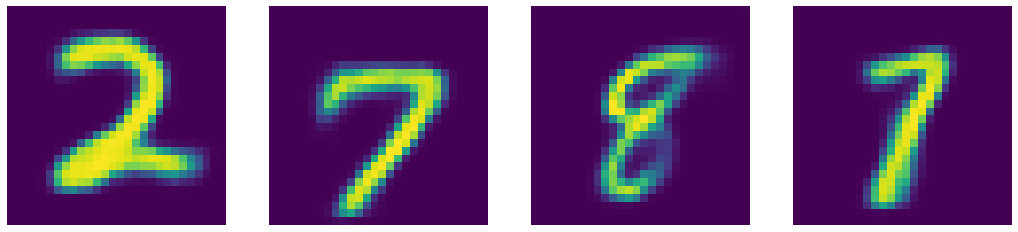

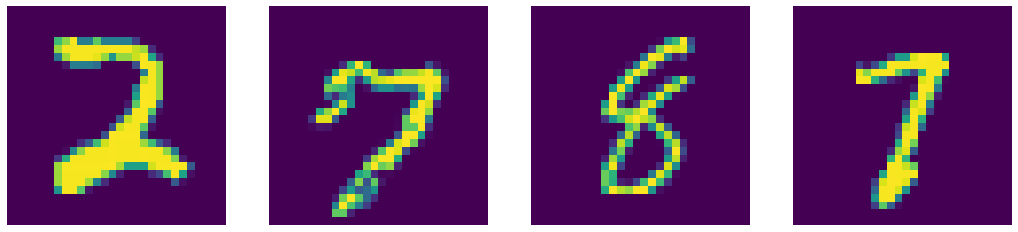

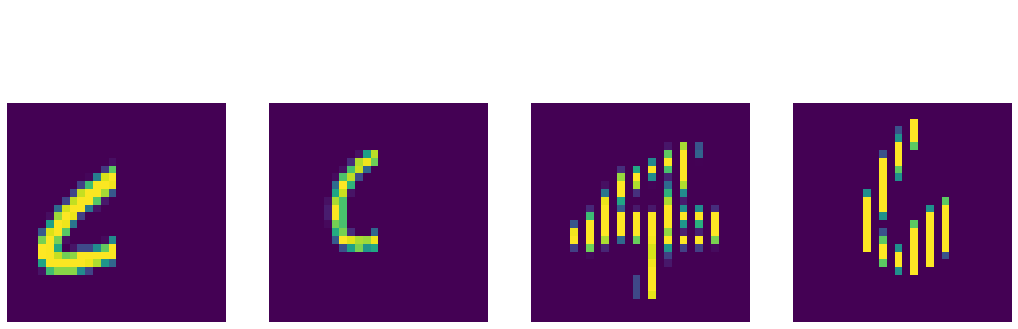

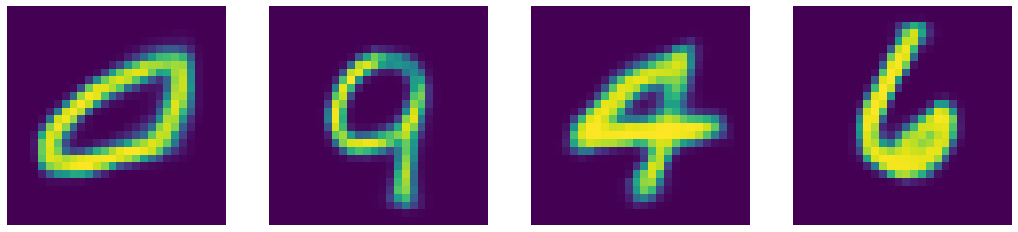

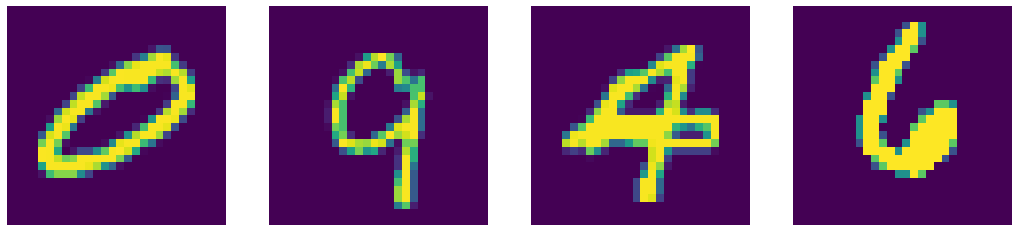

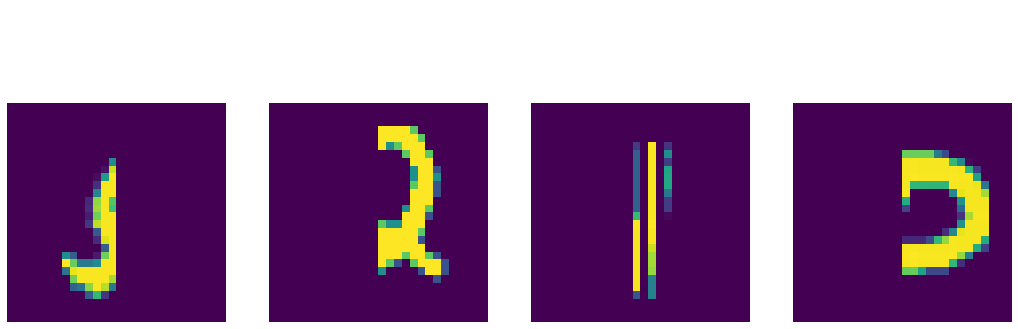

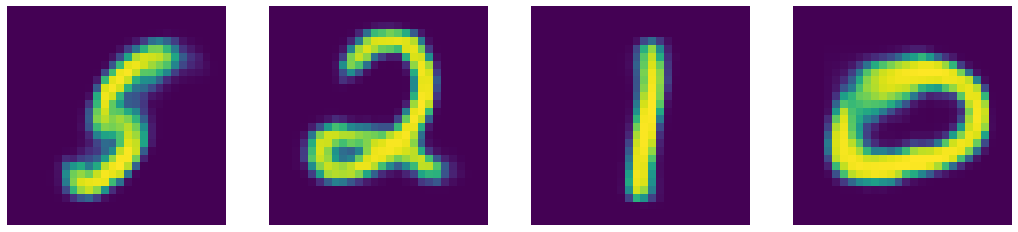

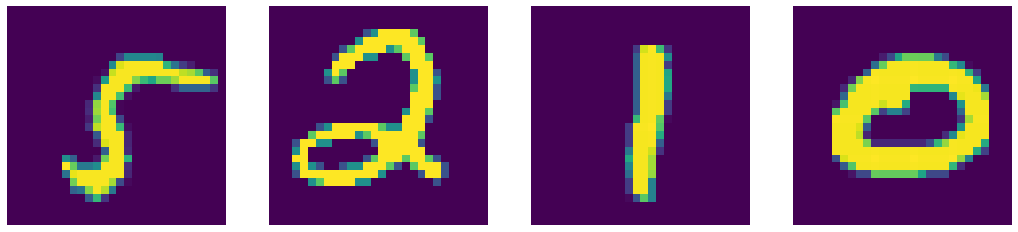

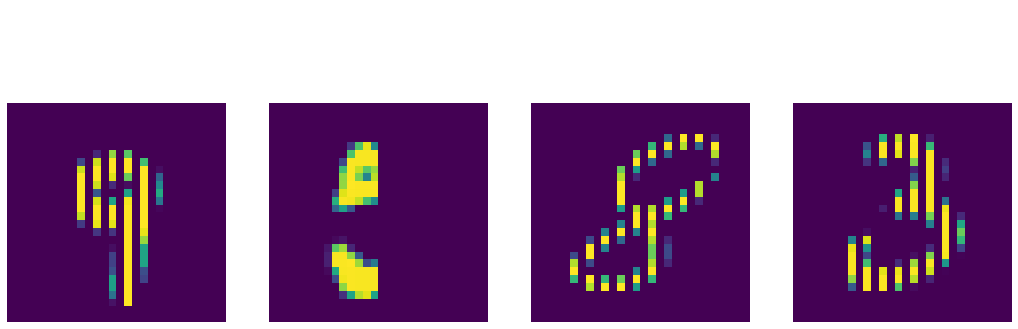

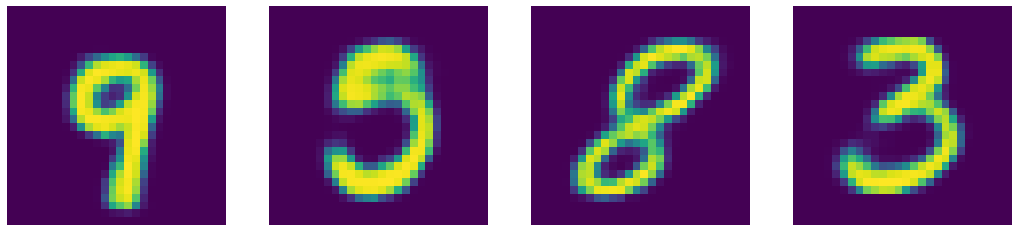

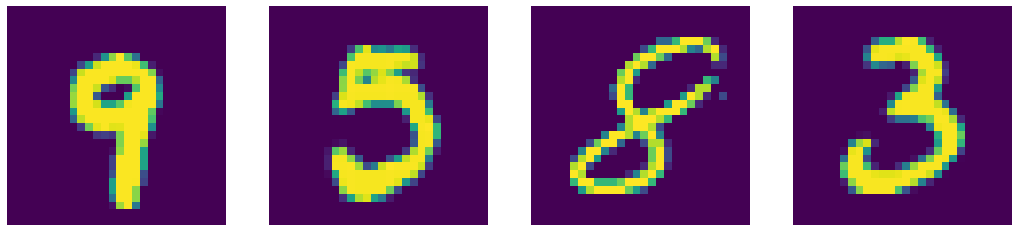

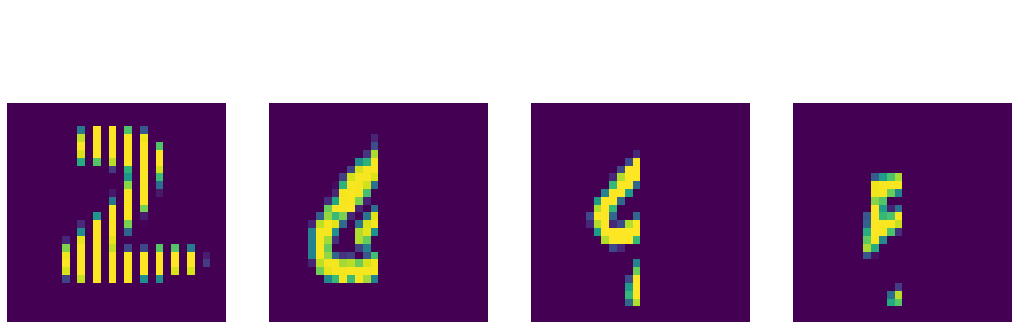

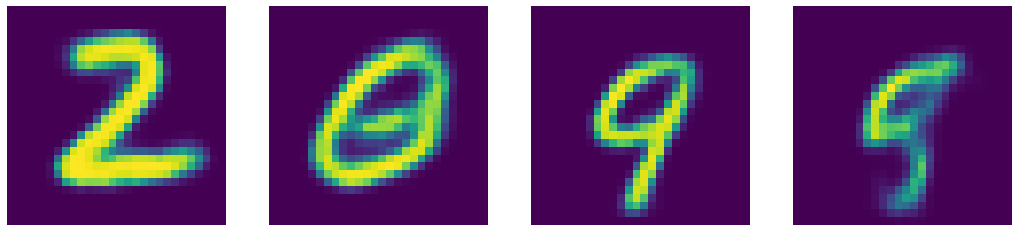

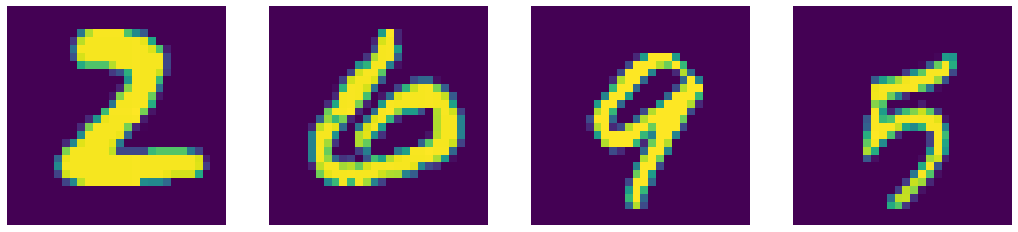

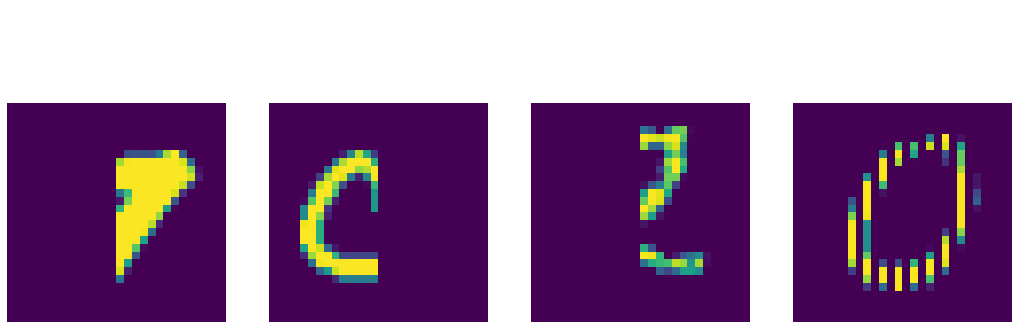

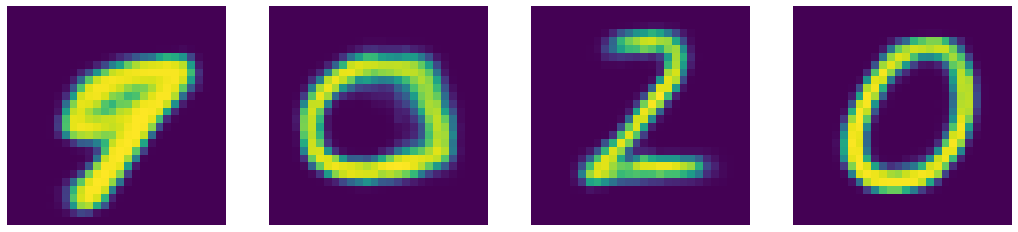

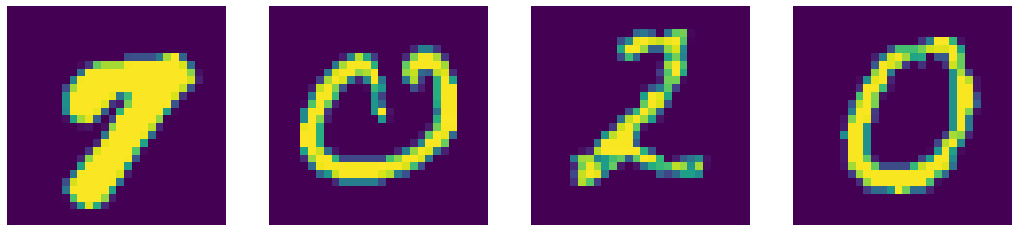

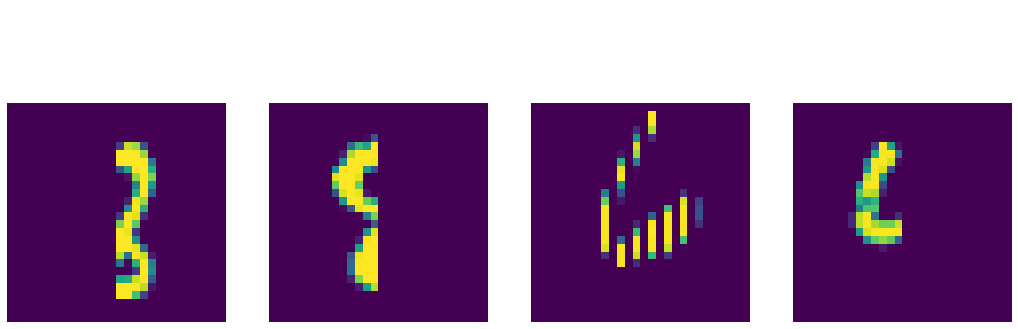

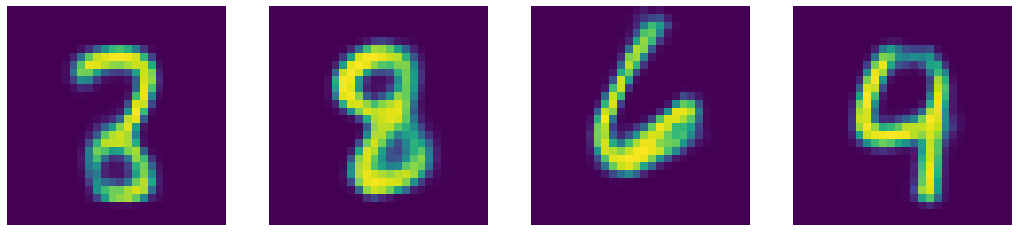

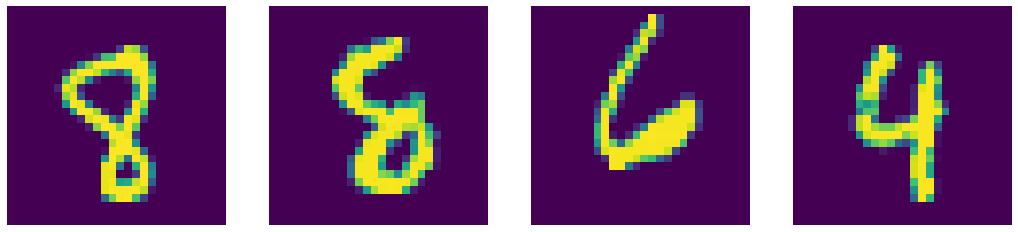

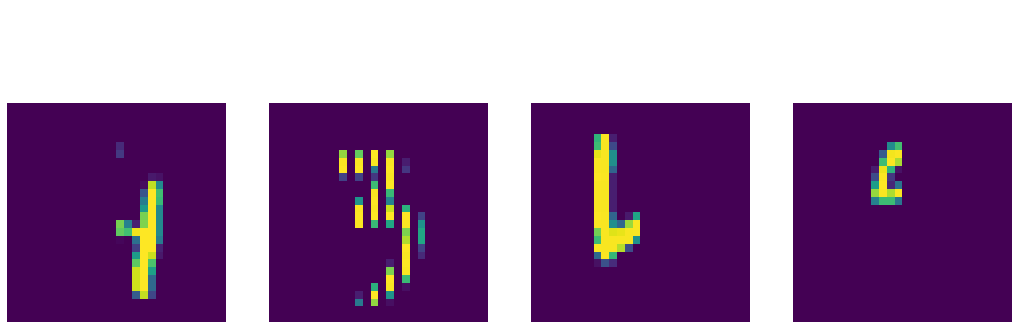

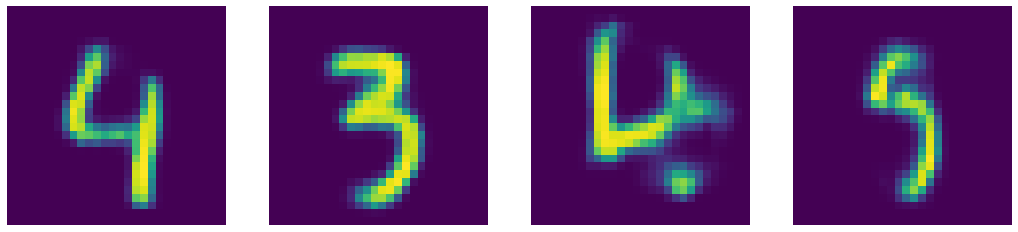

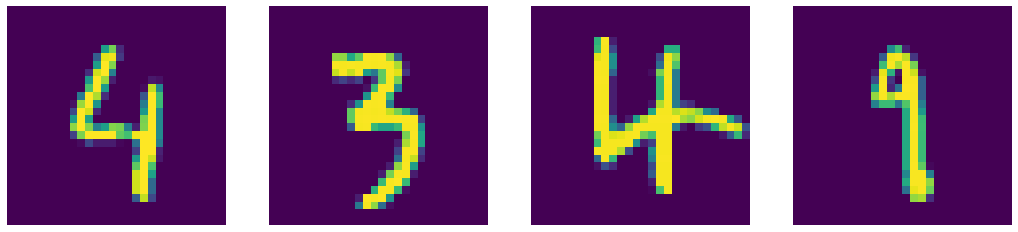

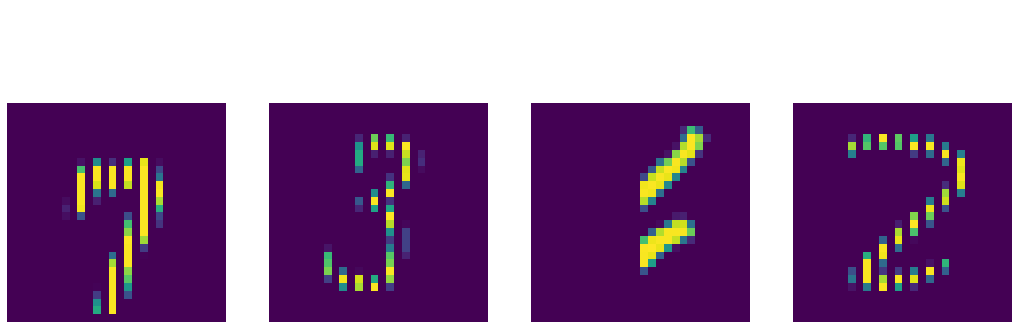

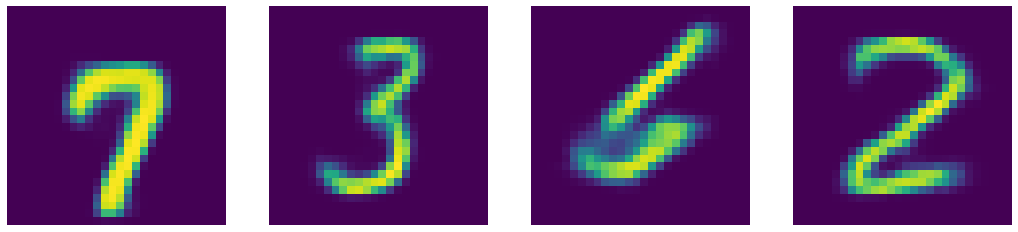

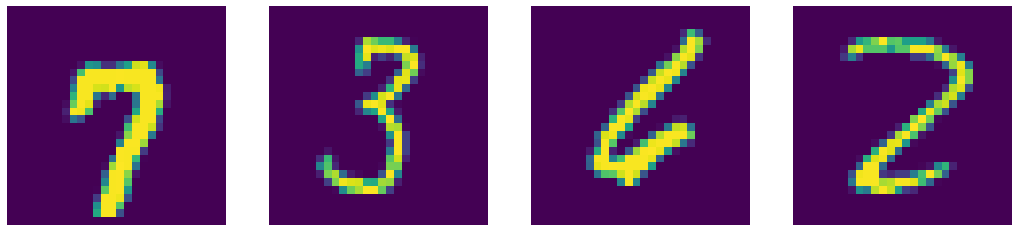

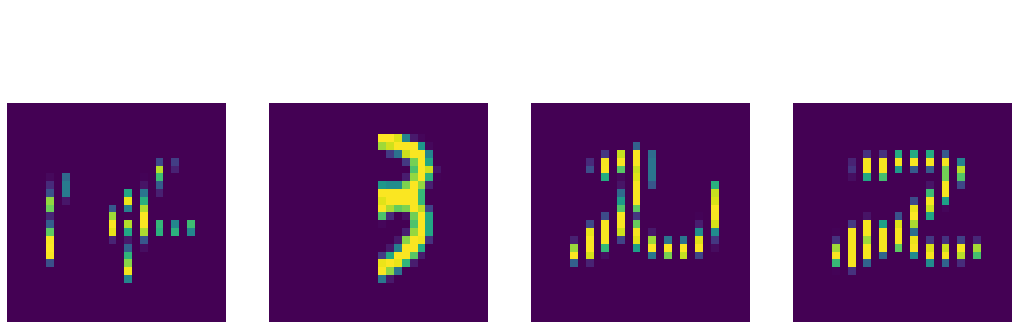

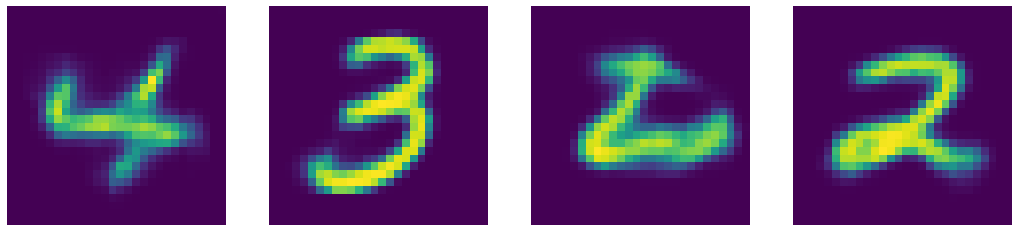

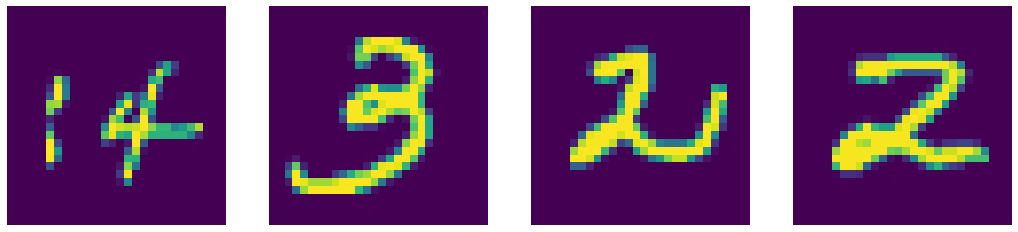

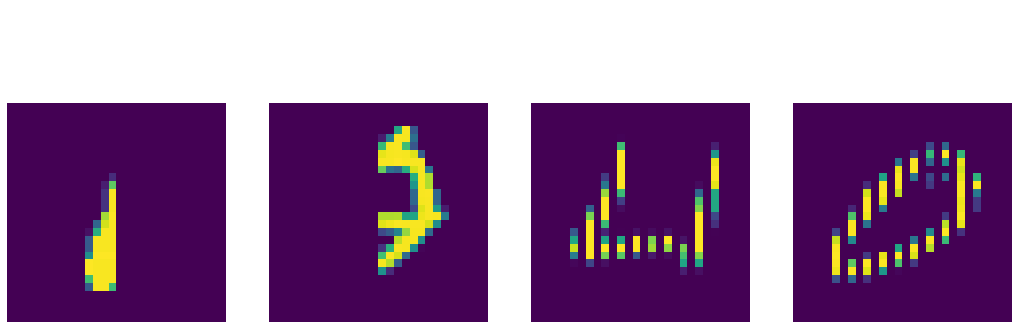

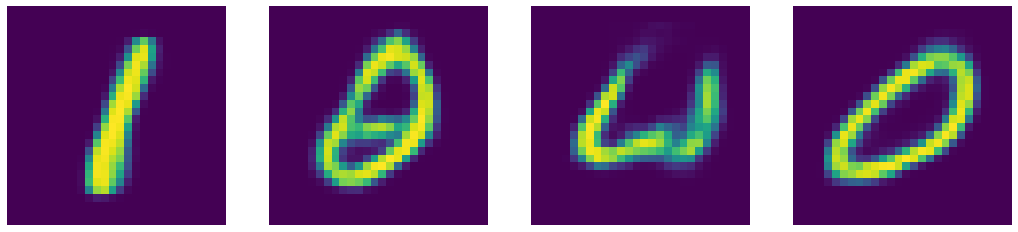

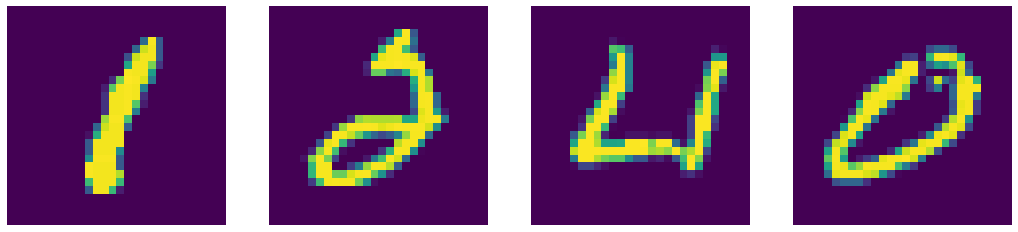

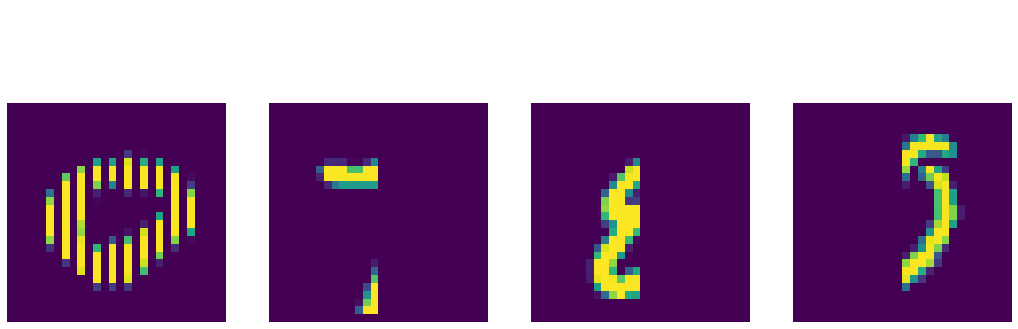

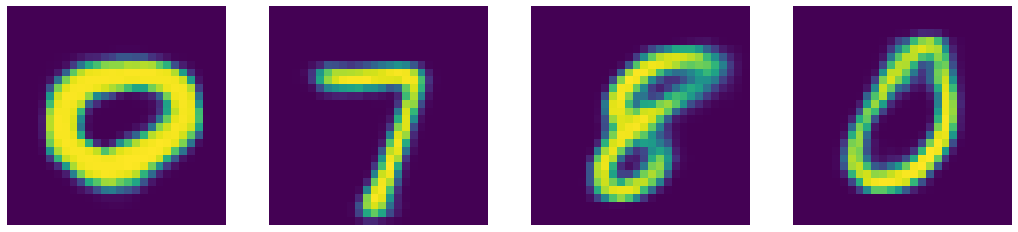

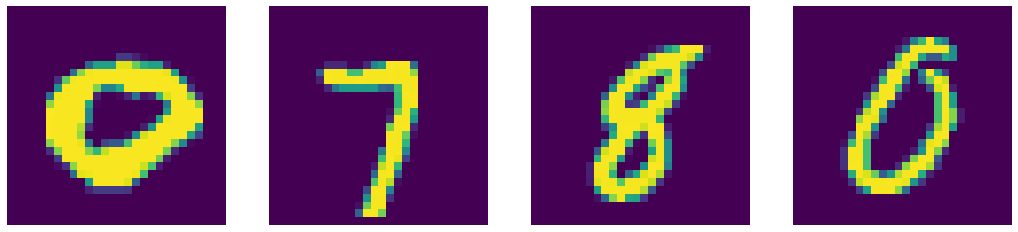

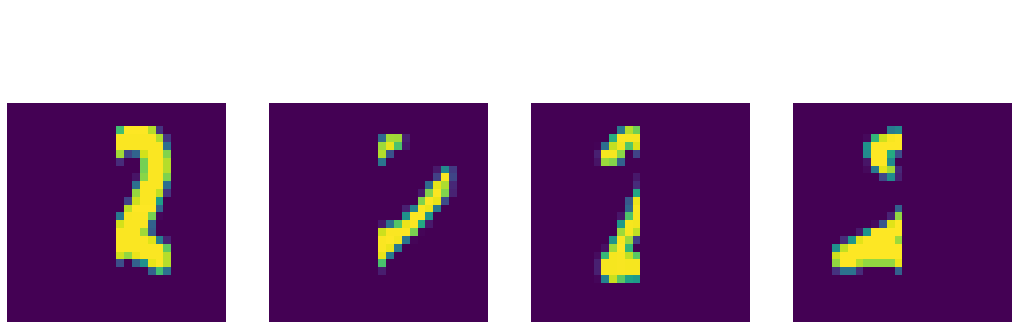

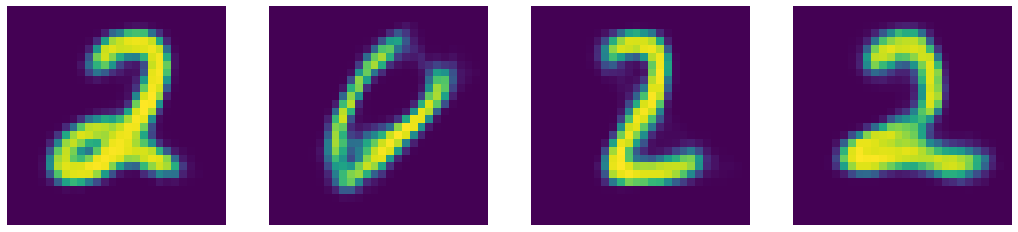

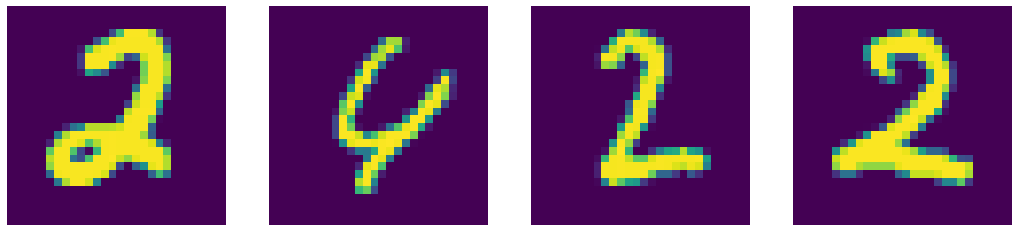

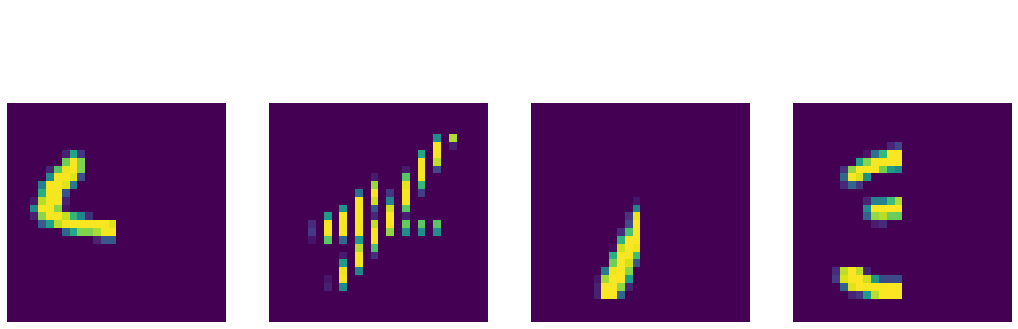

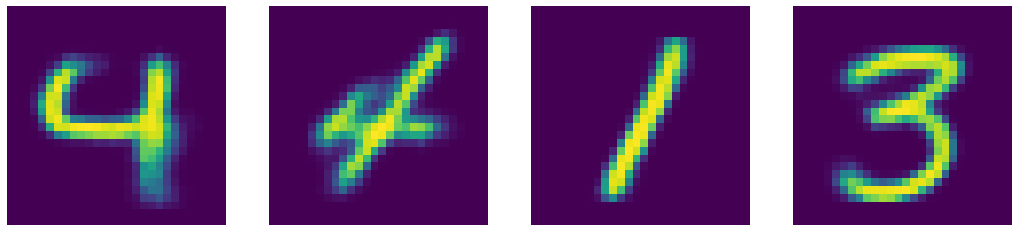

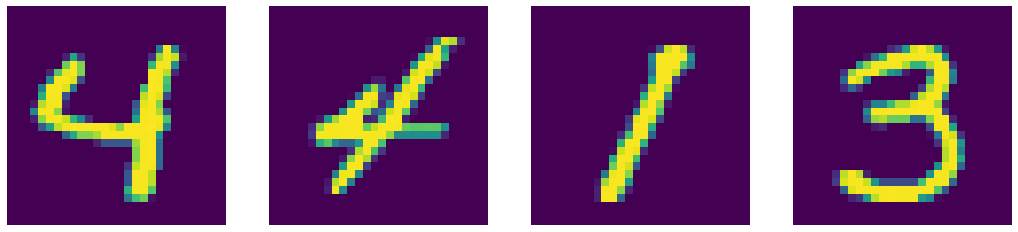

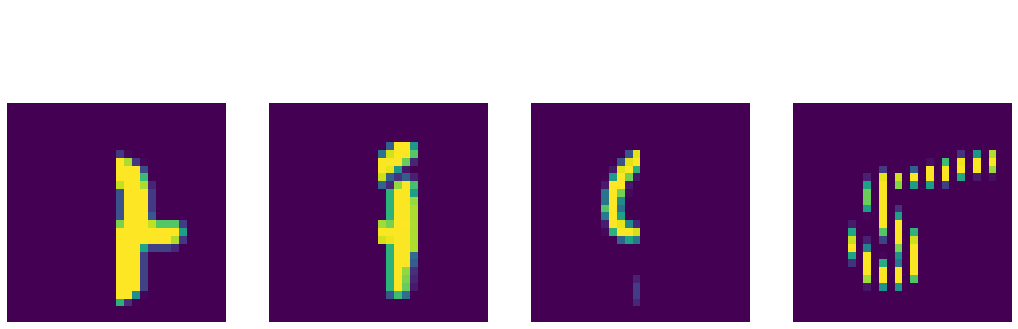

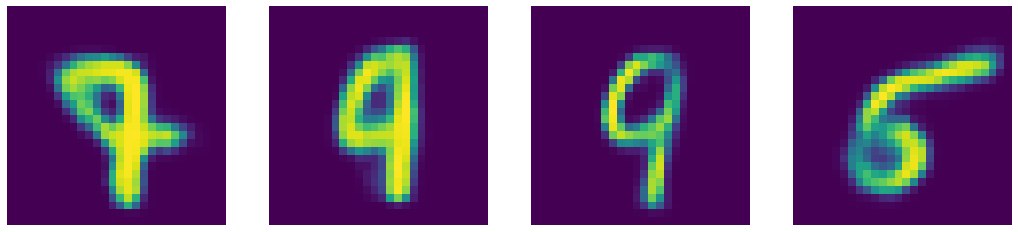

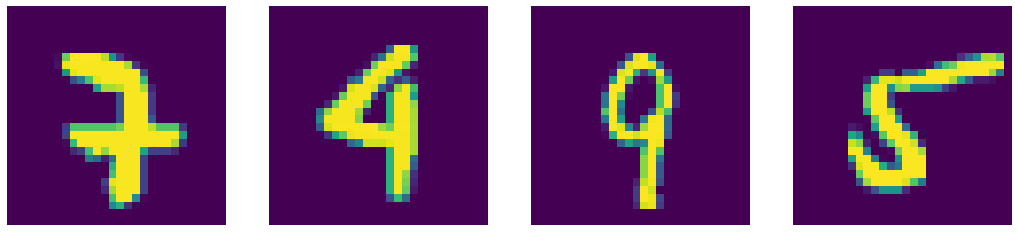

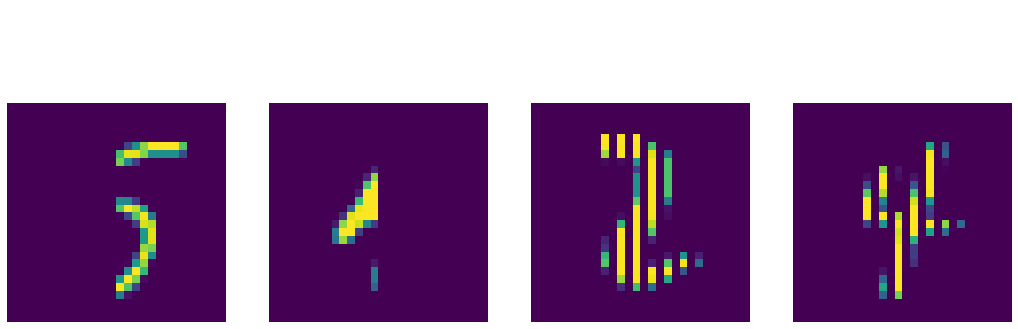

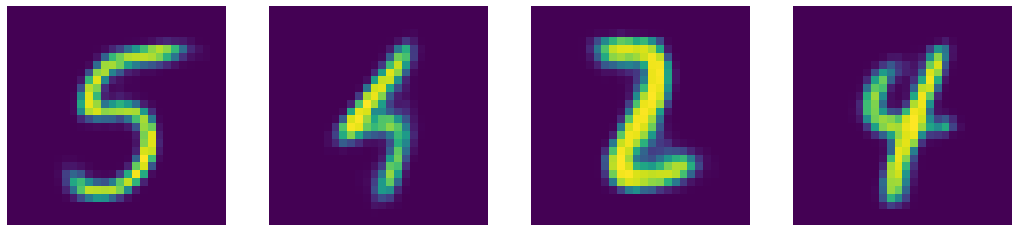

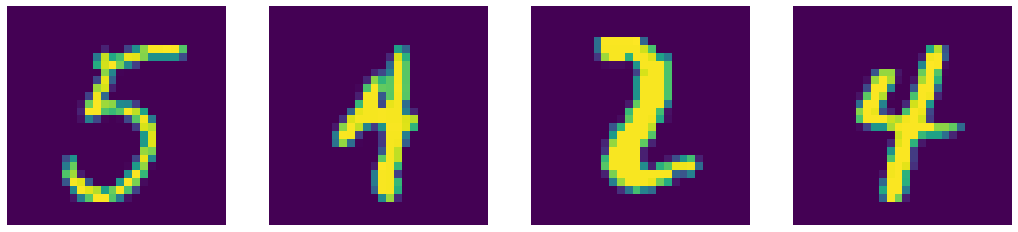

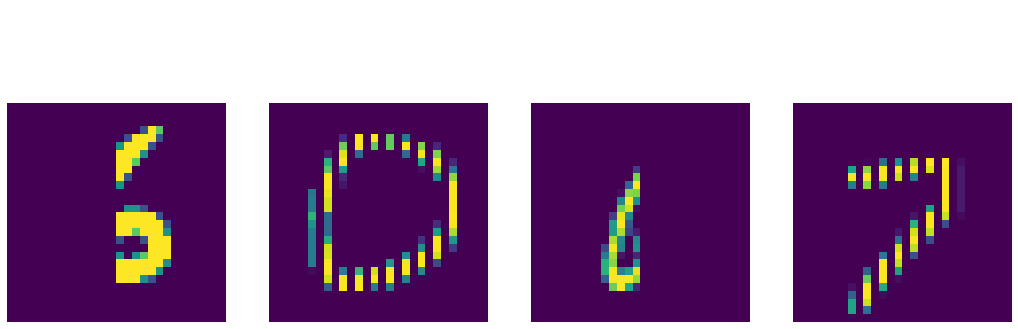

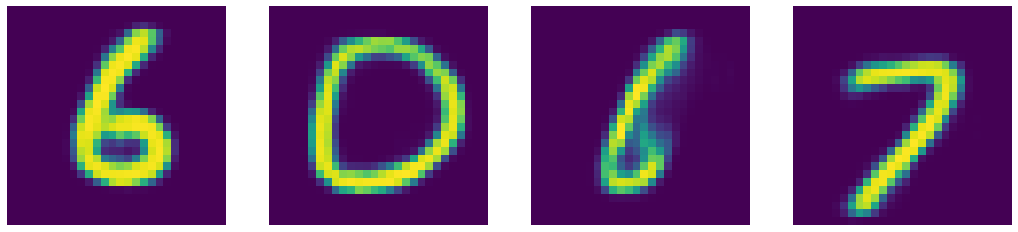

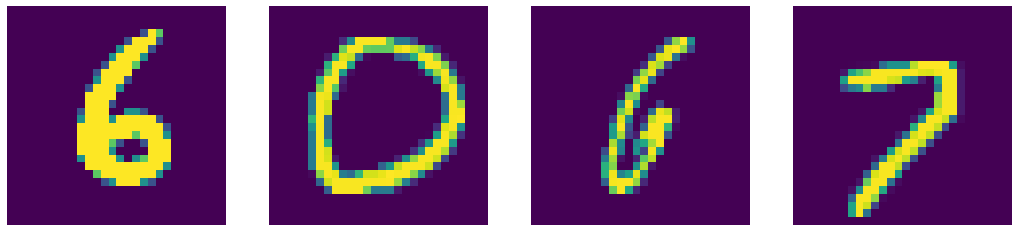

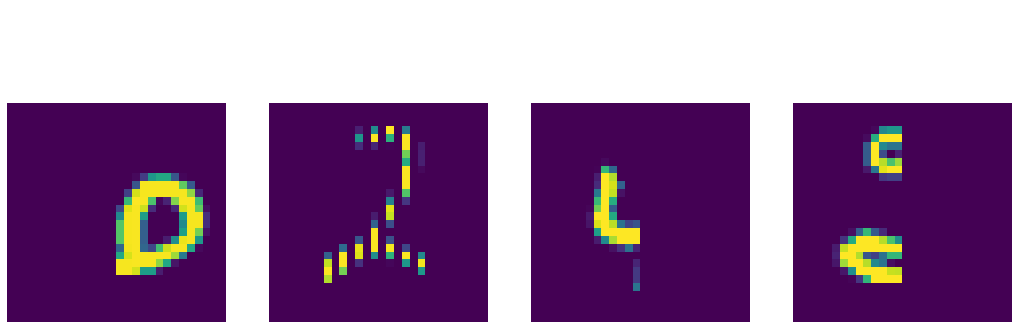

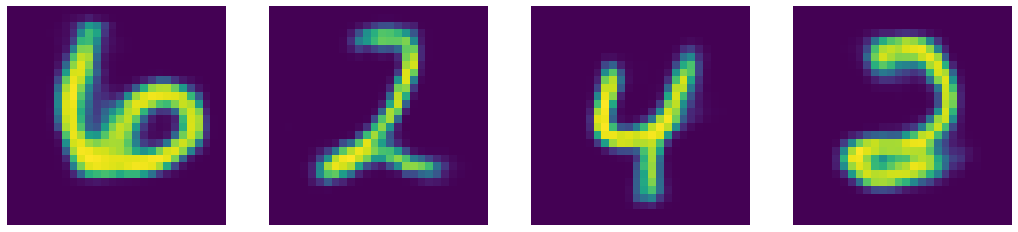

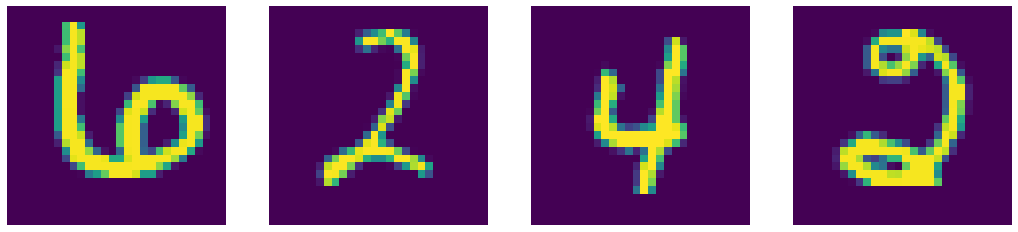

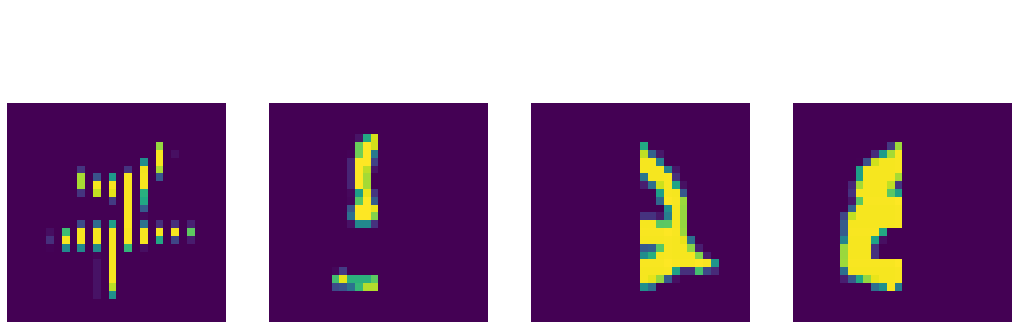

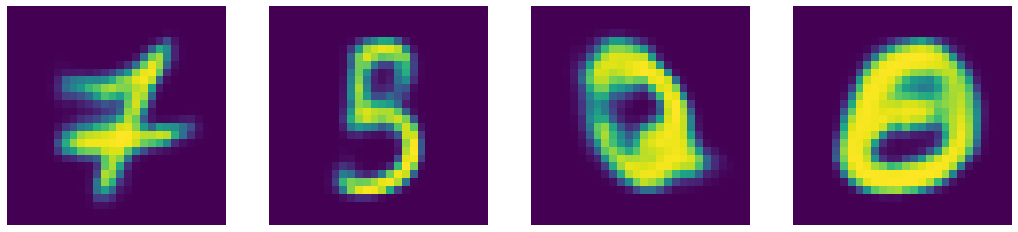

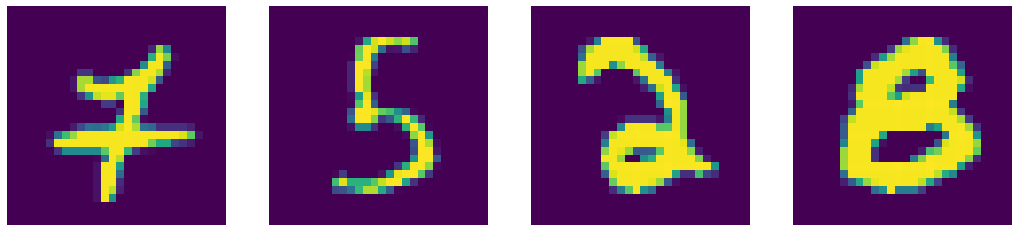

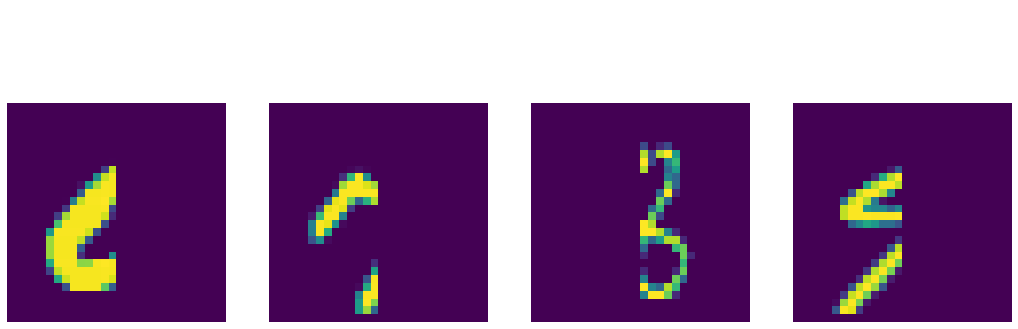

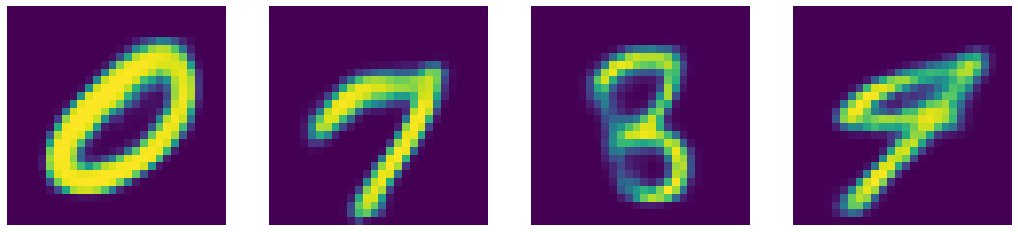

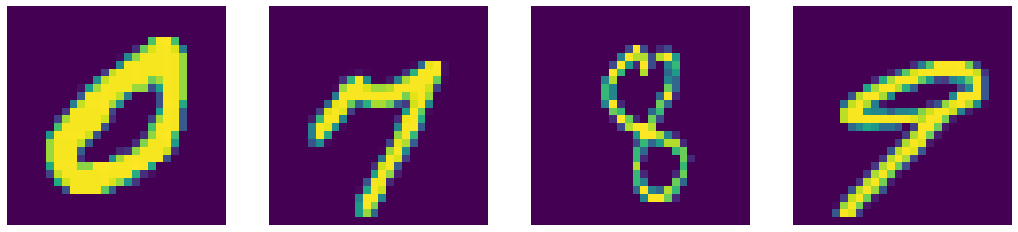

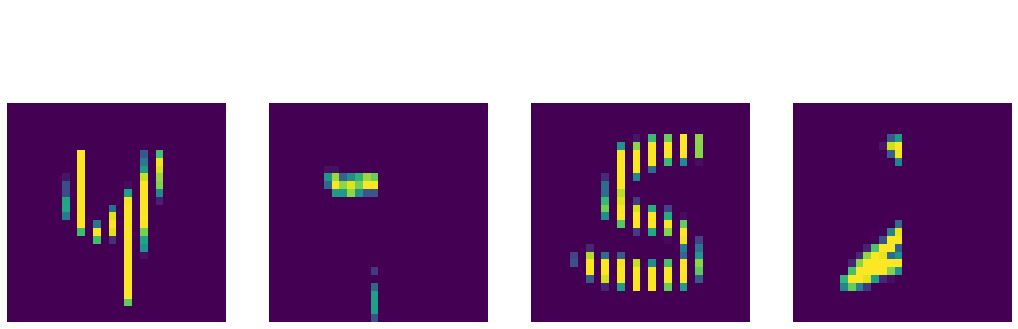

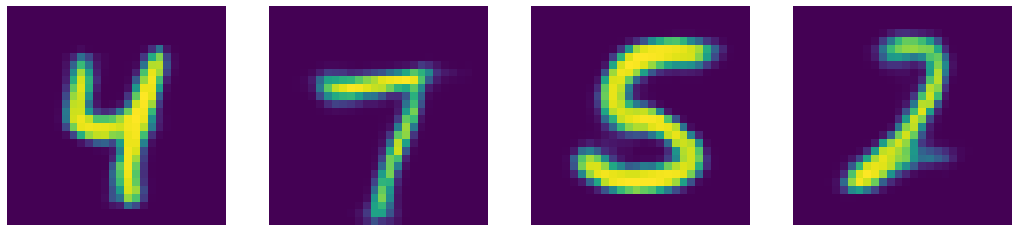

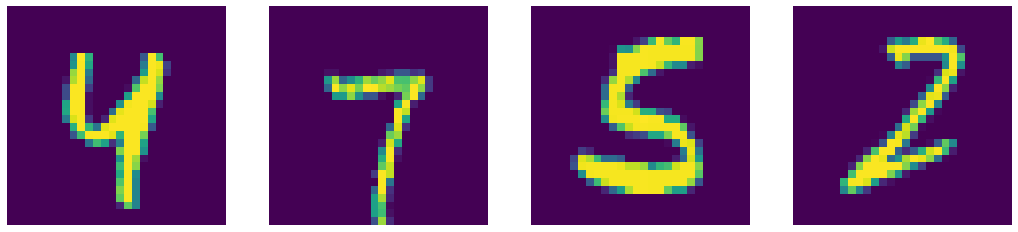

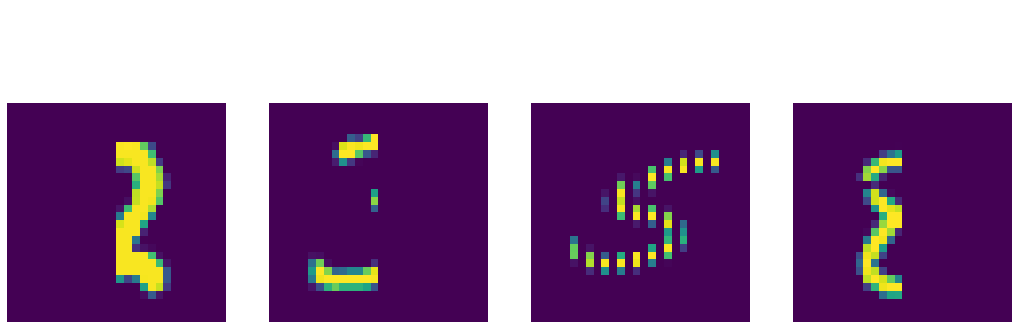

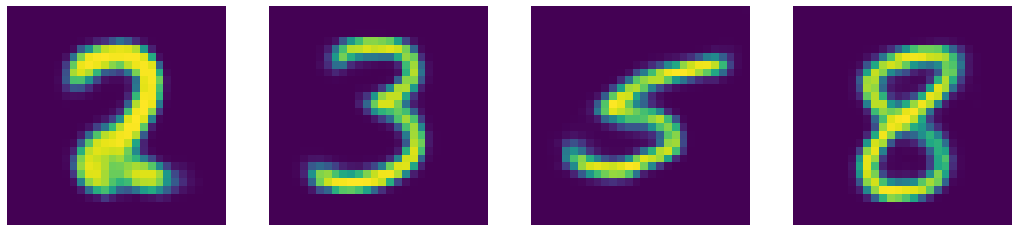

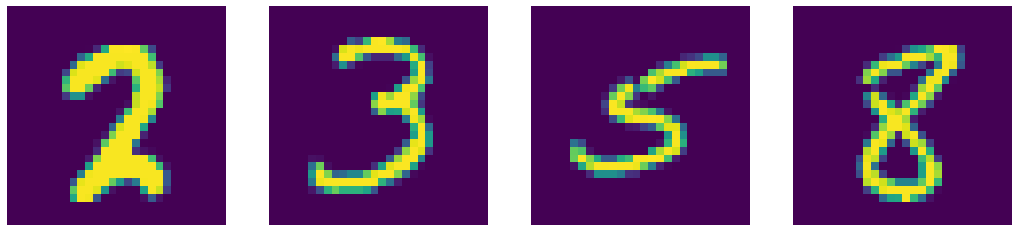

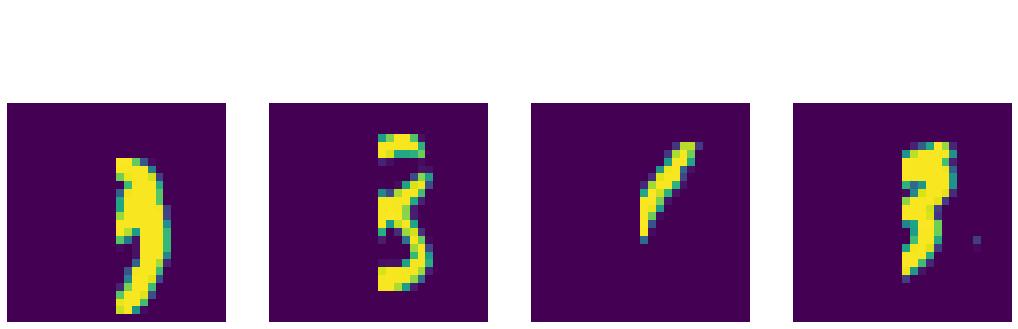

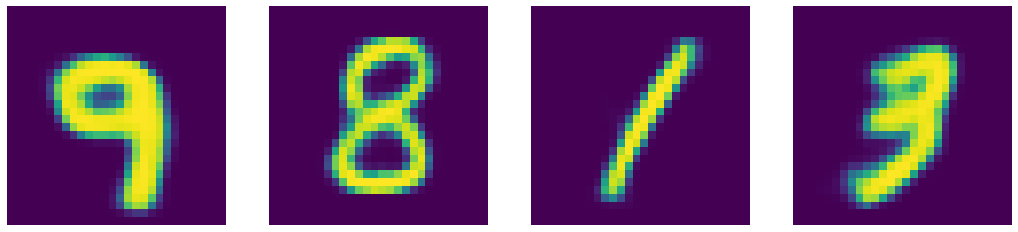

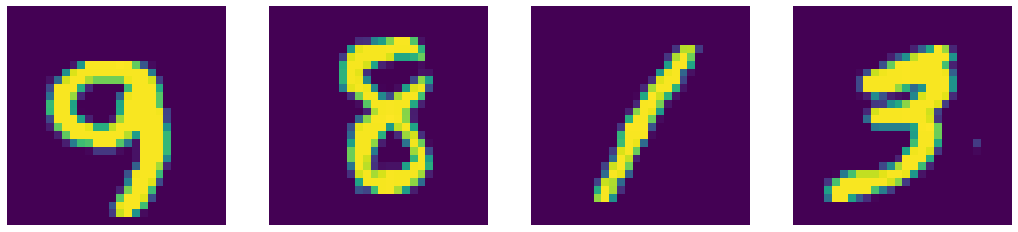

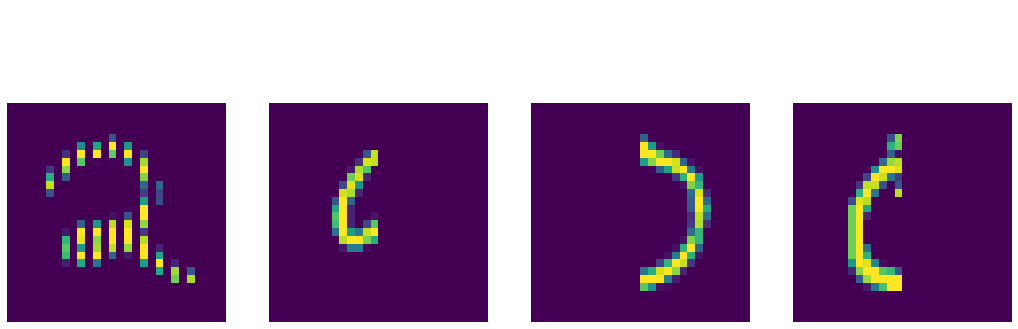

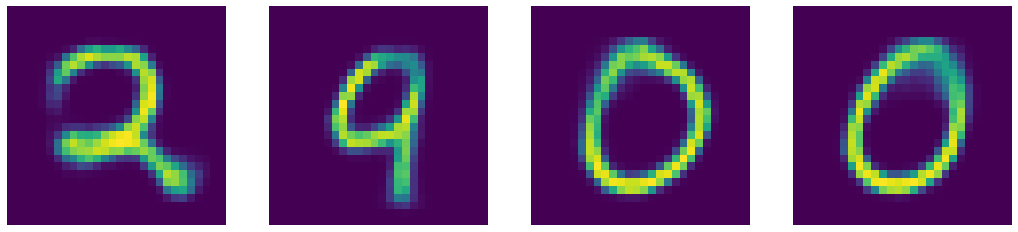

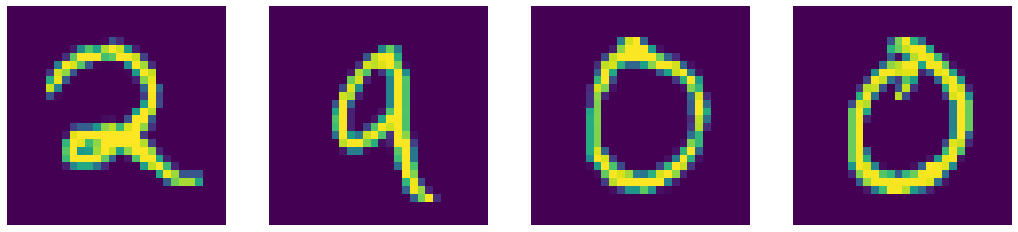

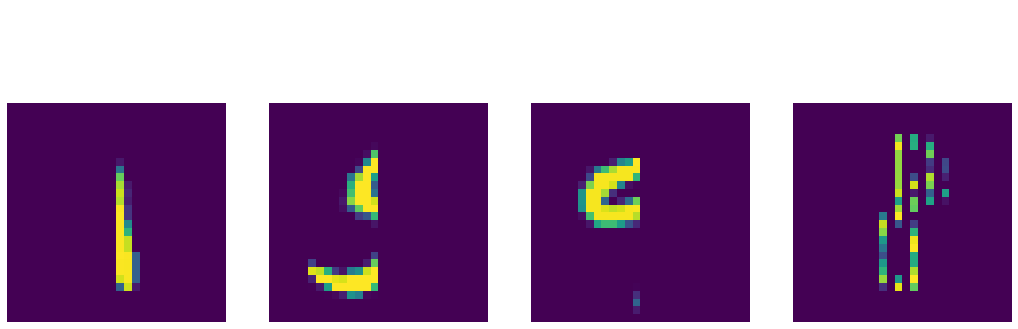

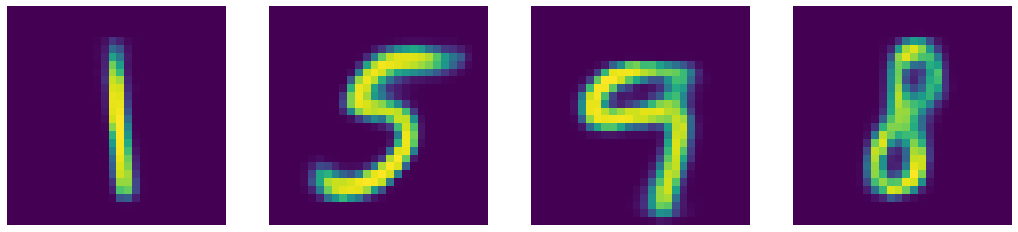

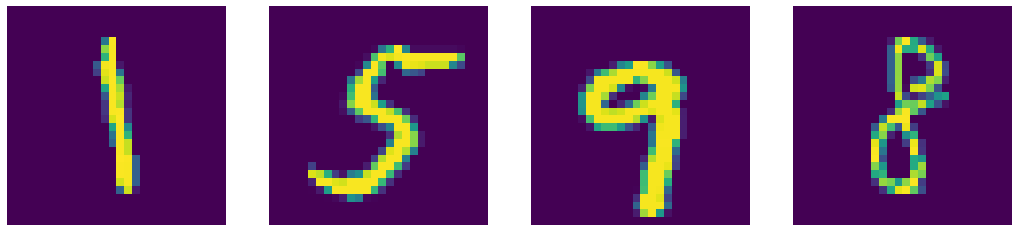

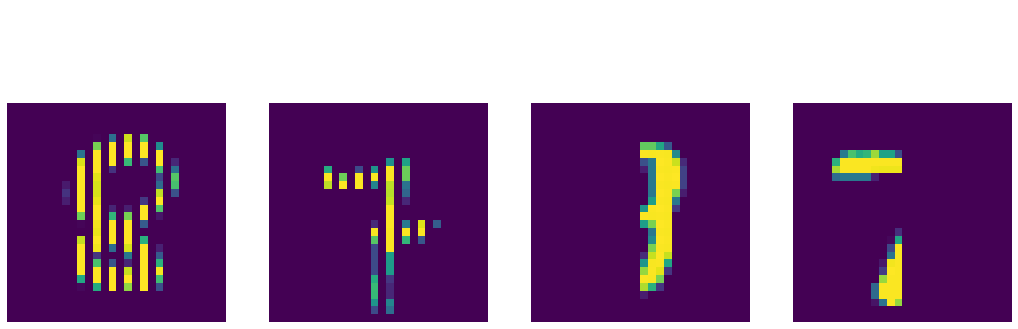

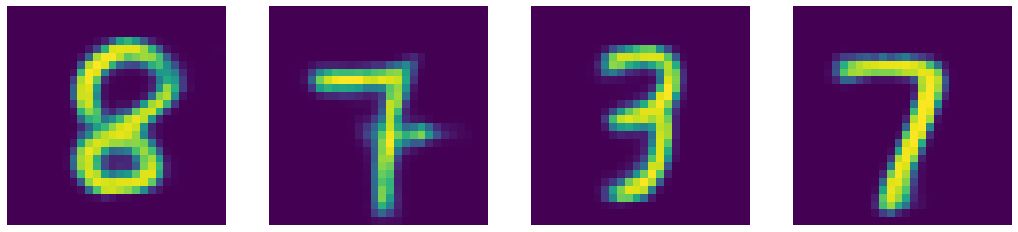

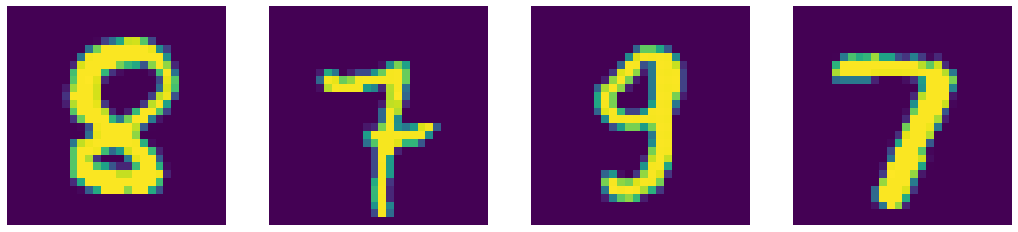

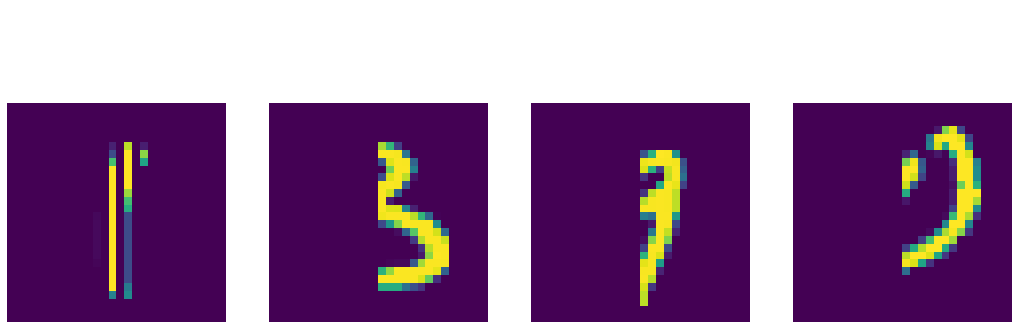

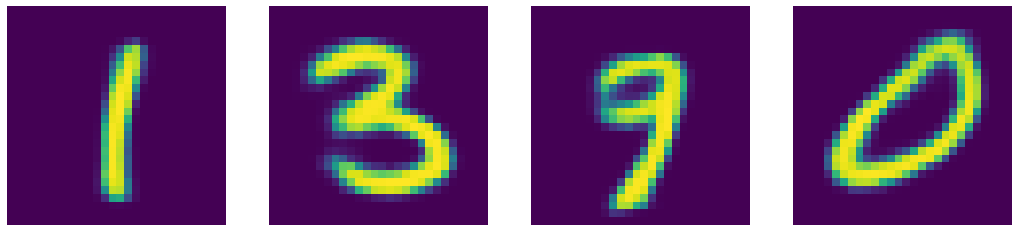

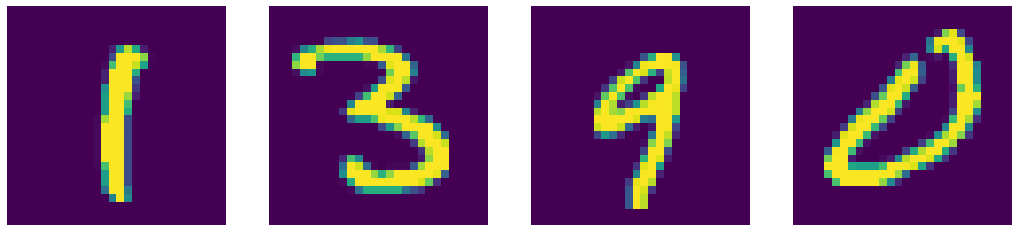

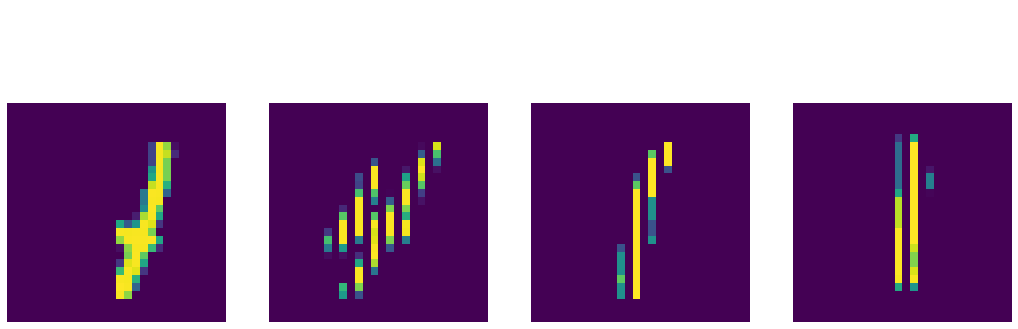

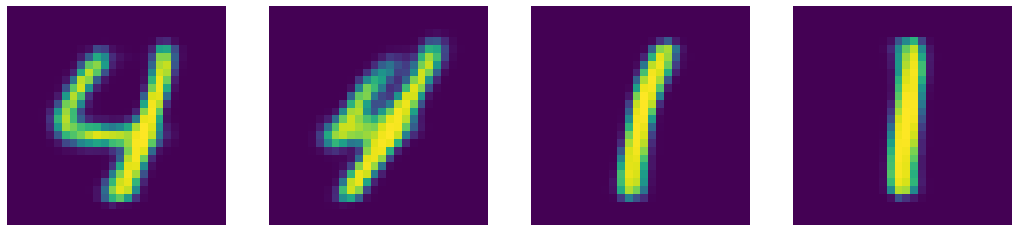

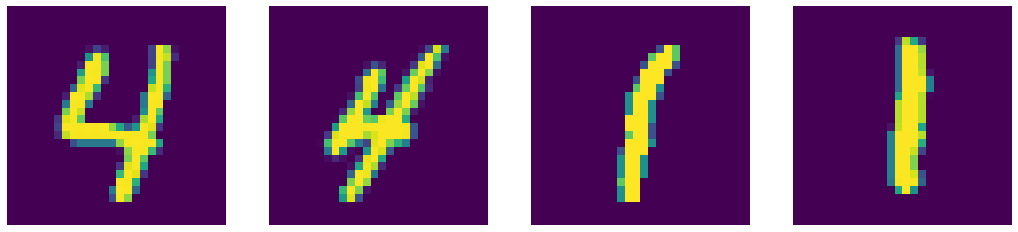

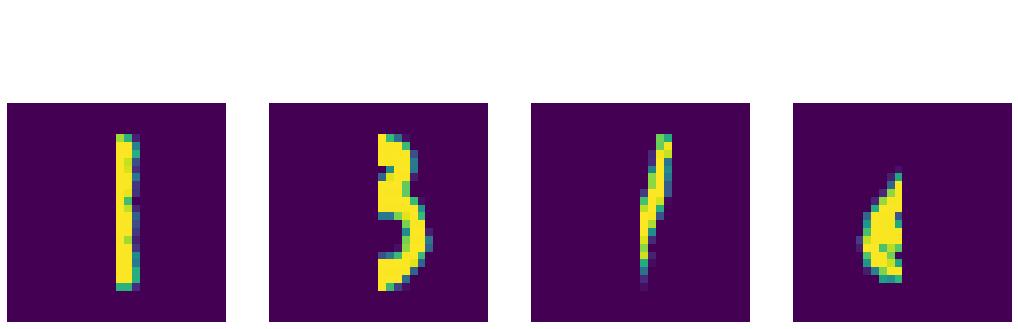

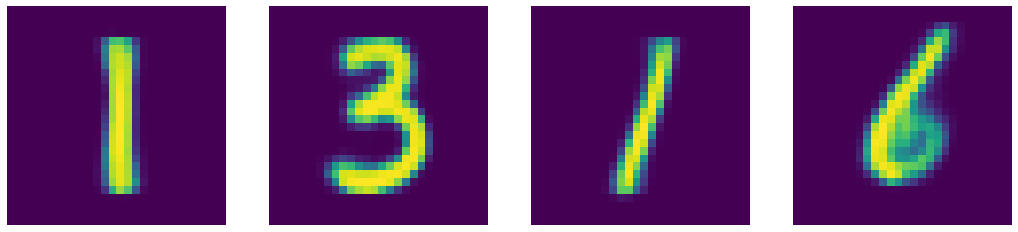

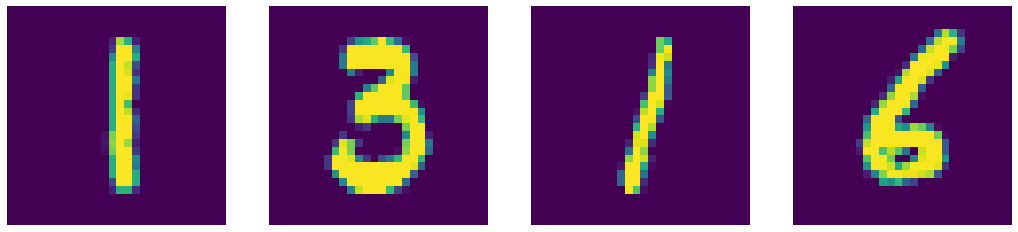

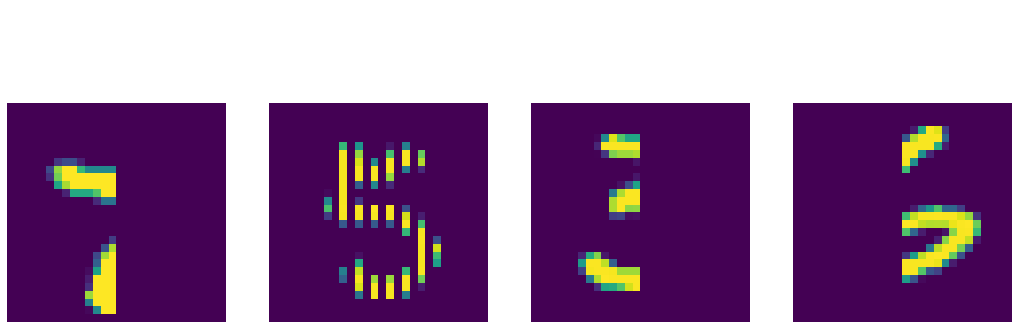

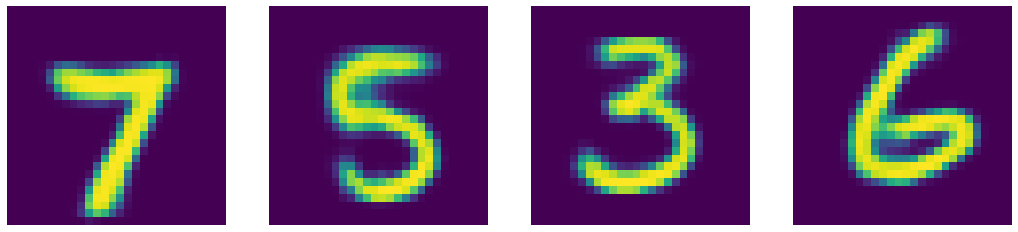

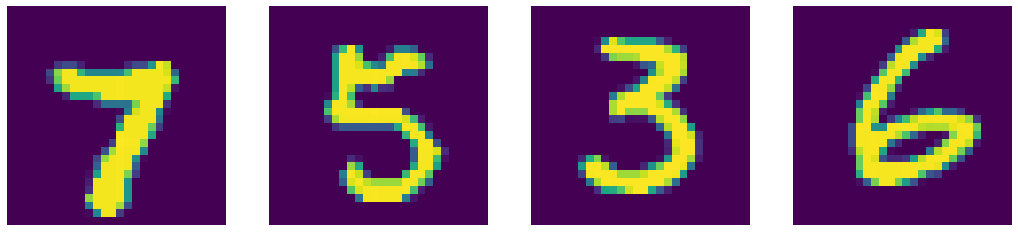

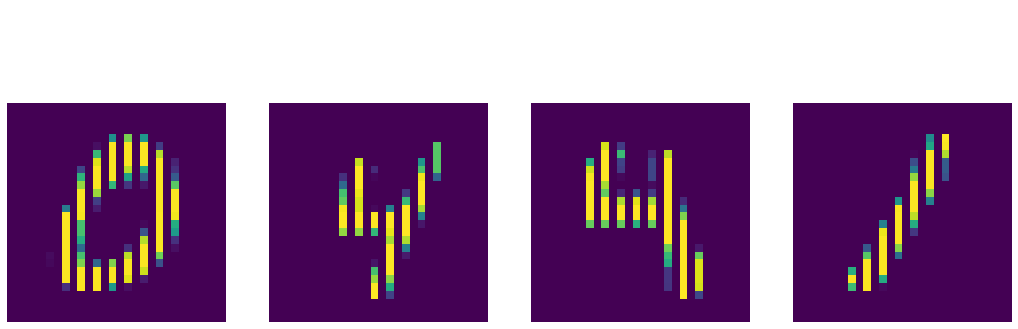

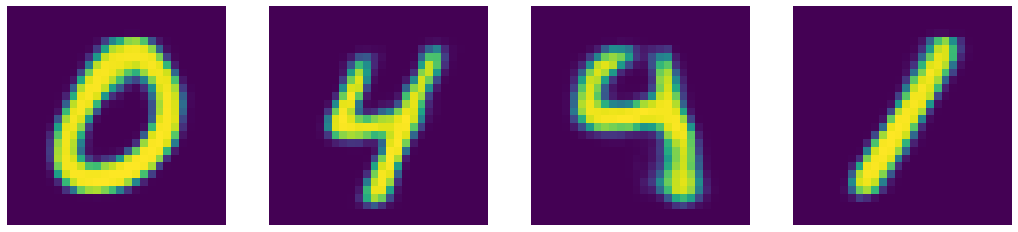

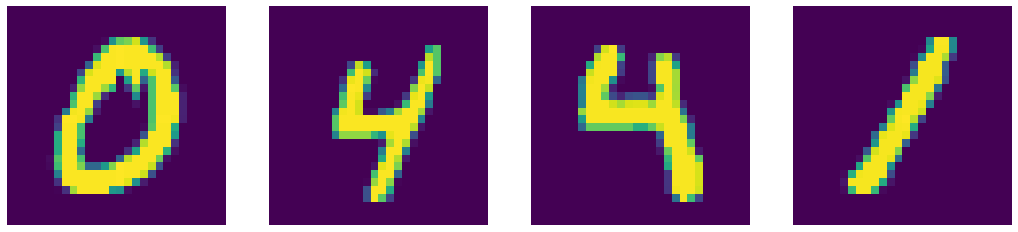

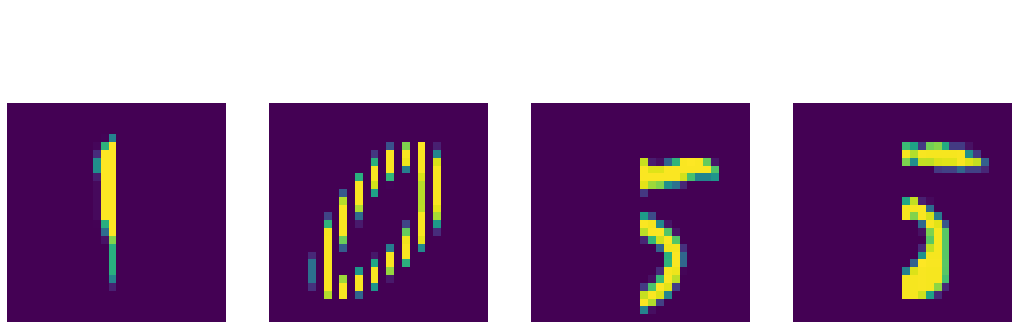

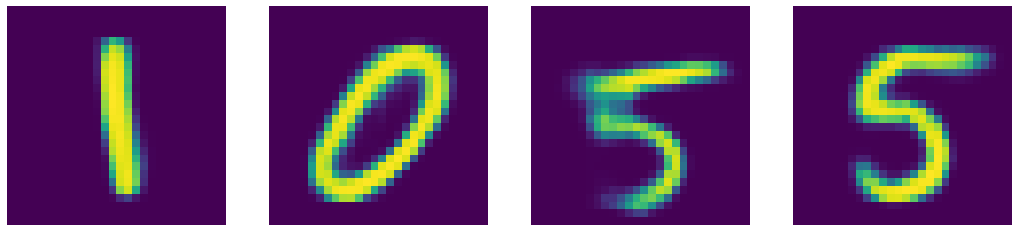

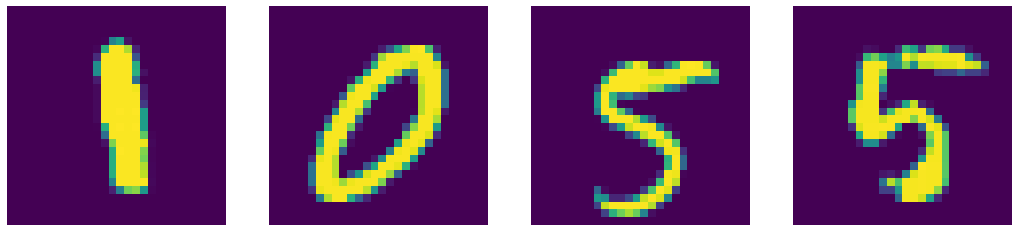

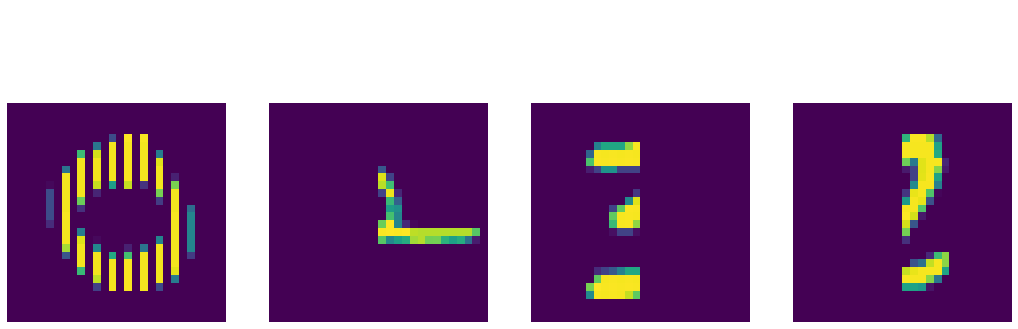

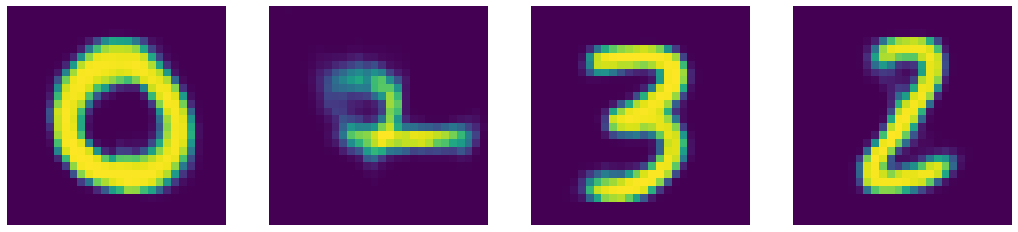

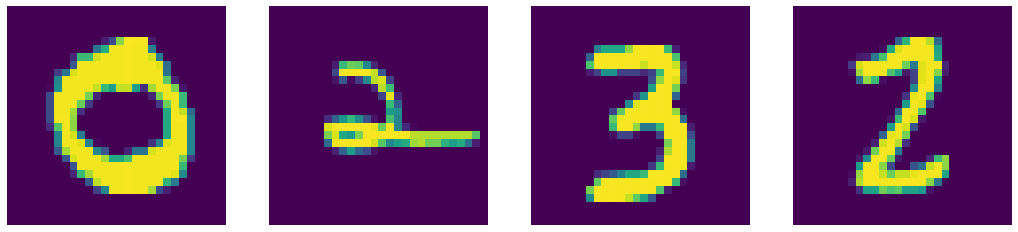

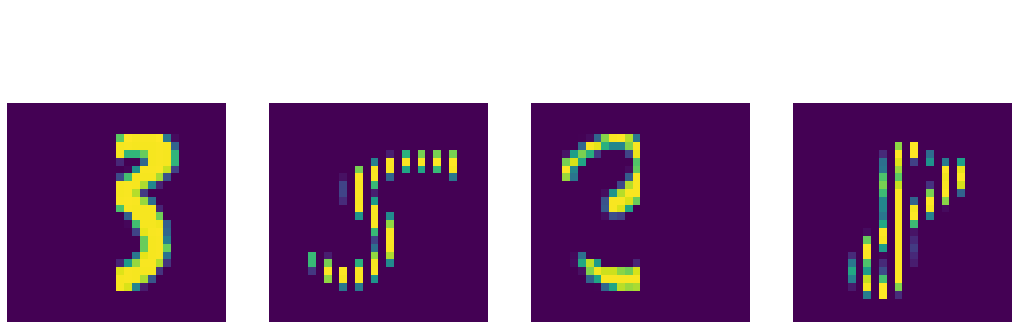

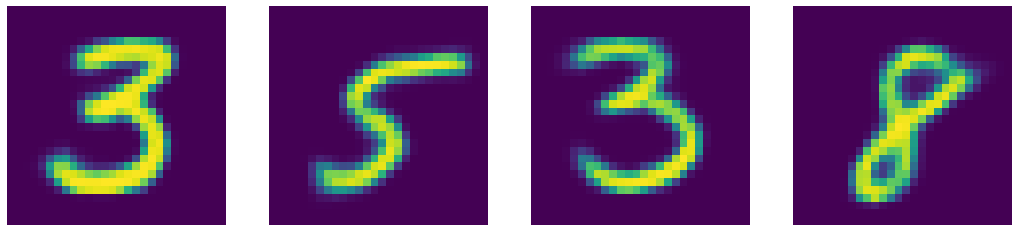

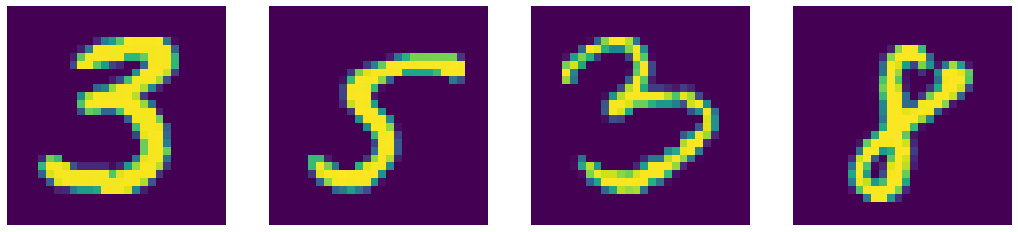

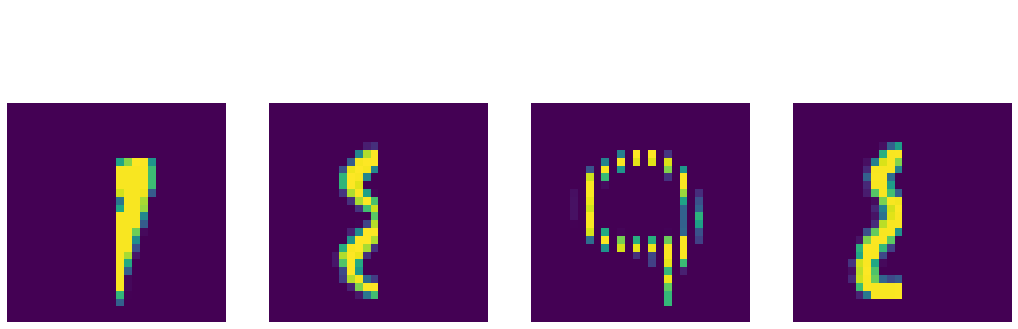

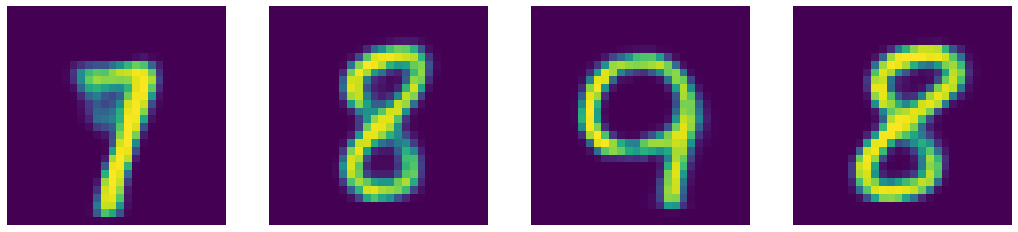

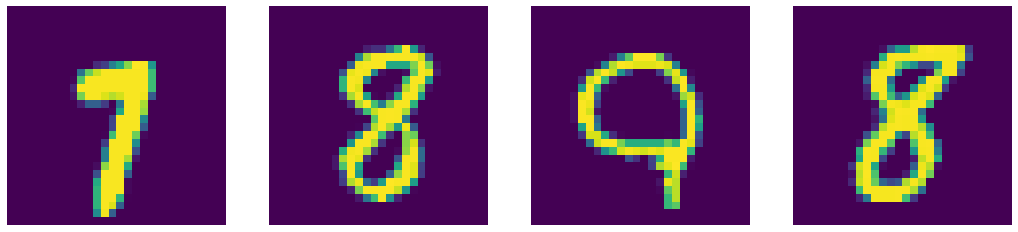

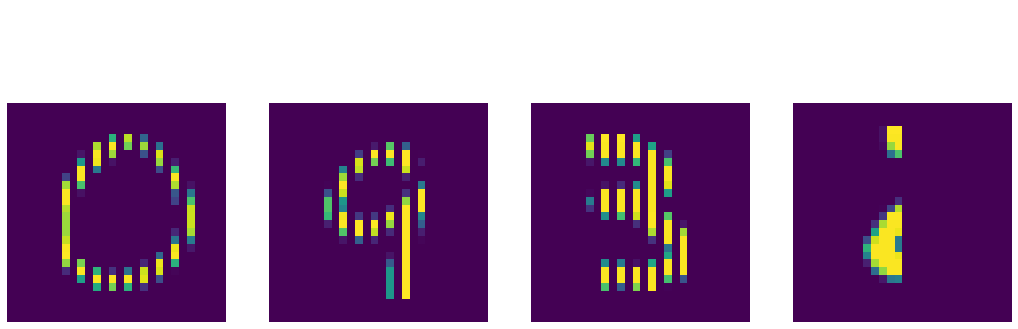

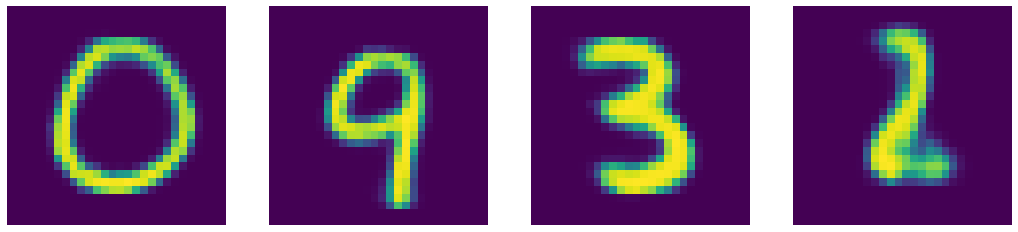

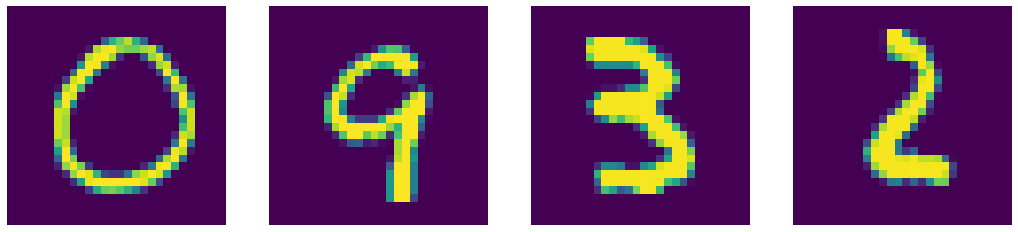

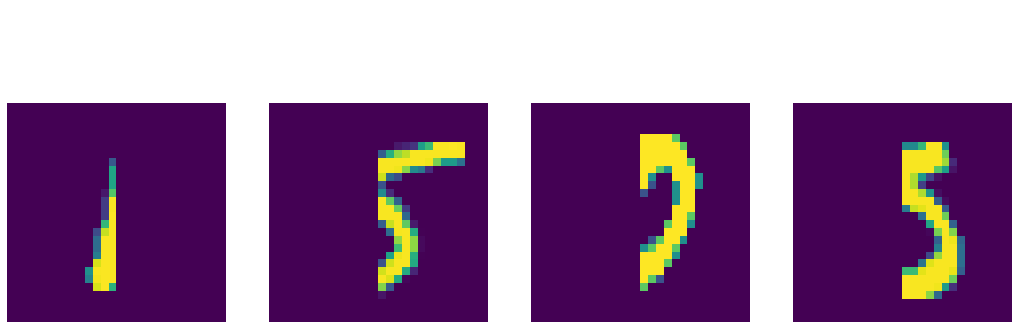

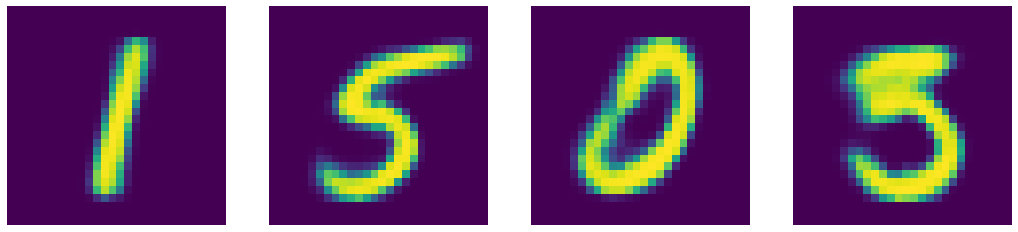

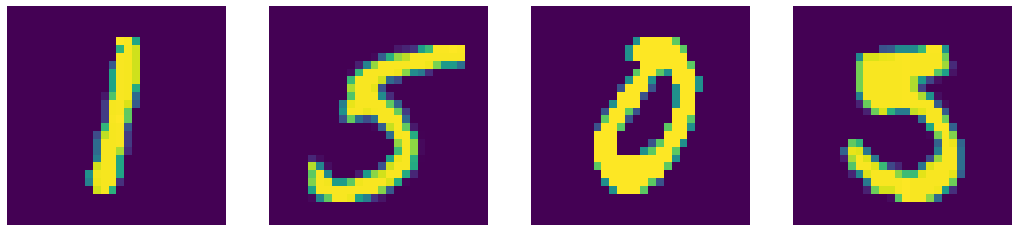

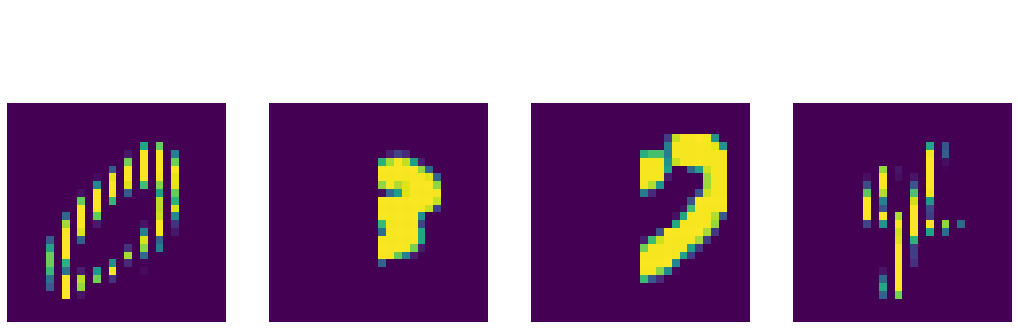

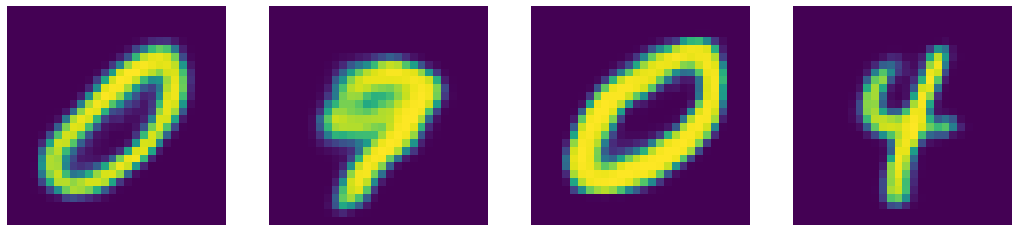

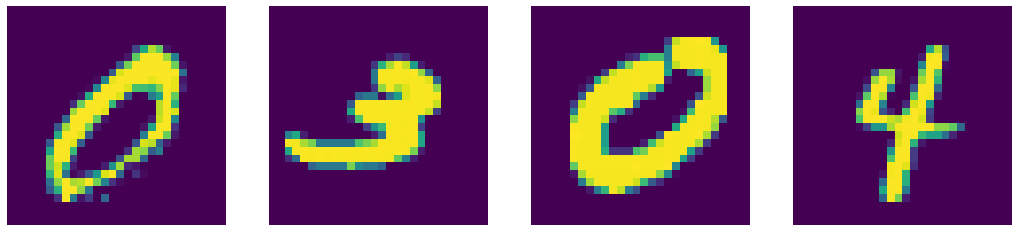

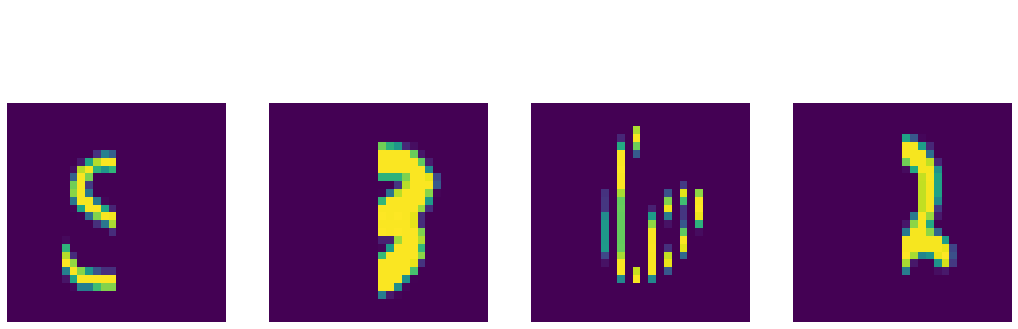

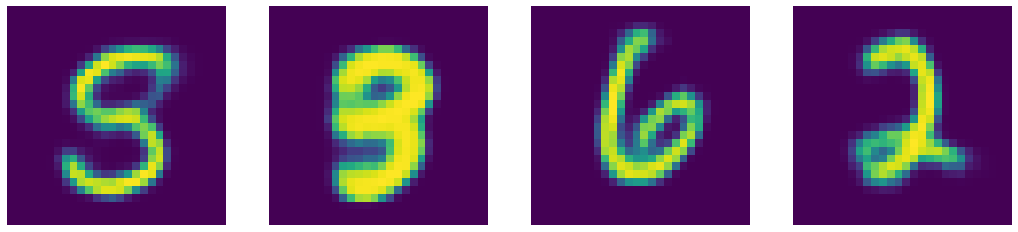

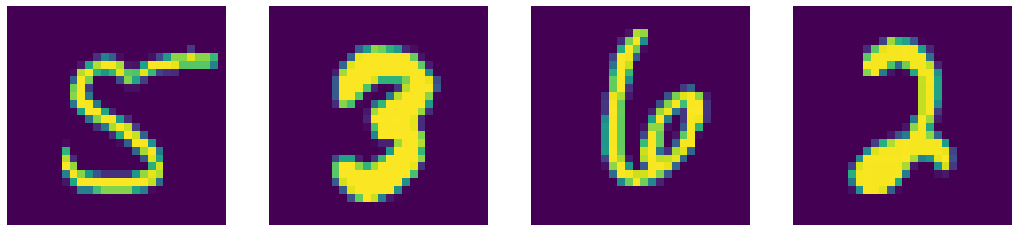

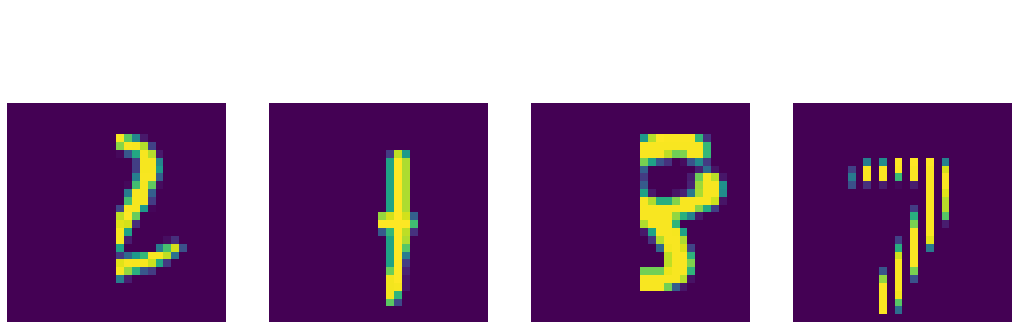

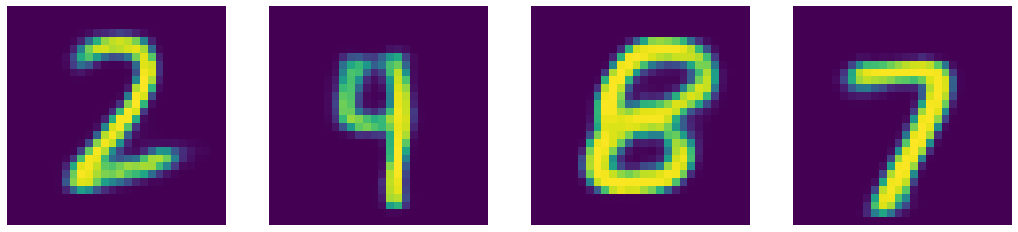

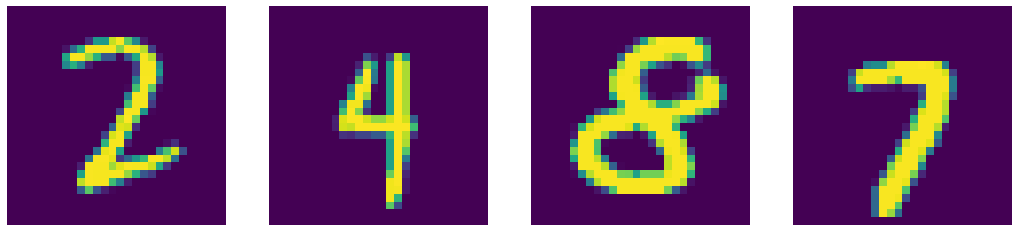

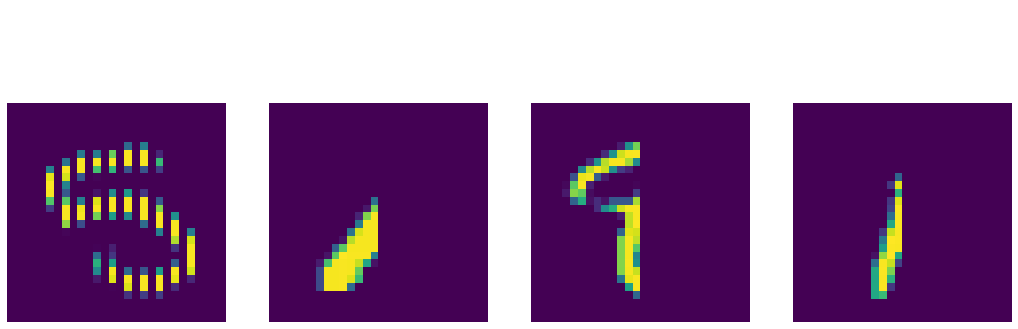

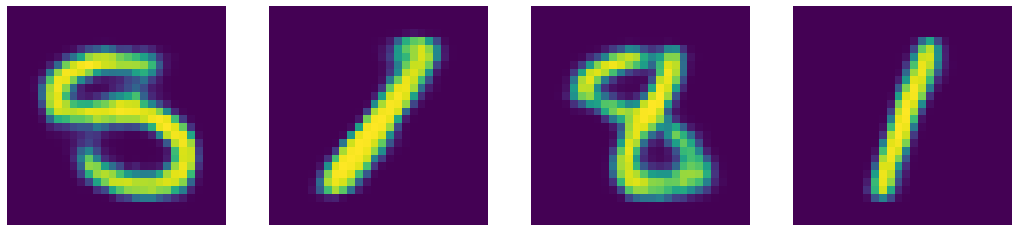

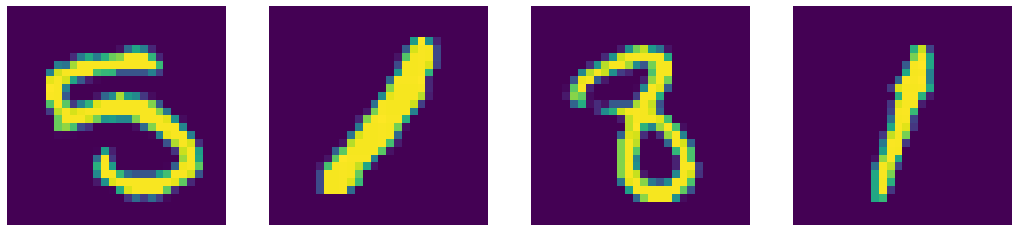

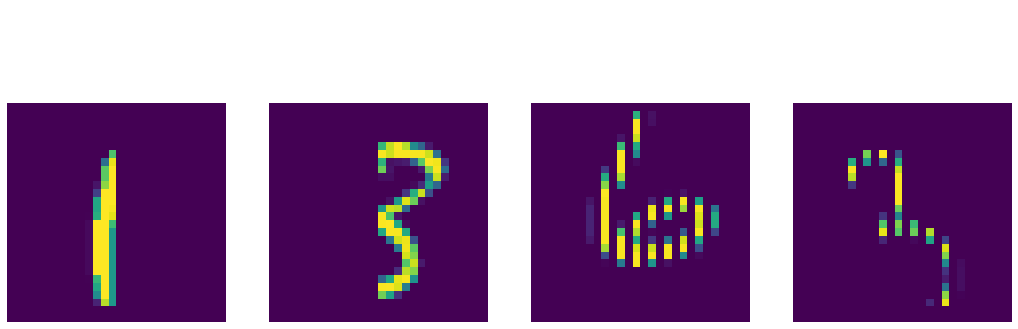

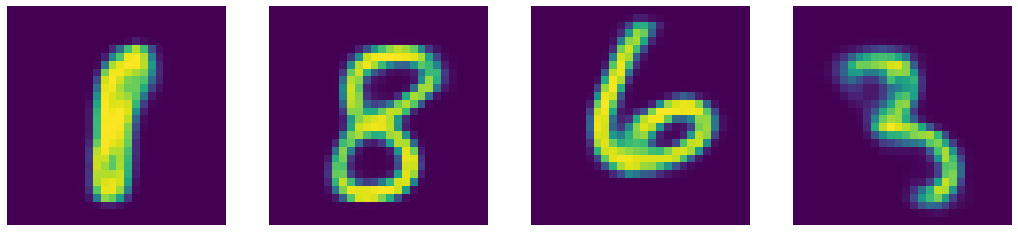

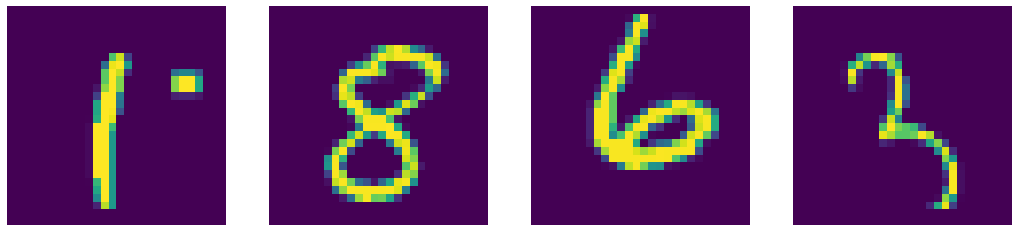

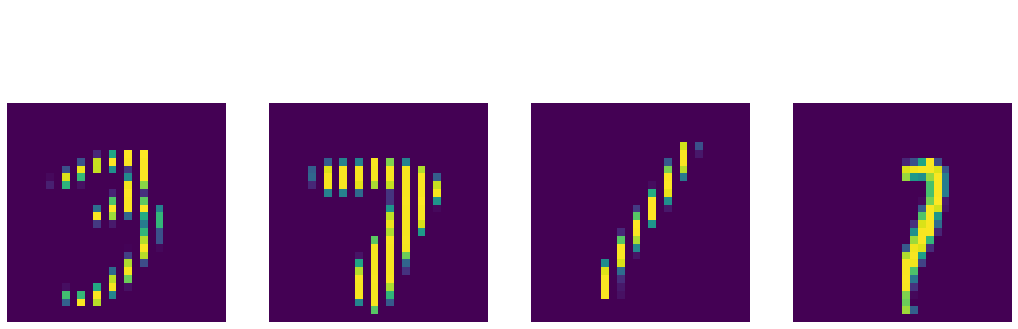

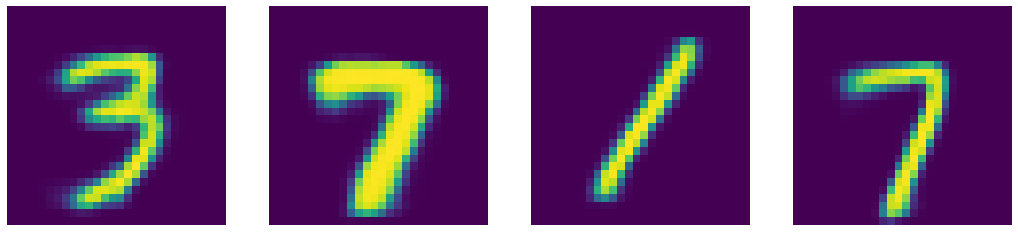

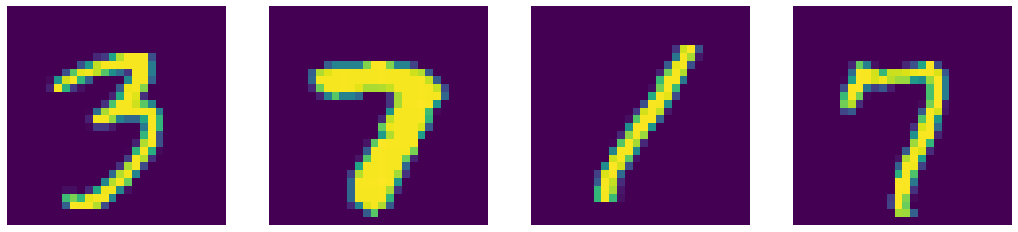

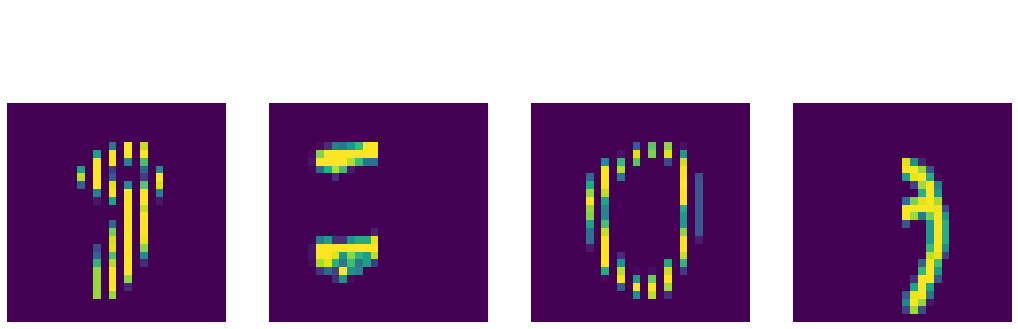

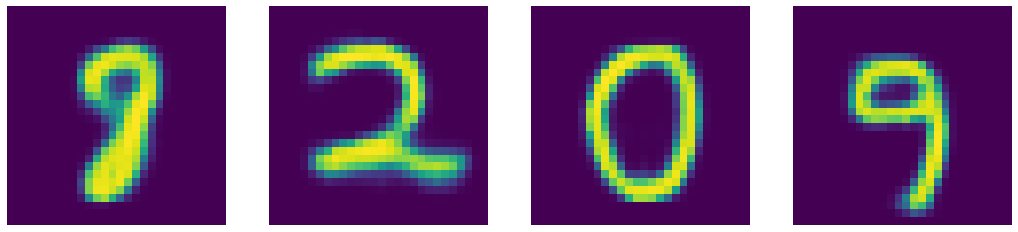

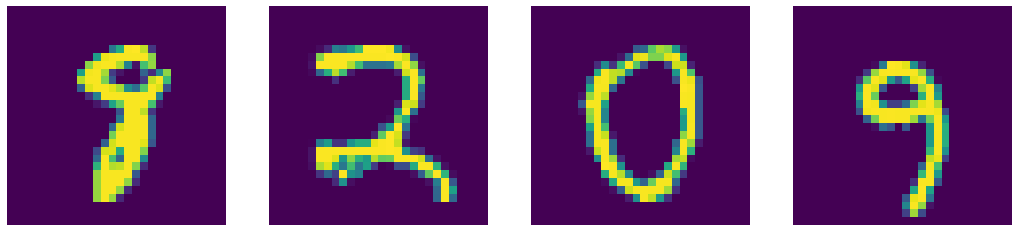

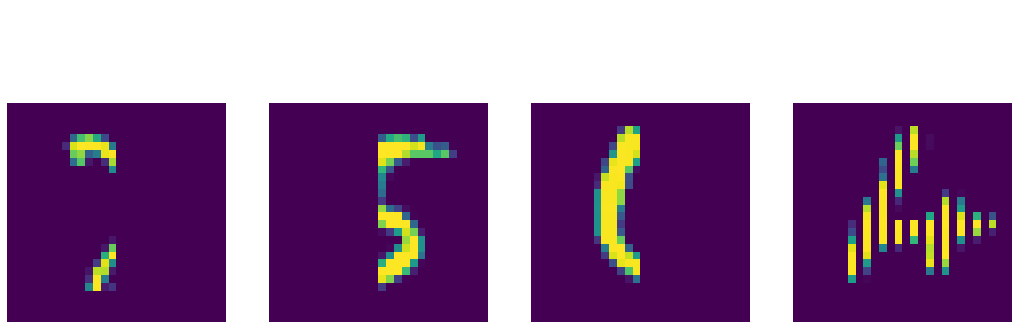

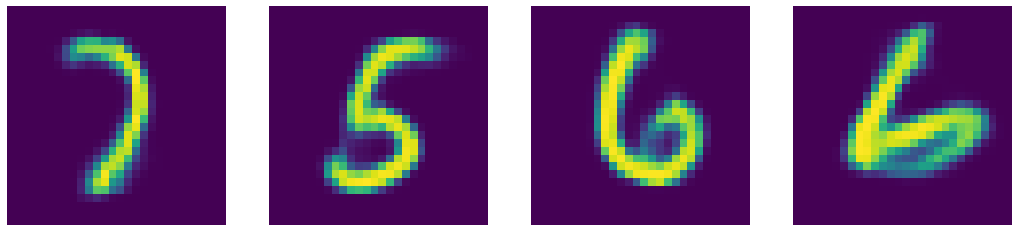

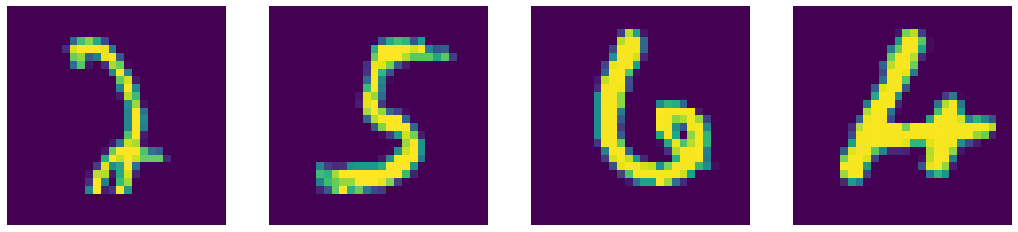

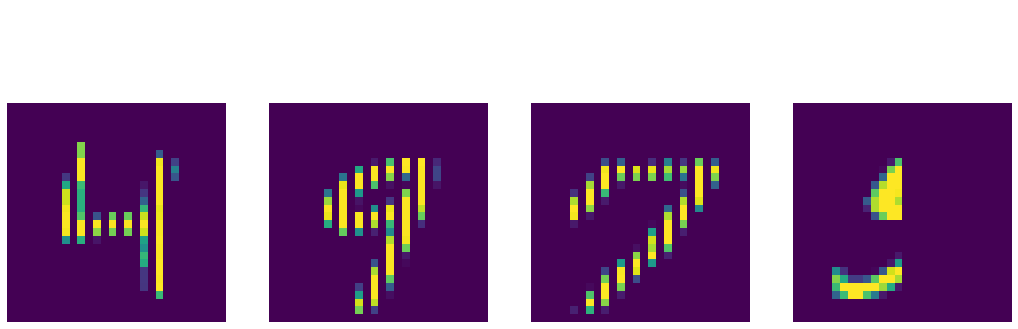

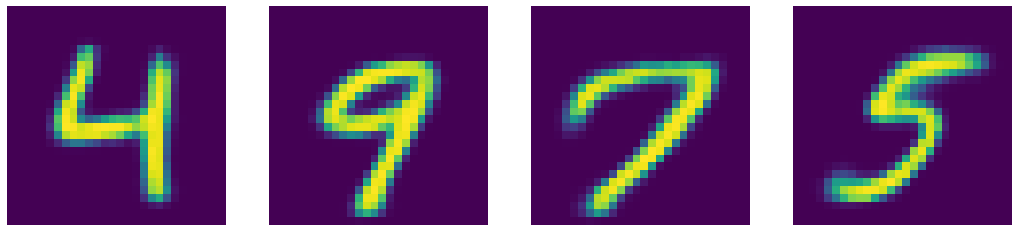

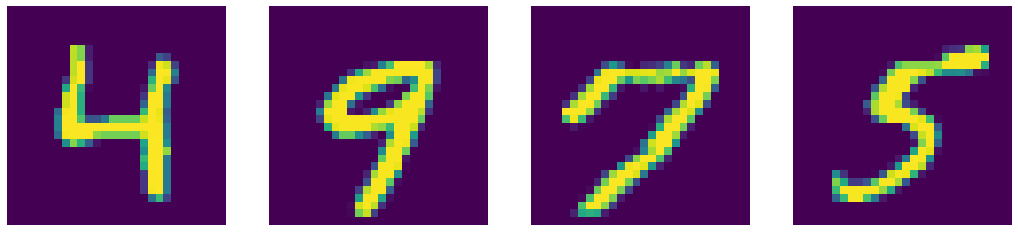

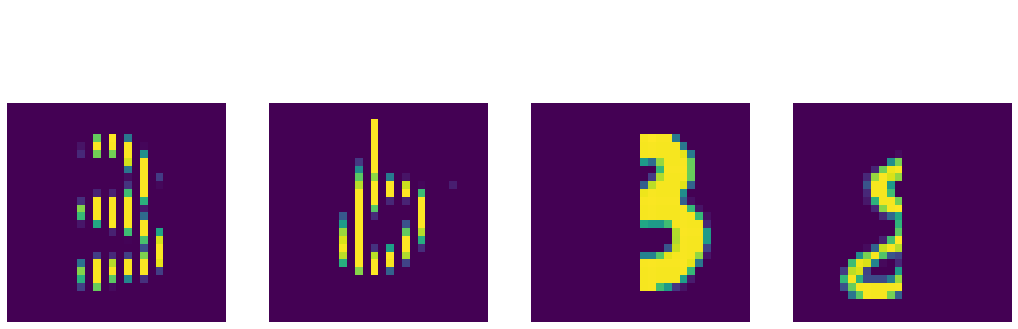

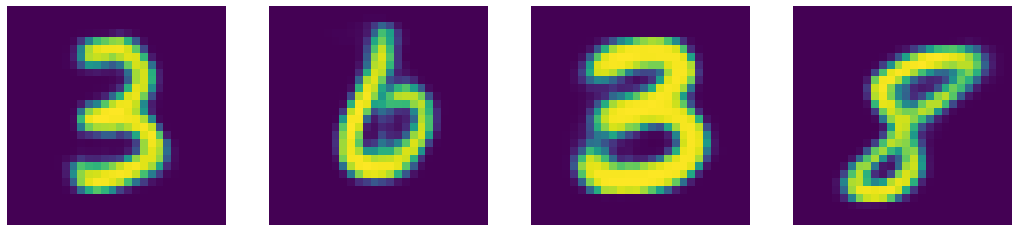

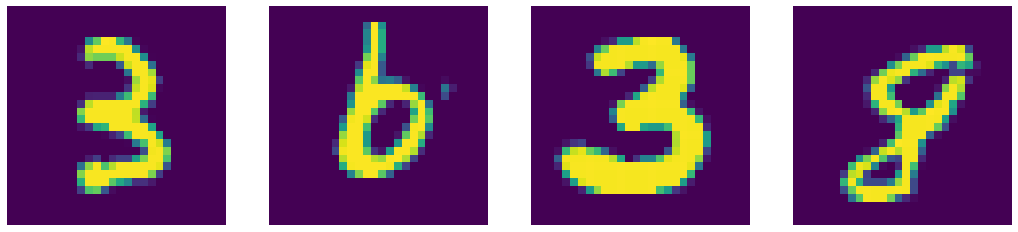

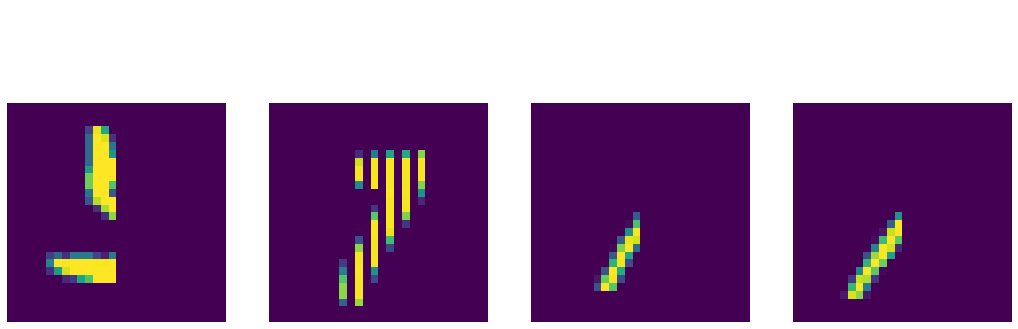

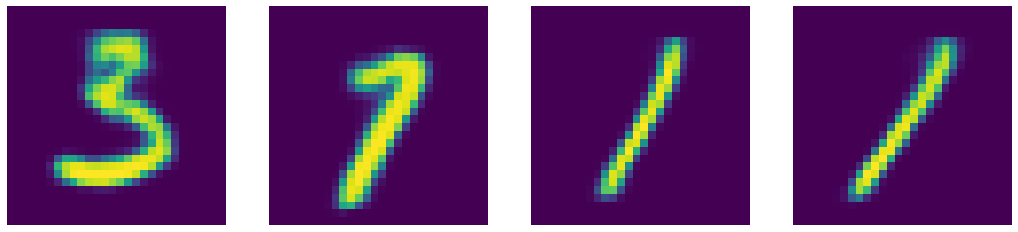

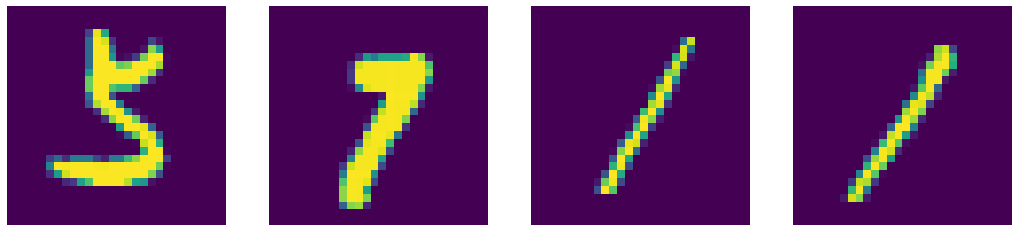

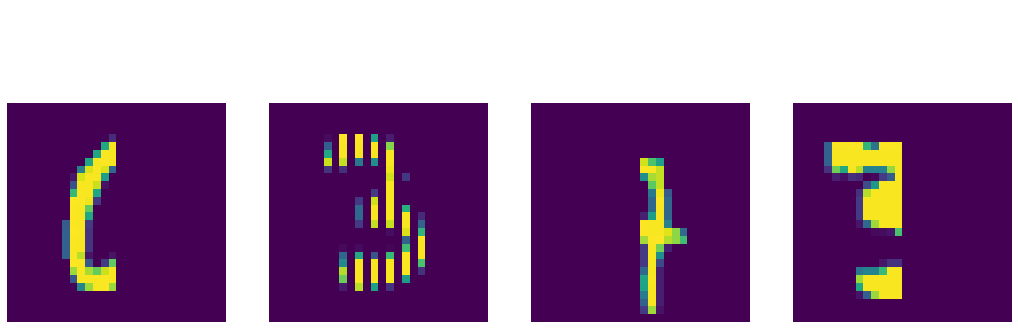

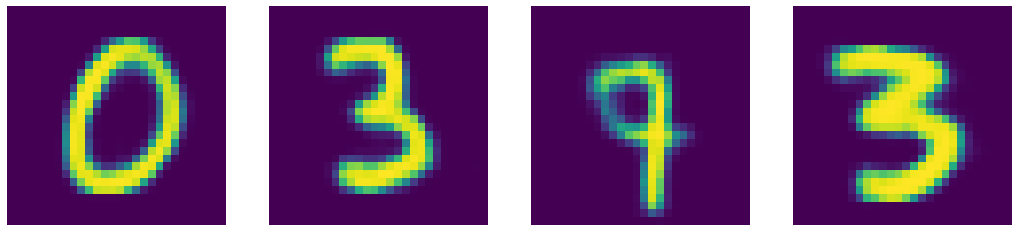

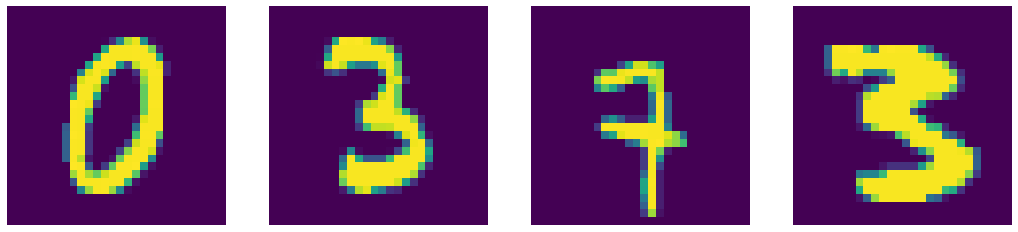

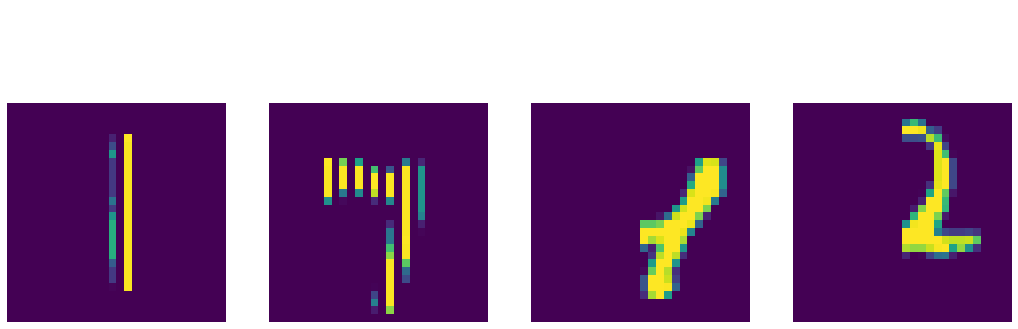

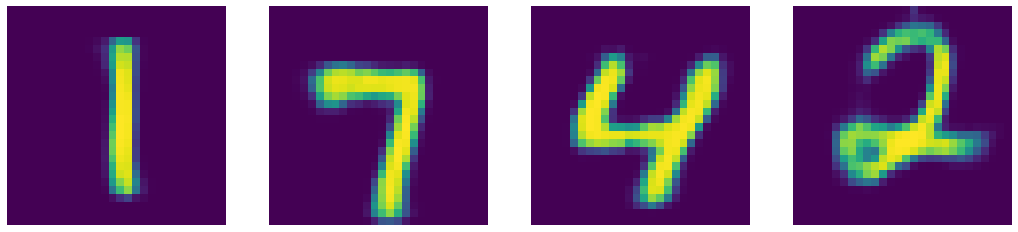

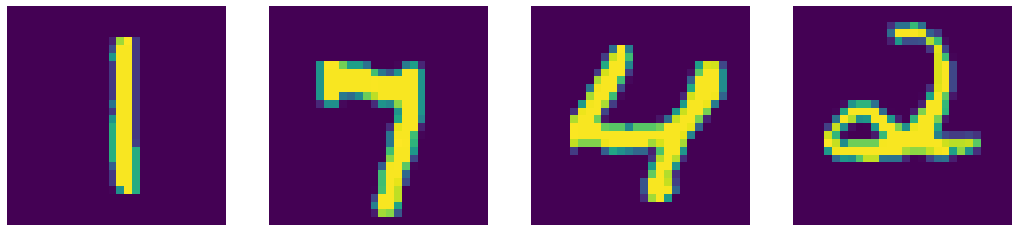

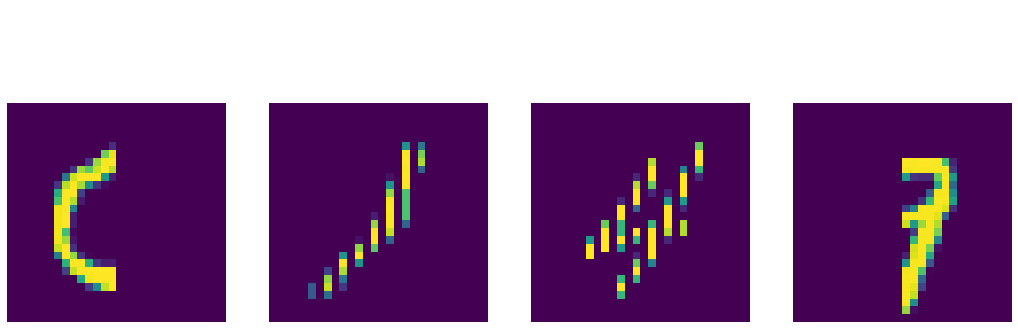

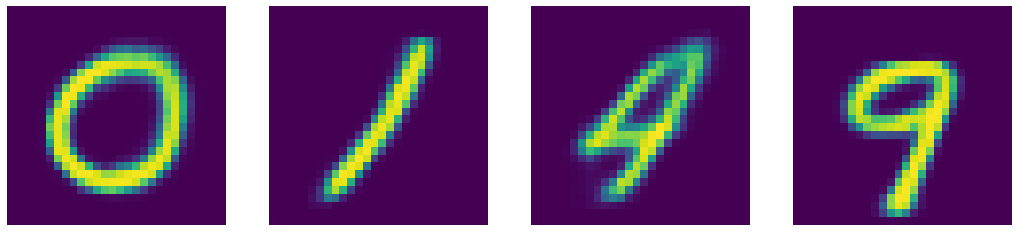

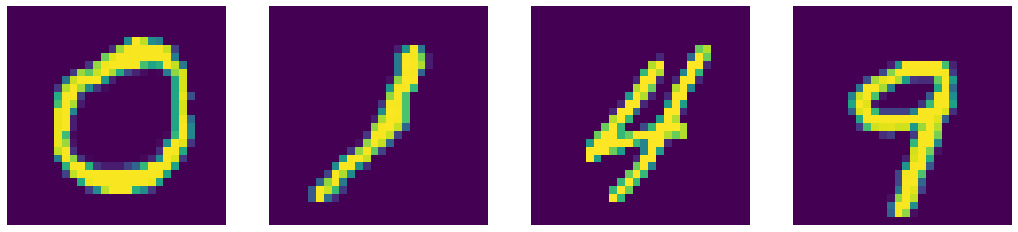

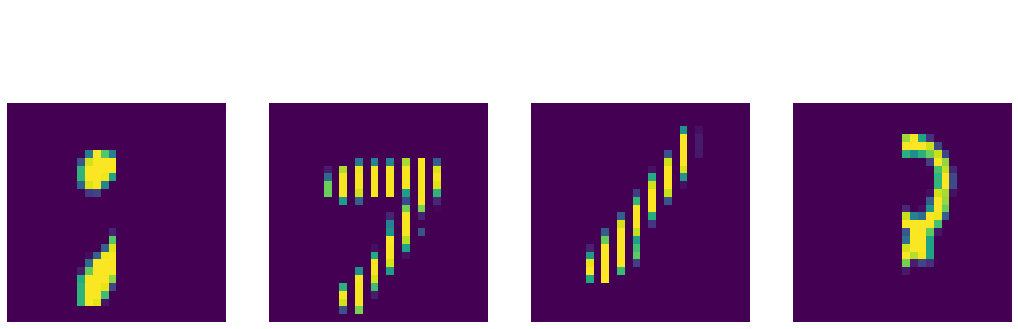

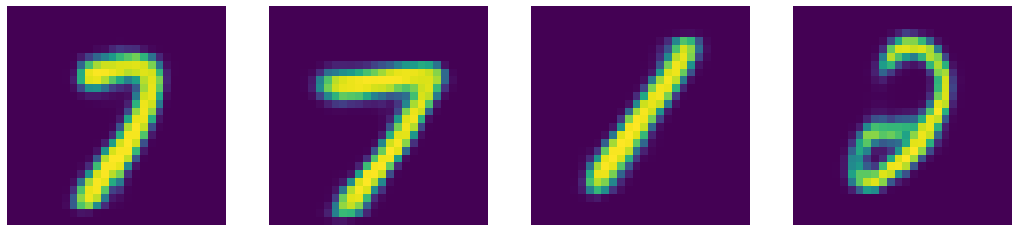

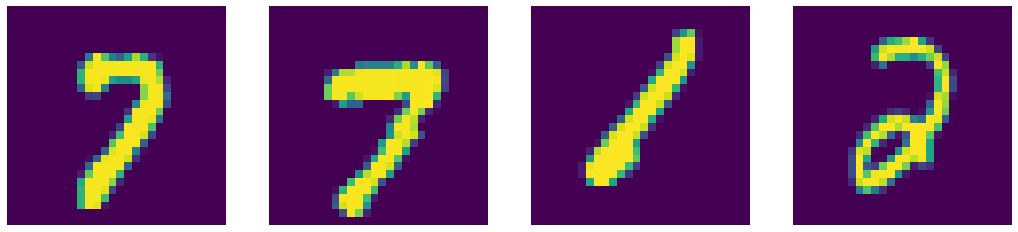

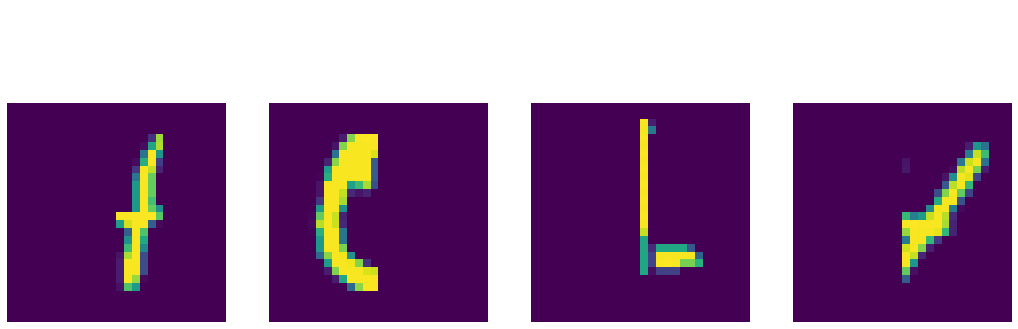

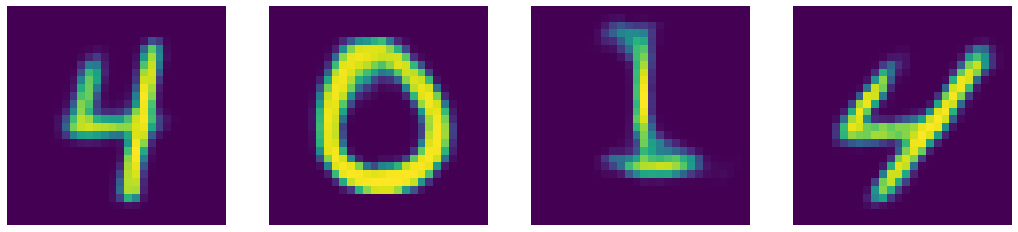

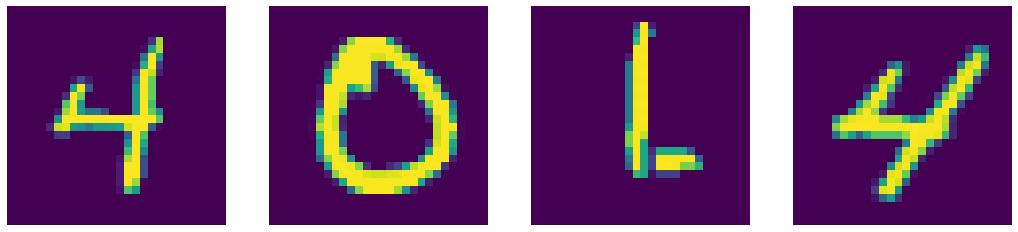

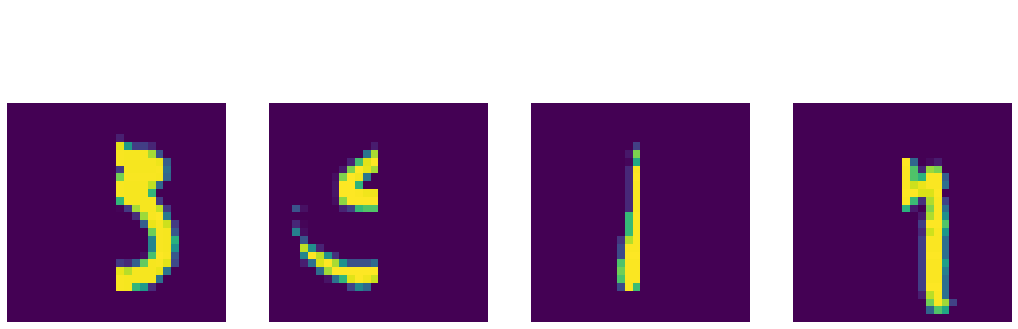

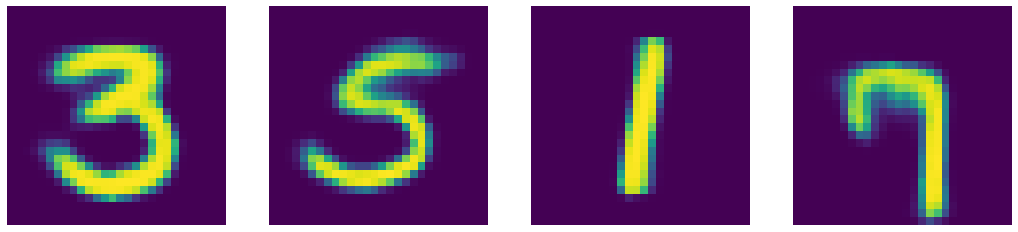

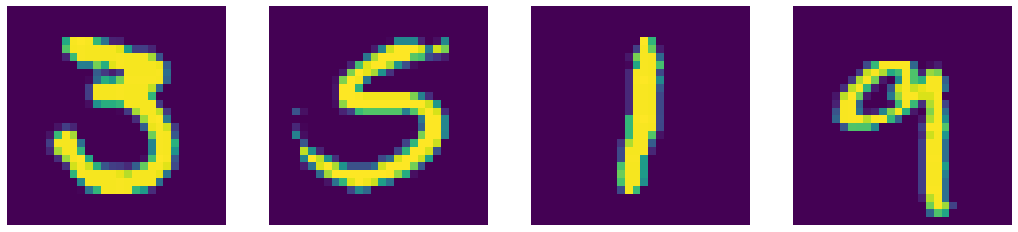

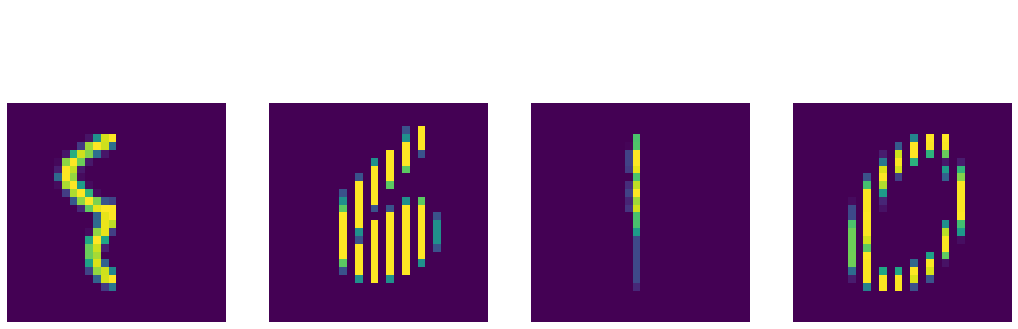

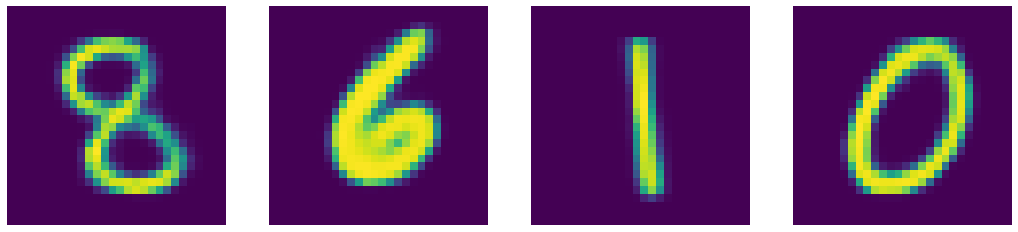

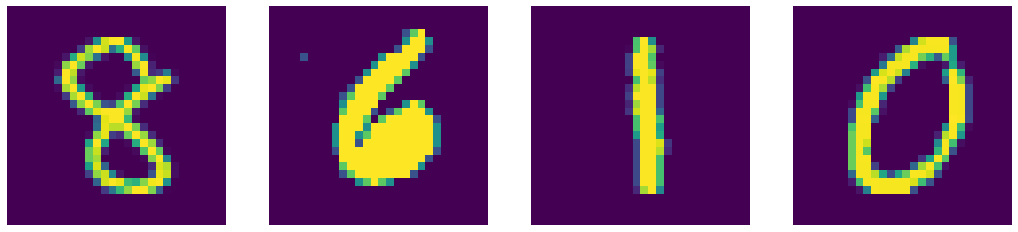

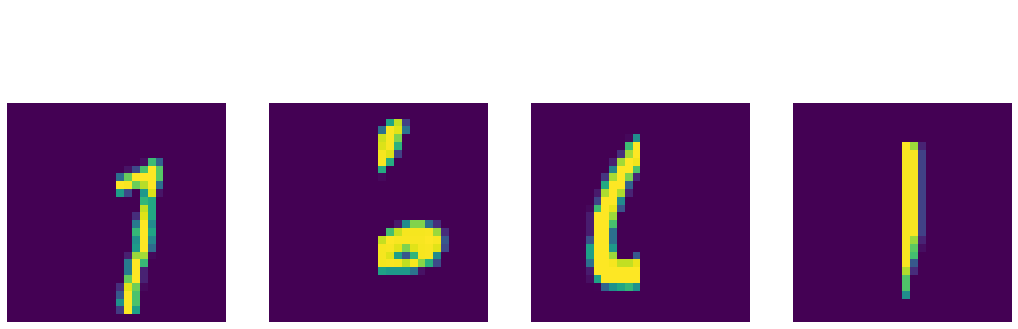

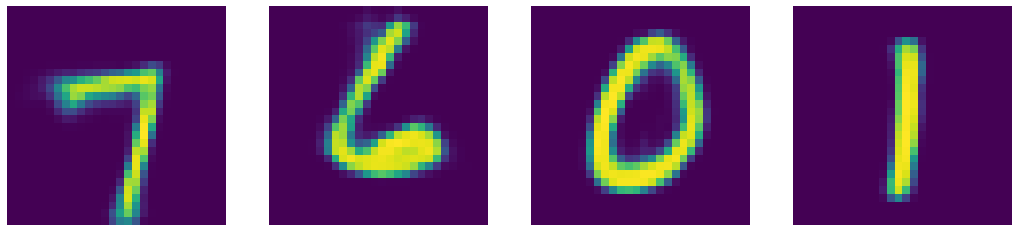

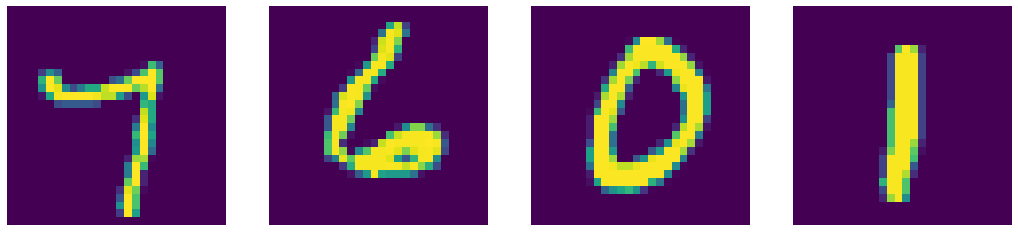

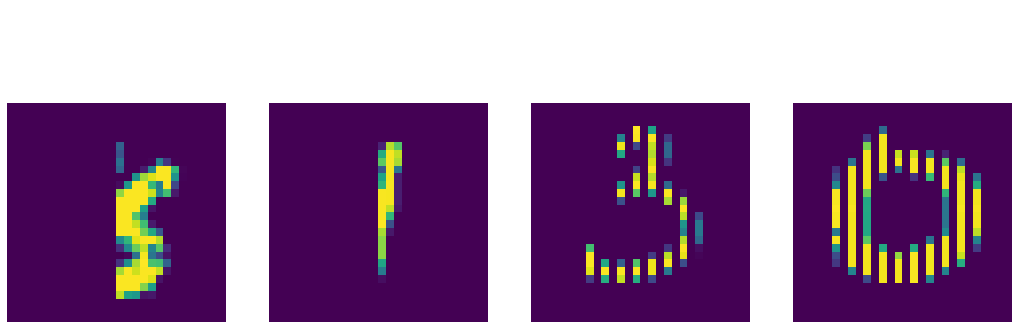

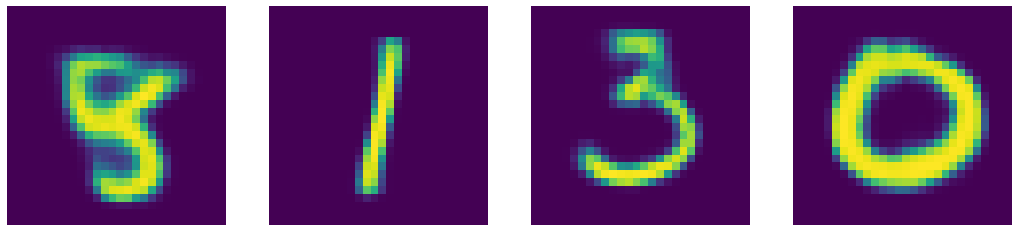

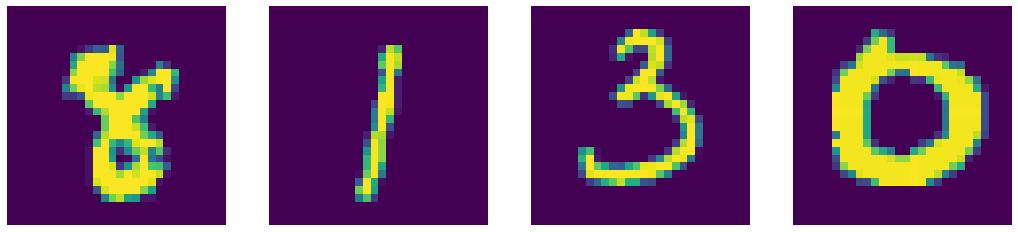

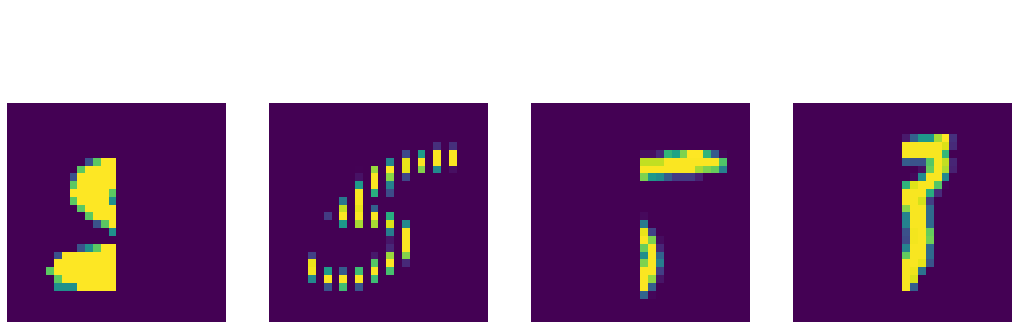

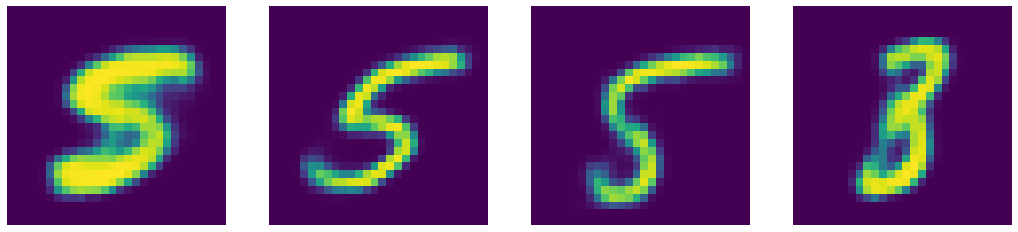

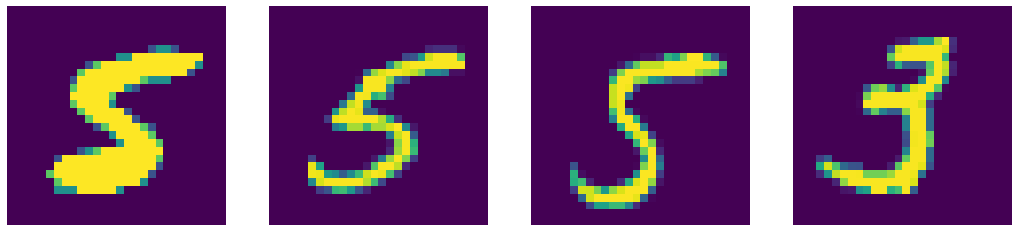

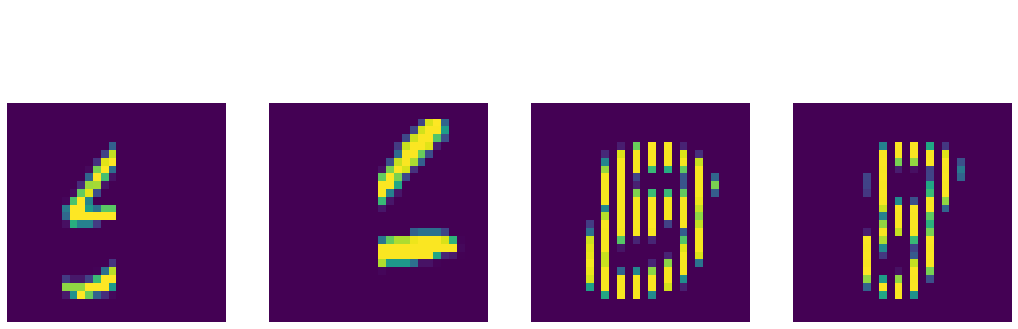

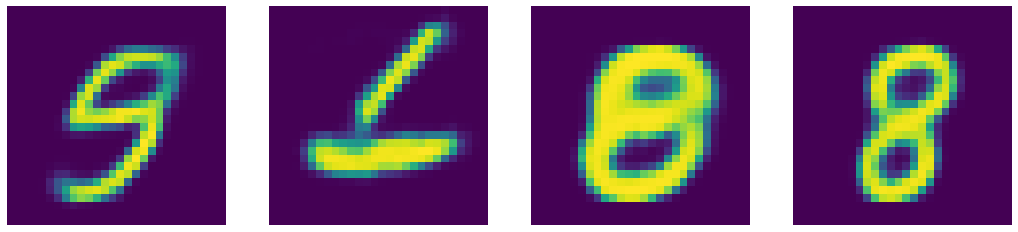

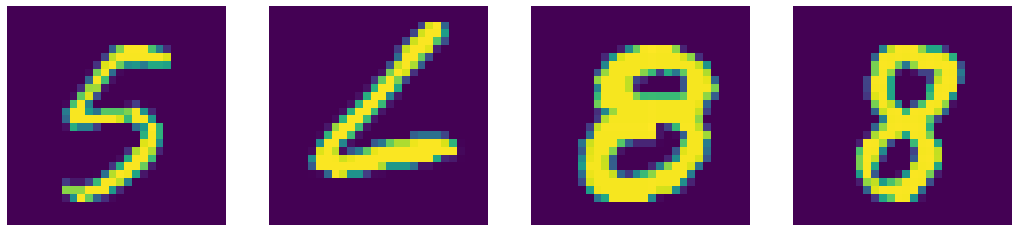

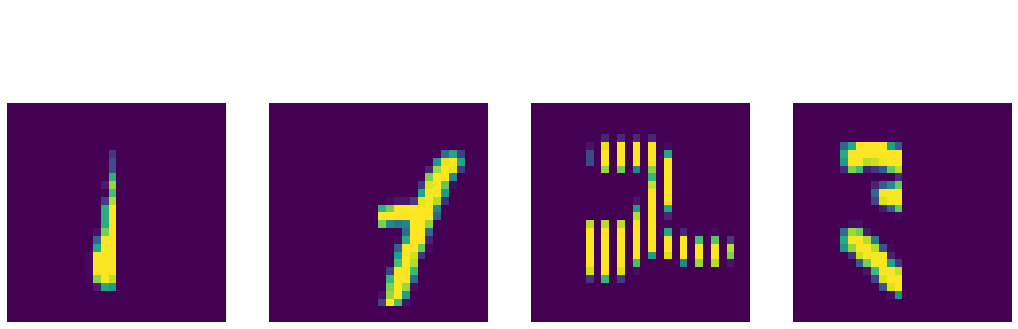

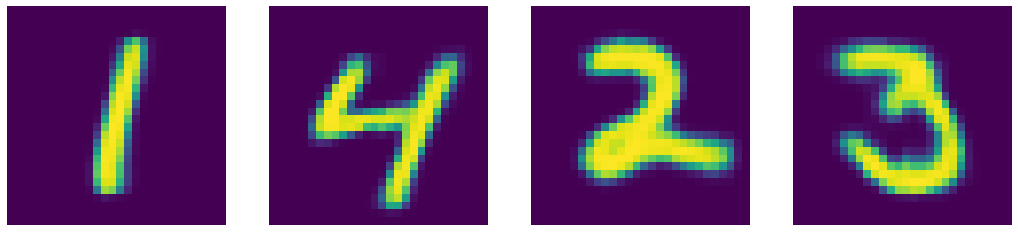

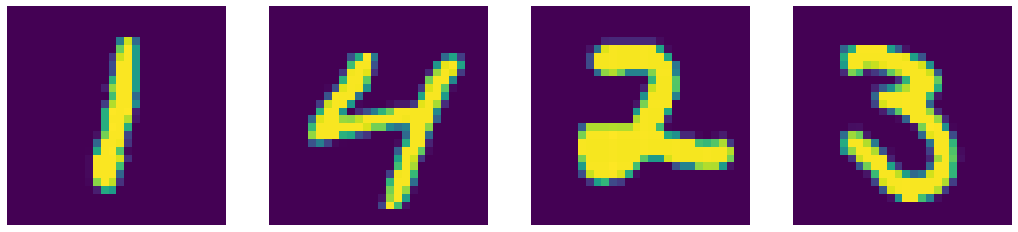

In [105]:
# Training the model
epochs = 150
codes = dict(μ=list(), logσ2=list(), y=list(), x=list())
for epoch in range(1, epochs+1):
    
    # train for one epoch
    train_loss = train()

    # print the train loss for the epoch
    print(f'====> Epoch: {epoch} Average train loss: {train_loss / len(ds_train_loader.dataset):.4f}')
    
    # evaluate this epoch over the test set
    test_loss, means, logvars, labels, images = test(epoch)

    # log for analysis
    codes['μ'].append(torch.cat(means))
    codes['logσ2'].append(torch.cat(logvars))
    codes['y'].append(torch.cat(labels))
    codes['x'].append(torch.cat(images))

    # print the test loss for the epoch
    print(f'====> Epoch: {epoch} Average test loss: {test_loss / len(ds_test_loader.dataset):.4f}')

In [ ]:
# save the state dict of the model
torch.save(model.state_dict(), 'vae-model.pt')

In [ ]:
# loading a saved module
device = torch.device('cpu')
model = VAE()
model.load_state_dict(torch.load('vae-model.pt',map_location=device))

### 2.2.3. Generating samples from the trained model

In [ ]:
# Generate 64 samples from the trained model and plot them.
samples = model.sample(64)
display_images(None, samples,None,'Generated Samples - Trained Model', 64 // 4, count=True)